# Imports

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import shutil
import geopandas as gpd
from shapely import wkt
import h3
#import pygeohash as pgh
import matplotlib.pyplot as plt
from IPython.display import Image
import sweetviz as sv
import boto3
import io
#from deltalake import DeltaTable
import duckdb
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from DSSATTools import *
from multiprocessing import Pool
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from time import sleep
#### Optimization part
##from pyswarms.single.global_best import GlobalBestPSO
from __future__ import division
import random

In [2]:
from skopt.sampler import Lhs
from skopt.space import Space
from skopt import gp_minimize

In [3]:

#!pip install git+https://github.com/daquinterop/Py_DSSATTools.git --user
#!pip install scikit-optimize --user
#!pip install deltalake --user
#!pip install h3 --user
#!pip install duckdb --user
#!pip install pygeohash --user


In [4]:
# Fixing hvac version
#!sudo pip uninstall hvac | pip install hvac==1.0.2 --user

# Classes

## Connect to CSW

In [3]:
"""
Connecting to Bayer's Crop Sciense Warehouse (CSW).

Main project:
    location360-datasets.
    product360-datasets.

Main datasets:
    environmental_data_cube.
        schemas: isric_global_soil_250, growth_stage_predictions_corn, growth_stage_predictions_soybean.
    historical_weather:
        routines query: historical_weather_daily_blend, historical_weather_hourly_blend.
"""

import hvac
import base64
import json
from google.oauth2 import service_account
from google.cloud import bigquery
import os
import pandas as pd

APPROLE_ID = os.environ['APPROLE_ID']
APPROLE_SECRET = os.environ['APPROLE_SECRET']

client = hvac.Client(url='https://vault.agro.services')
client.auth.approle.login(APPROLE_ID, APPROLE_SECRET)
secrets = client.read('secret/csw/service-identities/marketdevtrialinglatam')

if 'data' in secrets and type(secrets['data']['data']) == str:
    service_account_creds = json.loads(
        base64.b64decode(secrets['data']['data']))
else:
    service_account_creds = secrets

credentials = service_account.Credentials.from_service_account_info(
    service_account_creds)


class CSWconnect:
    """Class to connect to the Crop Science Warehouse (CSW).

    Attributes
    ----------
    project  
        name of the project which contain the datasets (e.g., 'location360-datasets').
    

    Methods
    -------
    load()
        get pandas dataframe from query used.
    save()
        save pandas dataframe as a table in CSW.
    """

    def __init__(self, project: str) -> None:
        self.credentials = credentials
        self.project = project
        self.bq_client = bigquery.Client(
            project=project, credentials=credentials)

    def load(self, query: str) -> pd.DataFrame:
        """Method to load CSW tables as pandas dataframe.
        
        Attributes
        ----------
        query  
            query to retrieve data from dataset project.
        
        Returns
        ------
        df 
            Dataframe obtained from CSW query.

        """

        df = pd.read_gbq(query,
                         project_id=self.project,
                         credentials=credentials,
                         use_bqstorage_api=True)
        return df

    def save(self, DF: pd.DataFrame, BQ_table: str, append: bool = False) -> None:
        """Method to save a pandas dataframe in CSW.

        Attributes
        ----------
        DF  
            pandas dataframe to upload in CSW.
        
        BQ_table  
            table name, e.g., 'latam_datasets.dssat_brazil_soybeans'.
        
        Append
            choose if append (True) or replace (False) the CSW table.
        
        Returns
        ------
        None 

        """
        BQ_table_up = self.project + '.' + BQ_table
        
        if append:
            job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_APPEND")
        else:
            job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_TRUNCATE")

        self.bq_client.load_table_from_dataframe(
            DF, BQ_table_up, job_config=job_config)

## Weather CSW

In [7]:
"""
Retrieving weather data from CSW.

"""
from datetime import datetime
from DSSATTools import WeatherData, WeatherStation
import numpy as np
# from ..CSW.connect import CSWconnect


class BayWeather:
    """Class to get weather data from CSW.

    Attributes
    ----------
    lon
        longitude decimal degree coordinate.
    lat
        latitude decimal degree coordinate.
    start
        start of the weather series.
    end     
        end of the weather series.
        
    Methods
    -------
    TWC()
        get weather data from The Weather Company (TWC) data stored in CSW.
    WPD()
        compute Wetting Period Duration (WPD), a important weather feature for crop protection.
    """

    def __init__(self, lon: float, lat: float, start: datetime, end: datetime) -> None:
        self.lon = lon
        self.lat = lat
        self.start = start.replace(tzinfo=None)
        self.end = end.replace(tzinfo=None)

    def TWC(self) -> pd.DataFrame:
        """Method to get daily weather series from The Weather Company (TWC) source in CSW.

        Attributes
        ----------
        None

        Returns
        -------
        TWC()
            dataframe obtained from TWC-CSW.

        """
        rad = np.pi / 180  # Radians to degrees
        gra = 180 / np.pi  # Degrees to radians

        query_wth = """ 
            DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [({},{})];
            DECLARE u_start_date DATE DEFAULT DATE('{}');
            DECLARE u_end_date DATE DEFAULT DATE('{}');
            DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation';
            DECLARE uom STRING DEFAULT 'm';
            CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);
            """.format(
            self.lat, self.lon, self.start, self.end
        )

        df_wth = (
            CSWconnect("location360-datasets").load(query_wth).sort_values(by="date")
        )
        df_wth["DOY"] = df_wth["date"].apply(lambda x: int(x.strftime("%j")))

        ## Incident solar radiation (Rs_in)
        Ko = 37.63 * (1 + (0.033 * (np.cos(rad * ((360 * df_wth["DOY"]) / 365)))))
        ds = 23.45 * np.sin(rad * (360 * (df_wth["DOY"] - 80) / 365))
        hn = (np.arccos(-np.tan(rad * df_wth["lat"][0]) * np.tan(rad * ds))) * gra
        Qo = Ko * (
            rad * hn * np.sin(rad * df_wth["lat"][0]) * np.sin(rad * ds)
            + np.cos(rad * df_wth["lat"][0]) * np.cos(rad * ds) * np.sin(rad * hn)
        )

        df_wth["downward_solar_radiation"] = (
            0.16
            * Qo
            * ((df_wth["max_temperature"]) - (df_wth["min_temperature"])) ** 0.5
        )
        
        query_elev = """ 
            WITH twc_cod AS (
              SELECT 
                grid_id, elevation, lat, lon, geohash4, geom 
              FROM 
                historical_weather.twc_cod_grids 
              ),
              point AS (
              SELECT 
                ST_GEOGPOINT({},{}) as pt_geom 
              )
            SELECT 
              elevation
            FROM 
              twc_cod, point 
            WHERE 
              geohash4 IN (ST_GEOHASH(point.pt_geom, 4))
            ORDER BY 
              ST_DISTANCE(point.pt_geom, twc_cod.geom) LIMIT 1
              """.format(lon, lat)

        elev = CSWconnect("location360-datasets").load(query_elev).squeeze()
       
        df_wth['elevation'] = elev

        return df_wth

    def WPD(self) -> pd.DataFrame:
        """Method to get hourly relative humidity data from TWC-CSW and to compute WPD. 

        Attributes
        ----------
        None

        Returns
        -------
        WPD()
             dataframe representing the number of night hours that relative humidity was higher than 90%.

        """
        query_wth = """ 
            DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [({},{})];
            DECLARE u_start_date DATE DEFAULT DATE('{}');
            DECLARE u_end_date DATE DEFAULT DATE('{}');
            DECLARE u_variables STRING DEFAULT 'relative_humidity';
            DECLARE uom STRING DEFAULT 'm';
            CALL `historical_weather.historical_weather_hourly_blend`(locations, u_start_date, u_end_date, u_variables, uom);
            """.format(
            self.lat, self.lon, self.start, self.end
        )

        df_rh = (
            CSWconnect("location360-datasets").load(query_wth).sort_values(by="local_time")
        )

        df_rh.index = pd.to_datetime(df_rh["local_time"], format="%Y-%m-%d %H:%M:%S")
        df_rh.sort_index(inplace=True)

        df_rh_night = df_rh["relative_humidity"].between_time("18:00", "06:00")

        df_rh_90 = df_rh_night[df_rh_night > 90]

        WPD = df_rh_90.groupby(
            by=[df_rh_90.index.year, df_rh_90.index.month, df_rh_90.index.day]
        ).count()
               
        
        WPD.index = pd.to_datetime(
            WPD.index.get_level_values(0).astype(str)
            + "-"
            + WPD.index.get_level_values(1).astype(str)
            + "-"
            + WPD.index.get_level_values(2).astype(str),
            format="%Y-%m-%d",
        )
        
        WPD.name = 'WPD'

        return WPD

## Soil CSW

In [8]:
"""
Retrieving soil profile data from CSW.

"""
from datetime import datetime
from DSSATTools import SoilProfile, SoilLayer
import numpy as np
#from ..CSW.connect import CSWconnect

class BaySoil:
    """Class to get soil data from CSW.

    Attributes
    ----------
    lon
        longitude decimal degree coordinate.
    lat
        latitude decimal degree coordinate.

    Methods
    -------
    Texture_ISRIC()
        get soil texture information as a dataframe from ISRIC-250 CSW table.
    
    """

    def __init__(self, lon: float, lat: float) -> None:
        self.lon = lon
        self.lat = lat

    def Texture_ISRIC(self) -> pd.DataFrame:   
        query_txt = """ 
            WITH hid_h3 AS (
              SELECT 
                `location360-datasets.environmental_data_cube.h3_2_hid`(h3, 10) AS hid_loc, h3
              FROM 
                (Select jslibs.h3.geoToH3({},{}, 10) h3)
            )
            SELECT 
              h3_index_10, clyppt_depth_0cm, clyppt_depth_5cm, clyppt_depth_15cm, clyppt_depth_30cm, clyppt_depth_60cm, clyppt_depth_100cm, 
              sltppt_depth_0cm, sltppt_depth_5cm, sltppt_depth_15cm, sltppt_depth_30cm, sltppt_depth_60cm, sltppt_depth_100cm, 
            FROM 
              `environmental_data_cube.isric_global_soil_250`, hid_h3
            WHERE 
              hid IN (hid_h3.hid_loc) AND h3_index_10 IN (hid_h3.h3)
                """.format(self.lat, self.lon)

        df_txt = CSWconnect("location360-datasets").load(query_txt)
        df_txt['lon'] = self.lon
        df_txt['lat'] = self.lat
        
        return df_txt

        

## DSSAT configuration

In [9]:
"""
Configuring DSSAT in Bayer data enviroment.

"""
from datetime import datetime
from DSSATTools import *
#from ..CSW.connect import CSWconnect

CROPS_MODELS = {
    'Maize': 'CERES',
    'Millet': 'CERES',
    'Sugarbeet': 'CERES',
    'Rice': 'CERES',
    'Sorghum': 'CERES',
    'Sweetcorn': 'CERES',
    'Alfalfa': 'FORAGE',
    'Bermudagrass': 'FORAGE',
    'Soybean': 'CRGRO',
    'Canola': 'CRGRO',
    'Sunflower': 'CRGRO',
    'Potato': 'SUBSTOR',
    'Tomato': 'CRGRO',
    'Cabbage': 'CRGRO'
}


class BayDSSAT:
    """Class to configure DSSAT model to run in Bayer data environment.

    Attributes
    ----------
    wth
        Weather data used as DSSAT input.
    soil
        Soil data usead as DSSAT input.

    Methods
    -------
    TWC_DSSAT()
        Configure TWC weather data for running DSSAT.
        
    ISRIC_DSSAT()
        Configure ISRIC-250 soil data for running DSSAT.
    
    """

    def __init__(self, wth: pd.DataFrame, soil: pd.DataFrame, crop: str) -> None:
        crop = crop.title()
        self.wth = wth
        self.soil = soil
        self.crop = crop
        self.crop_run = Crop(crop)
        
    def TWC_DSSAT(self) -> WeatherStation:
        
        WTH_columns = [
            'date',
            'min_temperature',
            'max_temperature',
            'total_precipitation',
            'downward_solar_radiation',
            'avg_relative_humidity',
        ]

        WTH_DATA = WeatherData(self.wth.loc[:, WTH_columns],
                               variables={
                                   'min_temperature': 'TMIN',
                                   'max_temperature': 'TMAX',
                                   'total_precipitation': 'RAIN',
                                   'downward_solar_radiation': 'SRAD',
                                   'avg_relative_humidity': 'RHUM',
                               })

        
        wth = WeatherStation(WTH_DATA, {
            'ELEV': self.wth['elevation'][0],
            'LAT': self.wth['lat'][0],
            'LON': self.wth['lon'][0],
            'INSI': 'dpoes'
        })
        
        return wth
    
    def ISRIC_DSSAT(self) -> SoilProfile: 

        soilprofile = SoilProfile(
            pars={
                'SALB': 0.16,  # Albedo
                'SLU1': 6,     # Stage 1 Evaporation (mm)
                'SLPF': 0.8,   # Soil fertility factor
            })

        layers = [
            SoilLayer(
                0, {
                    'SLCL': self.soil['clyppt_depth_0cm'][0],
                    'SLSI': self.soil['sltppt_depth_0cm'][0]
                }),
            SoilLayer(
                5, {
                    'SLCL': self.soil['clyppt_depth_5cm'][0],
                    'SLSI': self.soil['sltppt_depth_5cm'][0]
                }),
            SoilLayer(
                15, {
                    'SLCL': self.soil['clyppt_depth_15cm'][0],
                    'SLSI': self.soil['sltppt_depth_15cm'][0]
                }),
            SoilLayer(
                30, {
                    'SLCL': self.soil['clyppt_depth_30cm'][0],
                    'SLSI': self.soil['sltppt_depth_30cm'][0]
                }),
            SoilLayer(
                60, {
                    'SLCL': self.soil['clyppt_depth_60cm'][0],
                    'SLSI': self.soil['sltppt_depth_60cm'][0]
                }),
            SoilLayer(
                100, {
                    'SLCL': self.soil['clyppt_depth_100cm'][0],
                    'SLSI': self.soil['sltppt_depth_100cm'][0]
                })
        ]

        for layer in layers:
            soilprofile.add_layer(layer)

        return soilprofile

    def MD_management(self, cultivar, planting_date, harvest_date, sim_start) -> Management:
        
        SMODEL = CROPS_MODELS[self.crop]
        man = Management(cultivar=cultivar,
                         planting_date=planting_date,
                         sim_start=sim_start,
                         harvest='R',
                         irrigation='N')

        man.simulation_controls['SYMBI'] = 'Y'
        man.simulation_controls['SMODEL'] =  SMODEL
        man.simulation_controls['NITRO'] = 'Y'
        man.harvest_details['table']['HDATE'][0]=harvest_date.strftime('%y%j')

        return man
        
    def run(self, soil: SoilProfile, wth: WeatherStation, management: Management) -> pd.DataFrame:  

        dssat = DSSAT()
        dssat.setup()
        dssat.run(
            soil=soil,
            weather=wth,
            crop=self.crop_run,
            management=management,
        )
        #
        df_out = dssat.output['PlantGro']
        df_out['YLD_DSSAT'] = df_out['GWAD'] / 100  # qq/ha

        return df_out

In [322]:
DSSATsim = BayDSSAT(df_wth, soil, 'soybean')

In [332]:
DSSATman = DSSATsim.MD_management('990008', df2.planting_date[0],df2.harvest_date[0],df2.planting_date[0])

In [333]:
DSSATwth = DSSATsim.TWC_DSSAT()

In [334]:
DSSATsoil = DSSATsim.ISRIC_DSSAT()

In [335]:
result = DSSATsim.run(DSSATsoil, DSSATwth, DSSATman)

/tmp/dssathxprnfyt created.
Static files copied to /tmp/dssathxprnfyt.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  48 -99  8407  2642   652     0   543    52    67    11  11037  111


In [336]:
result

,@YEAR,DOY,DAS,DAP,L#SD,GSTD,LAID,LWAD,SWAD,GWAD,...,RL1D,RL2D,RL3D,RL4D,RL5D,RL6D,RL7D,SNW0C,SNW1C,YLD_DSSAT
2016-11-04,2016,309,1,0,0.0,0,0.000,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00
2016-11-05,2016,310,2,1,0.0,0,0.000,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00
2016-11-06,2016,311,3,2,0.0,0,0.000,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00
2016-11-07,2016,312,4,3,0.0,0,0.000,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00
2016-11-08,2016,313,5,4,0.0,0,0.000,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-11,2017,070,128,127,13.5,5,2.514,1501,3158,2201,...,1.26,1.71,1.09,0.67,0.66,0.32,0.30,1381,1612,22.01
2017-03-12,2017,071,129,128,13.5,5,2.483,1479,3132,2321,...,1.24,1.69,1.08,0.66,0.65,0.31,0.30,1397,1627,23.21
2017-03-13,2017,072,130,129,13.5,5,2.454,1458,3107,2441,...,1.21,1.66,1.06,0.65,0.64,0.31,0.29,1415,1642,24.41
2017-03-14,2017,073,131,130,13.5,5,2.423,1437,3082,2552,...,1.18,1.63,1.04,0.64,0.63,0.30,0.29,1434,1660,25.52


In [260]:
dir(man)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'automatic_management',
 'cultivar',
 'cultivars',
 'emergence_date',
 'fertilizers',
 'fertization_option',
 'fields',
 'harvest_details',
 'harvest_option',
 'initial_conditions',
 'initial_swc',
 'irrigation',
 'irrigaton_option',
 'mow',
 'planting_date',
 'planting_details',
 'sim_start',
 'simulation_controls',
 'write',
 'write_mow']

In [134]:
 query_wth = """ 
            DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [(-12.77, -40.8),(-14.77, -43.8)];
            DECLARE u_start_date DATE DEFAULT DATE('2015-01-01');
            DECLARE u_end_date DATE DEFAULT DATE(CURRENT_DATE());
            DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity';
            DECLARE uom STRING DEFAULT 'm';
            CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);
            """

df_wth = CSWconnect('location360-datasets').load(query_wth).sort_values(by=['lat','date'])

In [135]:
df_wth


,lat,lon,date,min_temperature,max_temperature,total_precipitation,avg_relative_humidity
2969,-14.77,-43.8,2015-01-01,23.0,35.7,0.0,50.1
2968,-14.77,-43.8,2015-01-02,23.3,36.3,0.0,45.7
2967,-14.77,-43.8,2015-01-03,22.8,37.2,0.0,47.0
2966,-14.77,-43.8,2015-01-04,23.1,34.7,0.0,47.8
2965,-14.77,-43.8,2015-01-05,22.1,34.8,0.0,49.3
...,...,...,...,...,...,...,...
2974,-12.77,-40.8,2023-02-13,21.0,31.0,NaN,73.5
2973,-12.77,-40.8,2023-02-14,21.0,31.0,NaN,72.3
2972,-12.77,-40.8,2023-02-15,21.1,31.0,NaN,72.8
2971,-12.77,-40.8,2023-02-16,21.2,31.0,NaN,71.8


In [121]:
df_wth

,lat,lon,date,min_temperature,max_temperature,total_precipitation,avg_relative_humidity
2967,-14.77,-43.8,2015-01-01,23.0,35.7,0.0,50.1
2966,-14.77,-43.8,2015-01-02,23.3,36.3,0.0,45.7
2965,-14.77,-43.8,2015-01-03,22.8,37.2,0.0,47.0
2964,-14.77,-43.8,2015-01-04,23.1,34.7,0.0,47.8
2963,-14.77,-43.8,2015-01-05,22.1,34.8,0.0,49.3
...,...,...,...,...,...,...,...
2972,-12.77,-40.8,2023-02-11,21.0,30.0,NaN,75.1
2971,-12.77,-40.8,2023-02-12,20.0,30.0,NaN,76.2
2970,-12.77,-40.8,2023-02-13,21.0,31.0,NaN,73.5
2969,-12.77,-40.8,2023-02-14,21.0,31.0,NaN,72.3


In [ ]:
df2_field['FIELD_plantingDate'][1]

In [88]:
lon, lat, st, end

" \n           DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [({-20.732923},{-46.688966})];\n           DECLARE u_start_date DATE DEFAULT DATE('{2016-11-04}');\n           DECLARE u_end_date DATE DEFAULT DATE('{2022-11-04}');\n           DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity';\n           DECLARE uom STRING DEFAULT 'm';\n           CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);\n           "

In [97]:
query_wth

" \n           DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [(-12.77118722437861,-55.407991513307365)];\n           DECLARE u_start_date DATE DEFAULT DATE('2022-10-06 00:00:00+00:00');\n           DECLARE u_end_date DATE DEFAULT DATE('2023-02-14 00:00:00+00:00');\n           DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity';\n           DECLARE uom STRING DEFAULT 'm';\n           CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);\n           "

In [102]:
df_wth = BayWeather(
    lon=lon,
    lat=lat,
    start=st,
    end=end,
).TWC()

In [103]:
df_wth

,lat,lon,date,min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation,DOY,downward_solar_radiation,elevation
131,-12.771187,-55.407992,2022-10-06,22.0,35.0,3.7,66.1,7.0,17.893,279,21.967211,424.0
130,-12.771187,-55.407992,2022-10-07,21.0,29.0,1.3,79.3,8.5,17.731,280,17.269405,424.0
129,-12.771187,-55.407992,2022-10-08,20.0,32.0,5.9,73.3,6.8,17.708,281,21.194746,424.0
128,-12.771187,-55.407992,2022-10-09,22.0,31.0,9.8,77.8,5.6,17.479,282,18.392480,424.0
127,-12.771187,-55.407992,2022-10-10,21.0,30.0,6.4,83.2,7.7,15.786,283,18.428845,424.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4,-12.771187,-55.407992,2023-02-10,21.0,30.0,NaN,83.7,4.3,NaN,41,19.125585,424.0
3,-12.771187,-55.407992,2023-02-11,22.0,30.0,NaN,83.2,5.5,NaN,42,18.014935,424.0
2,-12.771187,-55.407992,2023-02-12,22.0,29.0,NaN,84.6,4.6,NaN,43,16.834935,424.0
1,-12.771187,-55.407992,2023-02-13,22.0,30.0,NaN,82.0,6.1,NaN,44,17.978860,424.0


In [182]:
WPD = BayWeather(
    lon=df2.longitude[0],
    lat=df2.latitude[0],
    start=df2.planting_date[0],
    end=df2.harvest_date[0],
).WPD()

In [185]:

WPD.name

'WPD'

In [131]:
df_rh

,lat,lon,utc_time,local_time,date,relative_humidity
0,-20.732923,-46.688966,2017-03-16 00:00:00,2017-03-15 21:00:00,2017-03-15,82.7
1,-20.732923,-46.688966,2017-03-15 23:00:00,2017-03-15 20:00:00,2017-03-15,81.3
2,-20.732923,-46.688966,2017-03-15 22:00:00,2017-03-15 19:00:00,2017-03-15,83.9
3,-20.732923,-46.688966,2017-03-15 21:00:00,2017-03-15 18:00:00,2017-03-15,68.4
4,-20.732923,-46.688966,2017-03-15 20:00:00,2017-03-15 17:00:00,2017-03-15,61.5
...,...,...,...,...,...,...
3161,-20.732923,-46.688966,2016-11-04 07:00:00,2016-11-04 04:00:00,2016-11-04,96.2
3162,-20.732923,-46.688966,2016-11-04 06:00:00,2016-11-04 03:00:00,2016-11-04,96.6
3163,-20.732923,-46.688966,2016-11-04 05:00:00,2016-11-04 02:00:00,2016-11-04,96.5
3164,-20.732923,-46.688966,2016-11-04 04:00:00,2016-11-04 01:00:00,2016-11-04,97.5


In [211]:
DSSATsim = BayDSSAT(df_wth, soil, "Soybean")



In [216]:
soil=DSSATsim.ISRIC_DSSAT() 

In [217]:
soil

In [193]:
wth_DSSAT.data

,TMIN,TMAX,RAIN,SRAD,RHUM
date,,,,,
2016-11-04,19.4,24.6,8.0,14.855965,84.6
2016-11-05,18.1,26.3,3.3,18.689591,77.6
2016-11-06,17.4,24.8,3.6,17.786058,81.3
2016-11-07,16.6,26.9,2.3,21.019920,77.2
2016-11-08,16.6,27.6,0.0,21.758821,75.0
...,...,...,...,...,...
2017-03-11,20.6,30.3,0.0,18.446066,70.0
2017-03-12,18.3,31.1,0.0,21.102518,66.2
2017-03-13,17.6,31.3,0.0,21.740592,63.9


In [151]:
    
""" 
  

        
"""

" \n   def DSSATsoil():\n    \n    # Creating a soil profile instance\n        soilprofile = SoilProfile(\n            pars={\n                'SALB': 0.16,  # Albedo\n                'SLU1': 6,  # Stage 1 Evaporation (mm)\n                'SLPF': 0.8,  # Soil fertility factor\n                'lon': lon,\n                'lat': lat,\n            })\n\n        layers = [\n            SoilLayer(\n                0, {\n                    'SLCL': df_soil['clyppt_depth_0cm'][0],\n                    'SLSI': df_soil['sltppt_depth_0cm'][0]\n                }),\n            SoilLayer(\n                5, {\n                    'SLCL': df_soil['clyppt_depth_5cm'][0],\n                    'SLSI': df_soil['sltppt_depth_5cm'][0]\n                }),\n            SoilLayer(\n                15, {\n                    'SLCL': df_soil['clyppt_depth_15cm'][0],\n                    'SLSI': df_soil['sltppt_depth_15cm'][0]\n                }),\n            SoilLayer(\n                30, {\n           

In [18]:
soil = BaySoil(lon=-43.8, lat=-14.77,).Texture_ISRIC()

In [19]:
soil

,h3_index_10,clyppt_depth_0cm,clyppt_depth_5cm,clyppt_depth_15cm,clyppt_depth_30cm,clyppt_depth_60cm,clyppt_depth_100cm,sltppt_depth_0cm,sltppt_depth_5cm,sltppt_depth_15cm,sltppt_depth_30cm,sltppt_depth_60cm,sltppt_depth_100cm,lon,lat
0,8a81214d4397fff,27,28,29,32,34,35,16,15,16,14,15,15,-43.8,-14.77


In [194]:
DSSAT = BayDSSAT(df_wth, soil)

In [195]:
wthDSSAT = DSSAT.TWC_DSSAT()

In [198]:
wthDSSAT.data

,TMIN,TMAX,RAIN,SRAD,RHUM
date,,,,,
2016-11-04,19.4,24.6,8.0,14.855965,84.6
2016-11-05,18.1,26.3,3.3,18.689591,77.6
2016-11-06,17.4,24.8,3.6,17.786058,81.3
2016-11-07,16.6,26.9,2.3,21.019920,77.2
2016-11-08,16.6,27.6,0.0,21.758821,75.0
...,...,...,...,...,...
2017-03-11,20.6,30.3,0.0,18.446066,70.0
2017-03-12,18.3,31.1,0.0,21.102518,66.2
2017-03-13,17.6,31.3,0.0,21.740592,63.9


In [9]:
#--- COST FUNCTION
# function we are attempting to optimize (minimize)
def func1(x):
    total=0
    for i in range(len(x)):
        total+=x[i]**2
    return total

#--- MAIN
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=3          # best error individual
        self.err_i=3               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.9       # constant inertia weight (how much to weigh the previous velocity)
        c1=0.5        # cognative constant
        c2=0.3        # social constant

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]

class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=3                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == 3:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1

        # print final results
        print('FINAL:')
        print(pos_best_g)
        print(err_best_g)
        self.results = dict()
        self.results['parameters'] = pos_best_g
        self.results['GoF'] = err_best_g

if __name__ == "__PSO__":
    main()


In [10]:
# Defining KGE funcion
def kge(y_true, y_pred, return_all=False):
    """
    Kling-Gupta Efficiency
    Corresponding paper:
    Gupta, Kling, Yilmaz, Martinez, 2012, Runoff conditions in the upper Danube basin under an ensemble of climate change scenarios
    output:
        kge: Kling-Gupta Efficiency
    optional_output:
        cc: correlation
        alpha: variability ratio
        beta: ratio of the mean
    """
    cc = np.corrcoef(y_true, y_pred)[0, 1]
    gamma = (np.std(y_pred)/np.mean(y_pred)) / \
            (np.std(y_true)/np.mean(y_true))
    beta = np.sum(y_pred) / np.sum(y_true)
    kge = 1 - np.sqrt((cc - 1)**2 + (gamma - 1)**2 + (beta - 1)**2)
    if return_all:
        return [kge, cc, gamma, beta]
    else:
        return kge

# Testing a phenology model

## Reading dataset with R1 and Maturity

In [101]:
df =  pd.read_csv('../data/Fenologia_R1_MAT.csv',sep=';')


In [102]:
df['planting_date'] = pd.to_datetime(df['planting_date'],format= '%d/%m/%Y')
df['MG'] = df['set_rm'].apply(np.floor).astype('int')
df

,year,field,field_name,planting_date,latitude,longitude,Dias_a_R1,MAT,repNumber,set_rm,MG
0,2015,RV,2015_RV_DJ42331_-12.81331,2015-11-23,-12.813310,-46.096790,60.0,130.0,1.0,8.4,8
1,2015,RV,2015_RV_DJ42331_-12.81331,2015-11-23,-12.813310,-46.096790,60.0,132.0,1.0,8.7,8
2,2015,RV,2015_RV_DJ42331_-12.81331,2015-11-23,-12.813310,-46.096790,60.0,110.0,1.0,8.0,8
3,2015,RV,2015_RV_DJ42331_-12.81331,2015-11-23,-12.813310,-46.096790,60.0,123.0,1.0,8.2,8
4,2015,RV,2015_RV_DJ42331_-12.81331,2015-11-23,-12.813310,-46.096790,60.0,128.0,1.0,8.3,8
...,...,...,...,...,...,...,...,...,...,...,...
1766,2019,SR01,2019_SR01_DJ43801_-11.672818,2019-12-02,-11.672818,-48.092105,40.0,104.0,1.0,8.2,8
1767,2019,SR01,2019_SR01_DJ43801_-11.672818,2019-12-02,-11.672818,-48.092105,32.0,105.0,1.5,7.8,7
1768,2019,SR01,2019_SR01_DJ43801_-11.672818,2019-12-02,-11.672818,-48.092105,38.5,107.0,1.5,8.2,8
1769,2019,SR01,2019_SR01_DJ43801_-11.672818,2019-12-02,-11.672818,-48.092105,42.0,108.0,2.0,8.5,8


In [104]:
df['planting_date_jd'] = df['planting_date'].apply(lambda x: int(x.strftime('%j')))

In [21]:
type(df.planting_date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
#df.plot.scatter(x='planting_date_jd',y='field')
df.describe()

In [105]:
## Maximum maturity for each field
MAT_max_field = df[['field', 'MAT']].groupby(
    by='field').max()['MAT'].apply(lambda x: timedelta(days=x)).to_frame()
MAT_max_field.columns = ['MAT_max']

In [106]:
df2 = df.set_index('field').join(MAT_max_field)

In [107]:
df2['MAT_max_date'] = df2[['planting_date','MAT_max']].sum(axis=1)
df2['harvest_date'] = df2['MAT_max_date'] + timedelta(days=15)

In [108]:
df2

,year,field_name,planting_date,latitude,longitude,Dias_a_R1,MAT,repNumber,set_rm,MG,planting_date_jd,MAT_max,MAT_max_date,harvest_date
field,,,,,,,,,,,,,,
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,57.0,116.5,2.0,7.5,7,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,53.5,111.5,1.0,6.1,6,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,55.0,116.0,1.0,7.5,7,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,52.0,112.5,1.0,6.8,6,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,54.0,110.0,1.0,7.0,7,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X41I,2015,2015_X41I_DJ42307_-13.7016685,2015-10-30,-13.701669,-58.834474,52.0,127.0,2.5,7.2,7,303,127 days 00:00:00,2016-03-05 00:00:00,2016-03-20 00:00:00
X41I,2015,2015_X41I_DJ42307_-13.7016685,2015-10-30,-13.701669,-58.834474,52.0,127.0,2.5,7.2,7,303,127 days 00:00:00,2016-03-05 00:00:00,2016-03-20 00:00:00
X41I,2015,2015_X41I_DJ42307_-13.7016685,2015-10-30,-13.701669,-58.834474,52.0,127.0,2.5,7.2,7,303,127 days 00:00:00,2016-03-05 00:00:00,2016-03-20 00:00:00


## Field crop level

In [ ]:
df_field = df2[df2.index == '1PS1']
df_field['MAT'] = df_field['MAT'].apply(np.floor)
df_field

## Plot cultivar level

In [ ]:
df_field['DSSATcultivar'] = df_field['MG'].apply(lambda x: '9900' + f'{x:02d}')
df_field['CSDL'] = -0.321 * df_field['set_rm'] + 14.51

In [ ]:
df_field

## Wheater

In [ ]:
def runQuery(query):
    df = CSWconnect(project='location360-datasets', query=query).load()
    return df


#num_cores = os.cpu_count()-2
nrows = len(df_gs.index)
num_cores = nrows if nrows < (os.cpu_count() - 2) else os.cpu_count() - 2
seq_coords = nrows if nrows < (os.cpu_count() - 2) else os.cpu_count() - 2

In [ ]:
project_loc = 'location360-datasets'
query_wth = """ 
    DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [({},{})];
    DECLARE u_start_date DATE DEFAULT DATE('{}');
    DECLARE u_end_date DATE DEFAULT DATE('{}');
    DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,day_length,total_downward_solar_radiation,total_net_solar_radiation';
    DECLARE uom STRING DEFAULT 'm';
    CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);
    """.format(df_field['latitude'][0], df_field['longitude'][0],
               (df_field.planting_date[0]-timedelta(days=30)).date(), df_field.harvest_date[0].date())

In [ ]:
query_wth

In [ ]:
df_wth = CSWconnect(project_loc, query_wth).load().sort_values(by='date')


In [ ]:
df_wth['avg_temperature'] = (df_wth['min_temperature'] +
                             df_wth['max_temperature']) / 2

In [ ]:
df_wth['avg_wind_speed2m_kmh'] = df_wth['avg_wind_speed'] * \
    0.75  # u10m to u2m over a short grass surface

In [ ]:
df_wth['avg_wind_speed2m_ms'] = df_wth['avg_wind_speed2m_kmh'] * \
     (1000)/(60*60)  # km/h to m/s

In [ ]:
df_wth['GDD'] = df_wth['avg_temperature'] - 14


In [ ]:
df_wth['DOY'] = df_wth['date'].apply(lambda x: int(x.strftime('%j')))

In [ ]:
df_wth

In [ ]:
## Incident radiation (Qg)
rad = np.pi/180 # Radianos~Graus
gra = 180/np.pi # Graus~Radianos

Ko = 37.63*(1+(0.033*(np.cos(rad*((360*df_wth['DOY'])/365)))))

ds = 23.45*np.sin(rad*(360*(df_wth['DOY']-80)/365))

hn = (np.arccos(-np.tan(rad*df_wth['lat'][0])*np.tan(rad*ds)))*gra

Qo = Ko*(rad*hn*np.sin(rad*df_wth['lat'][0])*np.sin(rad*ds)+
          np.cos(rad*df_wth['lat'][0])*np.cos(rad*ds)*np.sin(rad*hn))

df_wth['Rs_in'] = 0.16*Qo*((df_wth['max_temperature'])-(df_wth['min_temperature']))**0.5

In [141]:
df_wth


,lat,lon,date,min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation,DOY,downward_solar_radiation,elevation
131,-20.732923,-46.688966,2016-11-04,19.4,24.6,8.0,84.6,9.4,8.253,309,14.855965,812.0
130,-20.732923,-46.688966,2016-11-05,18.1,26.3,3.3,77.6,15.5,13.966,310,18.689591,812.0
129,-20.732923,-46.688966,2016-11-06,17.4,24.8,3.6,81.3,13.6,19.067,311,17.786058,812.0
128,-20.732923,-46.688966,2016-11-07,16.6,26.9,2.3,77.2,9.9,21.172,312,21.019920,812.0
127,-20.732923,-46.688966,2016-11-08,16.6,27.6,0.0,75.0,9.1,21.807,313,21.758821,812.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4,-20.732923,-46.688966,2017-03-11,20.6,30.3,0.0,70.0,8.9,20.089,70,18.446066,812.0
3,-20.732923,-46.688966,2017-03-12,18.3,31.1,0.0,66.2,8.0,22.850,71,21.102518,812.0
2,-20.732923,-46.688966,2017-03-13,17.6,31.3,0.0,63.9,6.2,21.706,72,21.740592,812.0
1,-20.732923,-46.688966,2017-03-14,18.6,30.3,1.0,71.4,11.4,19.541,73,20.005822,812.0


In [ ]:
df_wth.info()

In [ ]:
df_field.Planting_date[0]-df_field.Harvest_date[0]

In [ ]:
query_elev = """ 
WITH twc_cod AS (
  SELECT 
    grid_id, elevation, lat, lon, geohash4, geom 
  FROM 
    historical_weather.twc_cod_grids 
  ),
  point AS (
  SELECT 
    ST_GEOGPOINT({},{}) as pt_geom 
  )
SELECT 
  elevation, lat, lon 
FROM 
  twc_cod, point 
WHERE 
  geohash4 IN (ST_GEOHASH(point.pt_geom, 4))
ORDER BY 
  ST_DISTANCE(point.pt_geom, twc_cod.geom) LIMIT 1
  """.format(df_field['lon'][0], df_field['lat'][0])

In [ ]:
elev = CSWconnect(project_loc, query_elev).load()

In [ ]:
elev['elevation'][0]

## Soil

In [95]:
# Soil instance from default soil profile
soil = SoilProfile(default_class='SIL')

In [98]:
type(soil)

DSSATTools.soil.SoilProfile

In [ ]:
query_soil = """ 
WITH hid_h3 AS (
  SELECT 
    `location360-datasets.environmental_data_cube.h3_2_hid`(h3, 10) AS hid_loc, h3
  FROM 
    (Select jslibs.h3.geoToH3({},{}, 10) h3)
)
SELECT 
  h3_index_10, clyppt_depth_0cm, clyppt_depth_5cm, clyppt_depth_15cm, clyppt_depth_30cm, clyppt_depth_60cm, clyppt_depth_100cm, 
  sltppt_depth_0cm, sltppt_depth_5cm, sltppt_depth_15cm, sltppt_depth_30cm, sltppt_depth_60cm, sltppt_depth_100cm, 
FROM 
  `location360-datasets.environmental_data_cube.isric_global_soil_250`, hid_h3
WHERE 
  hid IN (hid_h3.hid_loc) AND h3_index_10 IN (hid_h3.h3)
    """.format(df_field['lat'][0], df_field['lon'][0])

In [ ]:
df_soil = CSWconnect(project_loc, query_soil).load()
df_soil

## DSSAT-CROPGRO

### Crop

In [ ]:
crop = Crop('soybean')
crop.cultivar[df_field['DSSATcultivar'][0]]

### Weather

In [145]:
WTH_columns = [
    'date', 'min_temperature', 'max_temperature', 'total_precipitation',
    'downward_solar_radiation', 'avg_relative_humidity',
    
]
# Create a WeatherData instance
WTH_DATA = WeatherData(df_wth.loc[:, WTH_columns],
                       variables={
                           'min_temperature': 'TMIN',
                           'max_temperature': 'TMAX',
                           'total_precipitation': 'RAIN',
                           'downward_solar_radiation': 'SRAD',
                           'avg_relative_humidity': 'RHUM',
                           })

In [146]:
                       
# Create a WheaterStation instance
wth = WeatherStation(
    WTH_DATA, {
        'ELEV': df_wth['elevation'][0],
        'LAT': df_wth['lat'][0],
        'LON': df_wth['lon'][0],
        'INSI': 'dpoes'
    })

In [147]:
wth

### Soil

In [ ]:
soilprofile = SoilProfile(
    pars={
        'SALB': 0.16,  # Albedo
        'SLU1': 6,  # Stage 1 Evaporation (mm)
        'SLPF': 0.8,  # Soil fertility factor
        'lon': df_field['lon'][0],
        'lat': df_field['lat'][0],
    })

layers = [
    SoilLayer(0, {
        'SLCL': df_soil['clyppt_depth_0cm'][0],
        'SLSI': df_soil['sltppt_depth_0cm'][0]
    }),
    SoilLayer(5, {
        'SLCL': df_soil['clyppt_depth_5cm'][0],
        'SLSI': df_soil['sltppt_depth_5cm'][0]
    }),
    SoilLayer(15, {
        'SLCL': df_soil['clyppt_depth_15cm'][0],
        'SLSI': df_soil['sltppt_depth_15cm'][0]
    }),
    SoilLayer(30, {
        'SLCL': df_soil['clyppt_depth_30cm'][0],
        'SLSI': df_soil['sltppt_depth_30cm'][0]
    }),
    SoilLayer(60, {
        'SLCL': df_soil['clyppt_depth_60cm'][0],
        'SLSI': df_soil['sltppt_depth_60cm'][0]
    }),
    SoilLayer(100, {
        'SLCL': df_soil['clyppt_depth_100cm'][0],
        'SLSI': df_soil['sltppt_depth_100cm'][0]
    })
]

for layer in layers:
    soilprofile.add_layer(layer)

In [ ]:
soilprofile

### Management and run 

In [199]:
df2

,year,field_name,planting_date,latitude,longitude,Dias_a_R1,MAT,repNumber,set_rm,MG,planting_date_jd,MAT_max,MAT_max_date,harvest_date
field,,,,,,,,,,,,,,
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,57.0,116.5,2.0,7.5,7,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,53.5,111.5,1.0,6.1,6,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,55.0,116.0,1.0,7.5,7,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,52.0,112.5,1.0,6.8,6,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
1PS1,2016,2016_1PS1_DJ42678_-20.732923,2016-11-04,-20.732923,-46.688966,54.0,110.0,1.0,7.0,7,309,116 days 12:00:00,2017-02-28 12:00:00,2017-03-15 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X41I,2015,2015_X41I_DJ42307_-13.7016685,2015-10-30,-13.701669,-58.834474,52.0,127.0,2.5,7.2,7,303,127 days 00:00:00,2016-03-05 00:00:00,2016-03-20 00:00:00
X41I,2015,2015_X41I_DJ42307_-13.7016685,2015-10-30,-13.701669,-58.834474,52.0,127.0,2.5,7.2,7,303,127 days 00:00:00,2016-03-05 00:00:00,2016-03-20 00:00:00
X41I,2015,2015_X41I_DJ42307_-13.7016685,2015-10-30,-13.701669,-58.834474,52.0,127.0,2.5,7.2,7,303,127 days 00:00:00,2016-03-05 00:00:00,2016-03-20 00:00:00


In [ ]:
crop.cultivar[df_field['DSSATcultivar'][1]]['CSDL'] 


In [200]:
man = Management(cultivar='990008',
                 planting_date=df2['planting_date'][0],
                 sim_start=df2['planting_date'][0],
                 harvest='R',
                 irrigation='N')
## Define the simulation control values

In [201]:
man

In [ ]:
man.simulation_controls['SYMBI'] = 'Y'
man.simulation_controls['SMODEL'] = 'CRGRO'
man.simulation_controls['NITRO'] = 'Y'
man.harvest_details['table']['HDATE'][0]=df_field['Harvest_date'][0].strftime('%y%j')
#man.harvest_details['table'].loc[0, ['HDATE', 'HPC']] = [df_field['harvest_date'][0].strftime('%y%j'), 116]

In [ ]:
dssat = DSSAT()
dssat.setup(cwd='/tmp/dssatruns')


dssat.run(
    soil=soilprofile,
    weather=wth,
    crop=crop,
    management=man,

)

In [ ]:
df_out = dssat.output['PlantGro']

In [ ]:
df_out

In [ ]:

df_out.GWAD.plot(label='YIELD (kg/ha)')
plt.legend()

In [ ]:
pd = df_field['Planting_date'][0].replace(tzinfo=None)
R8 = (df_out[df_out.GSTD == 8].first_valid_index() -
      pd).days
YLD_e = df_out['GWAD'].iloc[-1]
#print('R1 = ' + str(R1) + '\nR8 = ' + str(R8))
print('R8 = ' + str(R8) + '\nYLD = ' + str(YLD_e/100) + ' q/ha')

In [ ]:
df_out[df_out.GSTD == 8].first_valid_index()

In [ ]:
df_field['Harvest_date'][0]

### Evalutation

In [ ]:
## Preparing the dataset
df =  pd.read_csv('../data/Fenologia_R1_MAT.csv',sep=';')

df['planting_date'] = pd.to_datetime(df['planting_date'])
df['MG'] = df['set_rm'].apply(np.round_).astype('int')



## Maximum maturity for each field

MAT_max_field = df[['field', 'MAT']].groupby(
    by='field').max()['MAT'].apply(lambda x: timedelta(days=x)).to_frame()
MAT_max_field.columns = ['MAT_max']

## Defining harvest date estimated

df2 = df.set_index('field').join(MAT_max_field)
df2['MAT_max_date'] = df2[['planting_date','MAT_max']].sum(axis=1)
df2['harvest_date'] = df2['MAT_max_date'] + timedelta(days=120)
df2['R1_DSSAT'] = np.nan
df2['R8_DSSAT'] = np.nan
idx_field = df2.index.unique()

# Defining crop 
crop = Crop('soybean')

In [ ]:
df2[df2.index=='1PS1']

In [ ]:
df2.info()

In [ ]:
def DSSAT_fields(fld):
    # Field crop level
    print('Processing Field ' + fld)
    df_field = df2[df2.index == fld]
    df_field['MAT'] = df_field['MAT'].apply(np.floor)

    pd, hd = df_field['planting_date'][0], df_field['harvest_date'][0]
    lon, lat = df_field['longitude'][0], df_field['latitude'][0]
    st = (pd - timedelta(days=30)).date()

    df_field['R1_DSSAT'] = np.nan

    # Weather retrieval
    project_loc = 'location360-datasets'

    query_wth = """ 
        DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [({},{})];
        DECLARE u_start_date DATE DEFAULT DATE('{}');
        DECLARE u_end_date DATE DEFAULT DATE('{}');
        DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,day_length,total_downward_solar_radiation,total_net_solar_radiation';
        DECLARE uom STRING DEFAULT 'm';
        CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);
        """.format(lat, lon, (pd - timedelta(days=30)).date(), hd.date())

    #import pandas as pd  # just work with this I dont know why!
    df_wth = CSWconnect(project_loc, query_wth).load().sort_values(by='date')

    df_wth['avg_temperature'] = (df_wth['min_temperature'] +
                                 df_wth['max_temperature']) / 2

    df_wth = CSWconnect(project_loc, query_wth).load().sort_values(by='date')

    df_wth['avg_temperature'] = (df_wth['min_temperature'] +
                                 df_wth['max_temperature']) / 2

    WTH_columns = [
        'date',
        'min_temperature',
        'max_temperature',
        'total_precipitation',
        'total_downward_solar_radiation',
        'avg_relative_humidity',
    ]
    # Create a WeatherData instance
    WTH_DATA = WeatherData(df_wth.loc[:, WTH_columns],
                           variables={
                               'min_temperature': 'TMIN',
                               'max_temperature': 'TMAX',
                               'total_precipitation': 'RAIN',
                               'total_downward_solar_radiation': 'SRAD',
                               'avg_relative_humidity': 'RHUM',
                           })

    query_elev = """ 
        WITH twc_cod AS (
          SELECT 
            grid_id, elevation, lat, lon, geohash4, geom 
          FROM 
            historical_weather.twc_cod_grids 
          ),
          point AS (
          SELECT 
            ST_GEOGPOINT({},{}) as pt_geom 
          )
        SELECT 
          elevation, lat, lon 
        FROM 
          twc_cod, point 
        WHERE 
          geohash4 IN (ST_GEOHASH(point.pt_geom, 4))
        ORDER BY 
          ST_DISTANCE(point.pt_geom, twc_cod.geom) LIMIT 1
          """.format(lon, lat)

    elev = CSWconnect(project_loc, query_elev).load()

    # Create a WheaterStation instance
    wth = WeatherStation(WTH_DATA, {
        'ELEV': elev['elevation'][0],
        'LAT': lat,
        'LON': lon,
        'INSI': 'dpoes'
    })

    print('Weather for Field ' + fld + ' was obtained')
    # Soil retrieval
    query_soil = """ 
        WITH hid_h3 AS (
          SELECT 
            `location360-datasets.environmental_data_cube.h3_2_hid`(h3, 10) AS hid_loc, h3
          FROM 
            (Select jslibs.h3.geoToH3({},{}, 10) h3)
        )
        SELECT 
          h3_index_10, clyppt_depth_0cm, clyppt_depth_5cm, clyppt_depth_15cm, clyppt_depth_30cm, clyppt_depth_60cm, clyppt_depth_100cm, 
          sltppt_depth_0cm, sltppt_depth_5cm, sltppt_depth_15cm, sltppt_depth_30cm, sltppt_depth_60cm, sltppt_depth_100cm, 
        FROM 
          `location360-datasets.environmental_data_cube.isric_global_soil_250`, hid_h3
        WHERE 
          hid IN (hid_h3.hid_loc) AND h3_index_10 IN (hid_h3.h3)
            """.format(lat, lon)

    df_soil = CSWconnect(project_loc, query_soil).load()

    # Creating a soil profile instance
    soilprofile = SoilProfile(
        pars={
            'SALB': 0.16,  # Albedo
            'SLU1': 6,  # Stage 1 Evaporation (mm)
            'SLPF': 0.8,  # Soil fertility factor
            'lon': lon,
            'lat': lat,
        })

    layers = [
        SoilLayer(
            0, {
                'SLCL': df_soil['clyppt_depth_0cm'][0],
                'SLSI': df_soil['sltppt_depth_0cm'][0]
            }),
        SoilLayer(
            5, {
                'SLCL': df_soil['clyppt_depth_5cm'][0],
                'SLSI': df_soil['sltppt_depth_5cm'][0]
            }),
        SoilLayer(
            15, {
                'SLCL': df_soil['clyppt_depth_15cm'][0],
                'SLSI': df_soil['sltppt_depth_15cm'][0]
            }),
        SoilLayer(
            30, {
                'SLCL': df_soil['clyppt_depth_30cm'][0],
                'SLSI': df_soil['sltppt_depth_30cm'][0]
            }),
        SoilLayer(
            60, {
                'SLCL': df_soil['clyppt_depth_60cm'][0],
                'SLSI': df_soil['sltppt_depth_60cm'][0]
            }),
        SoilLayer(
            100, {
                'SLCL': df_soil['clyppt_depth_100cm'][0],
                'SLSI': df_soil['sltppt_depth_100cm'][0]
            })
    ]

    for layer in layers:
        soilprofile.add_layer(layer)

    print('Soil profile for Field ' + fld + ' was obtained')
    # Plot cultivar level
    df_field['DSSATcultivar'] = df_field['MG'].apply(
        lambda x: '9900' + f'{x:02d}')
    df_field['CSDL'] = -0.321 * df_field['set_rm'] + 14.51

    for i in range(len(df_field)):

        try:
            print('Running DSSAT for cultivar ' + df_field['DSSATcultivar'][i])
            # DSSAT simulation
            crop.cultivar[df_field['DSSATcultivar']
                          [i]]['CSDL'] = df_field['CSDL'][i]

            man = Management(cultivar=df_field['DSSATcultivar'][i],
                             planting_date=df_field['planting_date'][0],
                             sim_start=WTH_DATA.index[0],
                             harvest='R',
                             irrigation='N')

            man.simulation_controls['SYMBI'] = 'Y'
            man.simulation_controls['SMODEL'] = 'CRGRO'
            man.simulation_controls['NITRO'] = 'Y'
            man.harvest_details['table']['HDATE'][0] = df_field[
                'harvest_date'][0].strftime('%y%j')

            # Dssat run
            dssat = DSSAT()
            dssat.setup(cwd='/tmp/dssatruns')

            dssat.run(
                soil=soilprofile,
                weather=wth,
                crop=crop,
                management=man,
            )

            df_out = dssat.output['PlantGro']

            R1 = (df_out[df_out.GSTD == 1].first_valid_index() -
                  df_field['planting_date'][0]).days
            R8 = (df_out[df_out.GSTD == 8].first_valid_index() -
                  df_field['planting_date'][0]).days
            print('R1 = ' + str(R1) + '\nR8 = ' + str(R8))
            df_field['R1_DSSAT'][i] = R1
            df_field['R8_DSSAT'][i] = R8

        except Exception as e:
            print(e)
            continue

    dssat.close()
    df2.loc[df2.index == fld, 'R1_DSSAT'] = df_field['R1_DSSAT']
    df2.loc[df2.index == fld, 'R8_DSSAT'] = df_field['R8_DSSAT']

In [ ]:
fields = idx_field.unique()
pool = Pool()

In [ ]:
with Pool(20) as pool:
    pool.map(DSSAT_fields, fields)



In [ ]:
pool.close()

In [ ]:
fields = idx_field.unique()
for field in fields:
    DSSAT_fields(field)

In [ ]:
df_out.GWAD.plot(label='YIELD (kg/ha)')
plt.legend()

In [ ]:
df2.info()

In [ ]:
df2.describe()

In [ ]:
df_eval=df2[df2.R1_DSSAT.notna()]

In [ ]:
df_eval.info()

In [ ]:
df_eval.to_csv('../data/phen_eval.csv',index=False)

## Evaluation R1 and R8

In [ ]:
df_eval =  pd.read_csv('../data/phen_eval.csv')


In [ ]:
df_eval.info()

In [ ]:
# Predicao
results= list()
pred = df_eval['R1_DSSAT']
obs = df_eval['Dias_a_R1']

KGE = kge(pred, obs, return_all=True)
GoF = KGE + [np.sqrt(mean_squared_error(
    pred, obs)), mean_absolute_error(pred, obs)]
results.append(GoF)
# print('>%s %.3f %.3f %.3f' % (i[0], GoF[0], GoF[1], GoF[2]))
# Grafico de dispercao com linha 1:1 e residuos
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
plt.title("Reference vs. Predicted data", fontsize=14)
plt.scatter(obs, pred, s=50, color="gray", edgecolor="k")
ax_min, ax_max = np.floor(min([obs.min(), pred.min()]))-5, np.ceil(max(
    [obs.max(), pred.max()]))+5
plt.axis([ax_min, ax_max, ax_min, ax_max])
plt.text(0.02, 0.72, fontsize=10, s='KGE = ' + str(round(GoF[0], 2)) + '\n' +
         r'$\rho$ = ' + str(round(GoF[1], 2)) + '\n' +
         r'$\gamma$ = ' + str(round(GoF[2], 2)) + '\n' +
         r'$\beta$ = ' + str(round(GoF[3], 2)) + '\n' +
         'RMSE = ' + str(round(GoF[4], 2)) + ' days\n' +
         'MAE = ' + str(round(GoF[5], 2)) + ' days',
         transform=ax1.transAxes)
plt.axline((0, 0), slope=1, linestyle='-',
           color="black", label='Reference line y = x')
m, b = np.polyfit(obs, pred, 1)
plt.plot(obs, m*obs + b, color="r",
         linestyle='dotted', label='Regression line: y = ' + str(round(m, 2)) + 'x + ' + str(round(b, 2)))
plt.xlabel("Reference values")
plt.ylabel("Predict values")
plt.legend(loc="upper left", )

ax2 = fig.add_subplot(1, 2, 2)
# Create the visualizer, fit, score, and show it
plt.title("Residuals plot", fontsize=14)
plt.scatter(pred,pred-obs,s=50, color="gray", edgecolor="k")
plt.axline((0, 0), slope=0, linestyle='-',
           color="black")
m, b = np.polyfit(pred, pred-obs, 1)
plt.plot(obs, m*obs + b, color="r")
plt.xlabel("Predict values")
plt.ylabel("Residuals")

#viz = residuals_plot(i[1], X_train, y_train, X_test, obs)
plt.savefig('../data/R1_eval.png')
plt.show()

In [ ]:
0.55**2

In [ ]:
Image(url='../data/R1_eval.png')

In [ ]:
Image(url='../data/R8_eval.png')

In [ ]:
!ls ../data

In [ ]:
df_out.groupby(by='GSTD').first()

In [ ]:
df_out.columns

In [ ]:
!cd /tmp/dssattest/ && grep 'GWGD' * 


### Growth stage calibration

In [ ]:
# objective function
def gs_opt(pars):

    man = Management(cultivar=cultivar,
                     planting_date=pd,
                     sim_start=st,
                     harvest='R',
                     irrigation='N')

    # Define the simulation control values
    man.simulation_controls['SYMBI'] = 'Y'
    man.simulation_controls['SMODEL'] = 'CRGRO'
    man.simulation_controls['NITRO'] = 'Y'
    man.harvest_details['table']['HDATE'][0] = hd.strftime('%y%j')

    crop.cultivar[cultivar]['EM-FL'] = pars[0]
    crop.cultivar[cultivar]['FL-SH'] = pars[1]
    crop.cultivar[cultivar]['FL-SD'] = pars[2]
    crop.cultivar[cultivar]['SD-PM'] = pars[3]

    dssat.run(soil=soilprofile, weather=wth, crop=crop, management=man)
    df_out = dssat.output['PlantGro']

    R8 = (df_out[df_out.GSTD == 8].first_valid_index() - pd).days

    print(obs - R8)
    return (obs - R8)

In [ ]:
## Creating bounds
pars_name = ['EM-FL', 'FL-SH', 'FL-SD', 'SD-PM']
pars = [
    crop.cultivar[df_field['DSSATcultivar'][0]].get(par) for par in pars_name
]
## max_bound = [crop.cultivar['999992'].get(par) for par in pars_name]
## min_bound = [crop.cultivar['999991'].get(par) for par in pars_name]
## bounds = [min_bound, max_bound]

bounds = np.around([
    (crop.cultivar['999991']['EM-FL'], crop.cultivar['999992']['EM-FL']*1.33),
    (crop.cultivar['999991']['FL-SH'], crop.cultivar['999992']['FL-SH']*1.33),
    (crop.cultivar['999991']['FL-SD'], crop.cultivar['999992']['FL-SD']*1.33),
    (crop.cultivar['999991']['SD-PM'], crop.cultivar['999992']['SD-PM']*1.33),
])
bounds

In [ ]:
pars

In [ ]:
obs=df_field['MAT'][0]
cultivar= df_field['DSSATcultivar'][0]
pd=df_field['planting_date'][0]
st=WTH_DATA.index[0]
hd=df_field['harvest_date'][0]



In [ ]:
crop = Crop('soybean')
crop.cultivar[df_field['DSSATcultivar'][0]]

In [ ]:
dssat.run(
    soil=soilprofile,
    weather=wth,
    crop=crop,
    management=man,
    
)

In [ ]:
PSO(gs_opt,pars,bounds,20,100)

In [ ]:
for i, pars_i in enumerate(x): 
    pars_lhs = list(np.around(np.array(x[i]),2))
    gs_opt(pars_lhs)
    
    
    

In [ ]:
cultivar
crop.cultivar[cultivar]
#pars_cal.results['parameters']

In [ ]:
gs_opt(pars_cal.results['parameters'])

In [ ]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10,
                          dimensions=5,
                          options=options,
                          bounds=bounds)
kwargs = {
    "obs": df_field['MAT'][0],
    "cultivar": df_field['DSSATcultivar'][0],
    "pd": df_field['planting_date'][0],
    'st': WTH_DATA.index[0],
    "hd": df_field['harvest_date'][0]
}

kwargs

In [ ]:
crop.cultivar[kwargs['cultivar']]

In [ ]:
cost, pos = optimizer.optimize(gs_opt, 1000, **kwargs)


In [ ]:
kwargs = {
    "obs": df_field['MAT'][0],
    "cultivar": df_field['DSSATcultivar'][0],
    "pd": df_field['planting_date'][0],
    'st': WTH_DATA.index[0],
    "hd": df_field['harvest_date'][0]
}
gs_opt(pars=min_bound, **kwargs)

In [ ]:
min_bound

In [ ]:
# create a parameterized version of the classic Rosenbrock unconstrained optimzation function
def rosenbrock_with_args(x, a, b, c=0):
    f = (a - x[:, 0]) ** 2 + b * (x[:, 1] - x[:, 0] ** 2) ** 2 + c
    return f


from pyswarms.single.global_best import GlobalBestPSO

# instatiate the optimizer
x_max = 10 * np.ones(2)
x_min = -1 * x_max
bounds_teste = (x_min, x_max)

In [ ]:
bounds_teste

In [ ]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(rosenbrock_with_args, 1000, a=1, b=100, c=0)

In [ ]:
x=bounds[0]

In [ ]:
rosenbrock_with_args(x=x,a=1,b=100,c=0)

In [ ]:
%load_ext rpy2.ipython 

In [ ]:
%%R
require(DSSAT)


read_output('/tmp/dssattest/PlantGro.OUT')


In [ ]:
n_samples = 100
space = Space(bounds)
# space.set_transformer("normalize")

lhs = Lhs(lhs_type="classic", criterion=None)
x = lhs.generate(space.dimensions, n_samples)
x

In [ ]:
pars_lhs = list(np.around(np.array(x[0]),2))
pars_lhs

In [ ]:
%%R -i output_1 -w 2.5 -h 2.5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

#install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)

library(ggplot2)
ggplot(output_1, aes(x=DAP, y=GWAD)) + geom_line()

# Fields

In [304]:
project_md = 'bcs-market-dev-lake'
query_hss = """
SELECT 
  FIELD_NAME, commercialName, createdBrand, createdMG, protocolNumber, FIELD_Country, FIELD_field_latitude,
  FIELD_field_longitude, FIELD_plantingDate, FIELD_harvestDate, OBS_observationRefCd, OBS_numValue,  
  plot_id, QC_Flag, field_id, FIELD_mac, FIELD_mic, FIELD_uniqueName
FROM 
  latam_datasets.hss_brazil_current_soybeans 
--WHERE 
  --OBS_observationRefCd in ('YLD','MAT')
UNION ALL
SELECT 
  FIELD_NAME, commercialName, createdBrand, createdMG, protocolNumber, FIELD_Country, FIELD_field_latitude,
  FIELD_field_longitude, FIELD_plantingDate, FIELD_harvestDate, OBS_observationRefCd, OBS_numValue,  
  plot_id, QC_Flag, field_id, FIELD_mac, FIELD_mic, FIELD_uniqueName
FROM 
  latam_datasets.hss_brazil_historical_soybeans 
--WHERE 
  --OBS_observationRefCd in ('YLD','MAT')
"""

In [305]:
df_field = CSWconnect(project_md).load(query_hss)

In [306]:
df_field.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1356529 entries, 0 to 1356528
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   FIELD_NAME             1356529 non-null  object             
 1   commercialName         1356529 non-null  object             
 2   createdBrand           1083819 non-null  object             
 3   createdMG              1122429 non-null  object             
 4   protocolNumber         1356529 non-null  object             
 5   FIELD_Country          1356529 non-null  object             
 6   FIELD_field_latitude   1348563 non-null  float64            
 7   FIELD_field_longitude  1348563 non-null  float64            
 8   FIELD_plantingDate     1348937 non-null  datetime64[ns, UTC]
 9   FIELD_harvestDate      1215692 non-null  datetime64[ns, UTC]
 10  OBS_observationRefCd   1340330 non-null  object             
 11  OBS_numValue           1

In [307]:
len(df_field['FIELD_uniqueName'].unique())
               

3476

## Filtering Fields by unique coordinates

In [308]:
df_field[['FIELD_field_latitude','FIELD_field_longitude']].drop_duplicates()

,FIELD_field_latitude,FIELD_field_longitude
0,-22.102175,-55.448236
430,-22.102532,-55.447579
748,-22.430538,-55.542972
1064,-22.430909,-55.544304
1384,-19.005873,-48.078162
...,...,...
1304810,-9.732305,-49.615373
1305081,-9.731235,-49.615164
1305103,-18.986980,-48.080485
1305173,-12.438271,-56.199848


In [309]:
df_lonlat = df_field[
    -df_field[['FIELD_field_latitude', 'FIELD_field_longitude']].duplicated()]

In [310]:
df_lonlat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2924 entries, 0 to 1354403
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_NAME             2924 non-null   object             
 1   commercialName         2924 non-null   object             
 2   createdBrand           1918 non-null   object             
 3   createdMG              1976 non-null   object             
 4   protocolNumber         2924 non-null   object             
 5   FIELD_Country          2924 non-null   object             
 6   FIELD_field_latitude   2923 non-null   float64            
 7   FIELD_field_longitude  2923 non-null   float64            
 8   FIELD_plantingDate     2922 non-null   datetime64[ns, UTC]
 9   FIELD_harvestDate      2311 non-null   datetime64[ns, UTC]
 10  OBS_observationRefCd   2656 non-null   object             
 11  OBS_numValue           2557 non-null   float64       

In [312]:
df_latlon = df_lonlat[df_lonlat['FIELD_field_longitude'].notna()][['FIELD_uniqueName','FIELD_field_latitude','FIELD_field_longitude']]

In [313]:
## Getting Uber's H3 index
df_latlon['h3_index_10'] = df_latlon.iloc[:, 1:3].apply(
    lambda x: h3.geo_to_h3(lat=x[0], lng=x[1], resolution=10), axis=1)

In [314]:
## Getting Uber's geohash index 
df_latlon['geohash_4'] = df_latlon.iloc[:, 1:3].apply(
    lambda x: pgh.encode(x[0], x[1], 4), axis=1)

In [315]:
df_latlon

,FIELD_uniqueName,FIELD_field_latitude,FIELD_field_longitude,h3_index_10,geohash_4
0,22_JD290.0_LAT-22.1022_FMOLI_DOURADOS_GERSON_P...,-22.102175,-55.448236,8aa870b49417fff,6u0d
430,22_JD313.0_LAT-22.1025_FMOLI_DOURADOS_GERSON_P...,-22.102532,-55.447579,8aa870b494a7fff,6u0d
748,22_JD297.0_LAT-22.4305_FMOLI_PPORA_JBASSO_PA_S...,-22.430538,-55.542972,8aa875475b27fff,6u08
1064,22_JD320.0_LAT-22.4309_FMOLI_PPORA_JBASSO_PA_S...,-22.430909,-55.544304,8aa8754664d7fff,6u08
1384,22_JD313.0_LAT-19.0059_RUENO_UDI_CTB_PA_S22_1EP,-19.005873,-48.078162,8aa8f0b74497fff,6utg
...,...,...,...,...,...
1304810,20_JD324.0_LAT-9.7323_JROS_FIELD1_MARIANOPOLIS...,-9.732305,-49.615373,8a8144b9d8b7fff,6yk8
1305081,20_JD324.0_LAT-9.7312_JROS_FIELD2_MARIANOPOLIS...,-9.731235,-49.615164,8a8144b9d897fff,6yk8
1305103,20_JD276.0_LAT-18.987_TEST,-18.986980,-48.080485,8aa8f0b705affff,6utg
1305173,20_JD318.0_LAT-12.4383_MSTE_FIELD14_LUCASDORIO...,-12.438271,-56.199848,8a8b80c283b7fff,6vb1


### Adding elevation from CSW

In [279]:
geohash_idx = tuple(df_latlon['geohash_4'])

In [280]:
geohash_idx


('6g8g',
 '6g8m',
 '6g8b',
 '6g9j',
 '6g9h',
 '6g2y',
 '6g3j',
 '6g8c',
 '6g2v',
 '6g88',
 '6g2w',
 '6g2s',
 '6g29',
 '6g2s',
 '6g2s',
 '6g8q',
 '6exw',
 '6g3p',
 '6g8j',
 '6g9n',
 '6g9q',
 '6g9h',
 '6g8y',
 '6ez2',
 '6g8g',
 '6u03',
 '6cce',
 '6f0h',
 '6f1t',
 '6dpn',
 '6g34',
 '6g2t',
 '6g2u',
 '6g28',
 '6g2m',
 '6g0q',
 '6g0q',
 '6g2g',
 '6g28',
 '6dn9',
 '6dn9',
 '6dq9',
 '6dp5',
 '69zh',
 '69yv',
 '6dny',
 '6dp3',
 '6dny',
 '6dpg',
 '6cb5',
 '6f30',
 '6f4j',
 '6g2g',
 '6g3p',
 '6g34',
 '6g9h',
 '6g29',
 '6g2c',
 '6ezc',
 '6g88',
 '6g0m',
 '6g2b',
 '6g2b',
 '6g0q',
 '6g2r',
 '6g2s',
 '6g0r',
 '6g2d',
 '6g2k',
 '6g2x',
 '6g2s',
 '6g22',
 '6exu',
 '6g8y',
 '6g8y',
 '6ez9',
 '6exw',
 '6g91',
 '6g8k',
 '6g90',
 '6g2q',
 '6exu',
 '6g27',
 '6g2u',
 '6g3h',
 '6gbr',
 '6g9h',
 '6g8g',
 '6g8v',
 '6dnk',
 '69vk',
 '69vb',
 '6gbr',
 '6dpe',
 '6g8g',
 '6dph',
 '6dnd',
 '69v3',
 '69zr',
 '69zu',
 '69v4',
 '69vs',
 '69mg',
 '6dkm',
 '69sm',
 '69gc',
 '69ue',
 '69sn',
 '69sc',
 '6d6f',
 '6f1y',
 

In [281]:
query_elev = """ 
             SELECT 
                grid_id, elevation, lat, lon, geohash4, geom 
             FROM 
                historical_weather.twc_cod_grids 
             WHERE 
              geohash4 IN {}
              """.format(geohash_idx)

In [282]:
elev = CSWconnect("location360-datasets").load(query_elev)

In [283]:
elev['geometry'] = gpd.GeoSeries.from_wkt(elev['geom'])

In [284]:
elev_gdf = gpd.GeoDataFrame(elev, geometry='geometry')

In [285]:
df_latlon_gdf = gpd.GeoDataFrame(
    df_latlon, geometry=gpd.points_from_xy(df_latlon['FIELD_field_longitude'], df_latlon['FIELD_field_latitude']))

In [286]:
df_latlon_gdf

,FIELD_uniqueName,FIELD_field_latitude,FIELD_field_longitude,h3_index_10,geohash_4,geometry
349,21_JD260.0_LAT-24.7551_LLCONT2_TRONCAL3_COOPAS...,-24.755072,-54.883201,8aa95e672a27fff,6g8g,POINT (-54.88320 -24.75507)
834,21_JD261.0_LAT-24.3721_LLCONT2_CURUGUATY_SWEND...,-24.372050,-55.674734,8aa958448637fff,6g8m,POINT (-55.67473 -24.37205)
1280,21_JD261.0_LAT-25.1687_LLCONT2_COLFORTUNA_AGF_E,-25.168654,-54.949575,8aa95e004087fff,6g8b,POINT (-54.94958 -25.16865)
1687,21_JD272.0_LAT-24.2688_LLCONT2_KATUETE_CARAPA_E,-24.268759,-54.626119,8aa95acdd007fff,6g9j,POINT (-54.62612 -24.26876)
1904,21_JD273.0_LAT-24.5739_LLCONT2_TRONCAL4_ANTONI...,-24.573889,-54.759389,8aa95ad75d5ffff,6g9h,POINT (-54.75939 -24.57389)
...,...,...,...,...,...,...
405743,21_JD15.0_LAT-24.8832_SRUIZ_OLLEROS_BARRACON_E21,-24.883150,-64.257530,8ab35c35166ffff,6ed6,POINT (-64.25753 -24.88315)
405993,21_JD20.0_LAT-27.6199_SRUIZ_GRANEROS_CONSOLE_E21,-27.619917,-65.492872,8ab27420a637fff,6e16,POINT (-65.49287 -27.61992)
406253,21_JD27.0_LAT-24.8854_SRUIZ_TAPIRES_LUCASCAMPO...,-24.885443,-64.236185,8ab35c35c047fff,6ed6,POINT (-64.23619 -24.88544)
406500,21_JD25.0_LAT-25.1358_ATUCK1_FORMOSA_SCHULZ_E,-25.135826,-60.270438,8aa94db1a777fff,6et1,POINT (-60.27044 -25.13583)


In [287]:
def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].squeeze()
    return value

In [288]:
unary_union = elev_gdf.unary_union

In [289]:
df_latlon_gdf

,FIELD_uniqueName,FIELD_field_latitude,FIELD_field_longitude,h3_index_10,geohash_4,geometry
349,21_JD260.0_LAT-24.7551_LLCONT2_TRONCAL3_COOPAS...,-24.755072,-54.883201,8aa95e672a27fff,6g8g,POINT (-54.88320 -24.75507)
834,21_JD261.0_LAT-24.3721_LLCONT2_CURUGUATY_SWEND...,-24.372050,-55.674734,8aa958448637fff,6g8m,POINT (-55.67473 -24.37205)
1280,21_JD261.0_LAT-25.1687_LLCONT2_COLFORTUNA_AGF_E,-25.168654,-54.949575,8aa95e004087fff,6g8b,POINT (-54.94958 -25.16865)
1687,21_JD272.0_LAT-24.2688_LLCONT2_KATUETE_CARAPA_E,-24.268759,-54.626119,8aa95acdd007fff,6g9j,POINT (-54.62612 -24.26876)
1904,21_JD273.0_LAT-24.5739_LLCONT2_TRONCAL4_ANTONI...,-24.573889,-54.759389,8aa95ad75d5ffff,6g9h,POINT (-54.75939 -24.57389)
...,...,...,...,...,...,...
405743,21_JD15.0_LAT-24.8832_SRUIZ_OLLEROS_BARRACON_E21,-24.883150,-64.257530,8ab35c35166ffff,6ed6,POINT (-64.25753 -24.88315)
405993,21_JD20.0_LAT-27.6199_SRUIZ_GRANEROS_CONSOLE_E21,-27.619917,-65.492872,8ab27420a637fff,6e16,POINT (-65.49287 -27.61992)
406253,21_JD27.0_LAT-24.8854_SRUIZ_TAPIRES_LUCASCAMPO...,-24.885443,-64.236185,8ab35c35c047fff,6ed6,POINT (-64.23619 -24.88544)
406500,21_JD25.0_LAT-25.1358_ATUCK1_FORMOSA_SCHULZ_E,-25.135826,-60.270438,8aa94db1a777fff,6et1,POINT (-60.27044 -25.13583)


In [290]:
df_latlon['elevation'] = df_latlon_gdf.apply(
    nearest, geom_union=unary_union, df1=df_latlon_gdf, df2=elev_gdf, geom1_col='geometry', src_column='elevation', axis=1)

In [291]:
df_latlon.drop('geometry', axis=1, inplace=True)

In [292]:
df_latlon

,FIELD_uniqueName,FIELD_field_latitude,FIELD_field_longitude,h3_index_10,geohash_4,elevation
349,21_JD260.0_LAT-24.7551_LLCONT2_TRONCAL3_COOPAS...,-24.755072,-54.883201,8aa95e672a27fff,6g8g,303.0
834,21_JD261.0_LAT-24.3721_LLCONT2_CURUGUATY_SWEND...,-24.372050,-55.674734,8aa958448637fff,6g8m,238.0
1280,21_JD261.0_LAT-25.1687_LLCONT2_COLFORTUNA_AGF_E,-25.168654,-54.949575,8aa95e004087fff,6g8b,271.0
1687,21_JD272.0_LAT-24.2688_LLCONT2_KATUETE_CARAPA_E,-24.268759,-54.626119,8aa95acdd007fff,6g9j,265.0
1904,21_JD273.0_LAT-24.5739_LLCONT2_TRONCAL4_ANTONI...,-24.573889,-54.759389,8aa95ad75d5ffff,6g9h,345.0
...,...,...,...,...,...,...
405743,21_JD15.0_LAT-24.8832_SRUIZ_OLLEROS_BARRACON_E21,-24.883150,-64.257530,8ab35c35166ffff,6ed6,472.0
405993,21_JD20.0_LAT-27.6199_SRUIZ_GRANEROS_CONSOLE_E21,-27.619917,-65.492872,8ab27420a637fff,6e16,339.0
406253,21_JD27.0_LAT-24.8854_SRUIZ_TAPIRES_LUCASCAMPO...,-24.885443,-64.236185,8ab35c35c047fff,6ed6,472.0
406500,21_JD25.0_LAT-25.1358_ATUCK1_FORMOSA_SCHULZ_E,-25.135826,-60.270438,8aa94db1a777fff,6et1,120.0


In [295]:
resource = boto3.resource(
    's3',
    aws_access_key_id=os.environ['aws_key'],
    aws_secret_access_key=os.environ['aws_secret'])

my_bucket = resource.Bucket('s3-latam-gmd-coe')

df_latlon.to_parquet('df_latlon.parquet')

my_bucket.upload_file('df_latlon.parquet',Key='FIELDS/FIELD_conosur_soybeans.parquet')

os.remove('df_latlon.parquet')

## Retrieving weather from CSW for all fields

In [64]:
## List of tuple for quering at once in CSW
latlon_query = list(df_latlon.iloc[:,1:3].itertuples(index=False, name=None))

In [65]:
latlon_query

[(-24.755072, -54.883201),
 (-24.372050358735, -55.674734082412),
 (-25.168654091671, -54.94957513983),
 (-24.2687594, -54.6261187),
 (-24.573889, -54.759389),
 (-25.490776857257, -55.09843817601),
 (-25.725333549468, -54.724044080859),
 (-25.100547534003, -54.999066123417),
 (-25.830303, -54.944967),
 (-25.161004514917, -55.523235975425),
 (-25.64058201, -55.30216001),
 (-25.908873386037, -55.444726152901),
 (-26.420302, -55.423498),
 (-25.88125682, -55.23206119),
 (-25.86979801, -55.33933403),
 (-24.23792, -55.877174),
 (-24.184546, -56.667971),
 (-25.3422, -54.644984),
 (-24.268964, -56.197559),
 (-24.1430942, -54.6385858),
 (-24.239777, -54.491093),
 (-24.586688, -54.509107),
 (-24.157743, -54.867861),
 (-23.8827714, -57.0582914),
 (-24.695792, -54.948613),
 (-22.320181, -55.846156),
 (-34.5616584, -54.1203825),
 (-32.9641978, -55.9185263),
 (-32.7768252, -53.8260152),
 (-32.6285354, -57.5411463),
 (-26.25655401, -54.79995701),
 (-25.702747, -55.28901701),
 (-25.99221858, -55.18750

In [44]:
st = pd.to_datetime('2016-01-01')


In [198]:
query_wth = """ 
            DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT {};
            DECLARE u_start_date DATE DEFAULT DATE('2016-01-01');
            DECLARE u_end_date DATE DEFAULT DATE(CURRENT_DATE());
            DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation';
            DECLARE uom STRING DEFAULT 'm';
            CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);
            """.format(latlon_query)

In [199]:
df_wth = CSWconnect('location360-datasets').load(query_wth).sort_values(by=['lat','date'])

In [172]:
df_wth

,lat,lon,date,min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation,FIELD_uniqueName
0,-32.509035,-53.315888,2016-01-01,20.9,25.9,0.0,76.8,15.4,15.070,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
1,-32.509035,-53.315888,2016-01-02,19.9,24.6,0.1,74.9,19.2,15.163,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
2,-32.509035,-53.315888,2016-01-03,20.8,26.0,1.2,74.8,23.8,14.704,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
3,-32.509035,-53.315888,2016-01-04,21.3,28.8,0.0,76.0,22.1,19.551,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
4,-32.509035,-53.315888,2016-01-05,22.0,23.9,38.4,90.8,16.5,2.257,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
...,...,...,...,...,...,...,...,...,...,...
7614410,-3.063660,-47.470819,2023-02-13,23.0,31.0,NaN,86.8,6.8,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...
7614411,-3.063660,-47.470819,2023-02-14,23.0,30.0,NaN,90.8,7.0,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...
7614412,-3.063660,-47.470819,2023-02-15,23.9,30.8,NaN,89.1,6.9,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...
7614413,-3.063660,-47.470819,2023-02-16,23.7,29.1,NaN,91.8,6.0,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...


### Saving weather dataframe in AWS S3

In [182]:
resource = boto3.resource(
    's3',
    aws_access_key_id=os.environ['aws_key'],
    aws_secret_access_key=os.environ['aws_secret'])

my_bucket = resource.Bucket('s3-latam-gmd-coe')

df_wth.to_parquet('df_wth.parquet')

my_bucket.upload_file('df_wth.parquet',Key='WEATHER/TWC_brazil_soybeans.parquet')

os.remove('df_wth.parquet')

## Retrieving soil from CSW for all fields

In [438]:
df_latlon.head(2)

,FIELD_uniqueName,FIELD_field_latitude,FIELD_field_longitude,h3_index_10,geohash_4
0,22_JD290.0_LAT-22.1022_FMOLI_DOURADOS_GERSON_P...,-22.102175,-55.448236,8aa870b49417fff,6u0d
430,22_JD313.0_LAT-22.1025_FMOLI_DOURADOS_GERSON_P...,-22.102532,-55.447579,8aa870b494a7fff,6u0d


In [439]:
h3_idx = tuple(df_latlon['h3_index_10'])

In [440]:
h3_idx

('8aa870b49417fff',
 '8aa870b494a7fff',
 '8aa875475b27fff',
 '8aa8754664d7fff',
 '8aa8f0b74497fff',
 '8aa8f0b76957fff',
 '8aa8f624eb87fff',
 '8aa8f624e8f7fff',
 '8aa8d5666d07fff',
 '8aa8d1cc2ba7fff',
 '8aa8d1cc2a67fff',
 '8aa8d5666d0ffff',
 '8aa8ee42461ffff',
 '8aa8eec0a2f7fff',
 '8aa8eec0b5affff',
 '8aa8ee424207fff',
 '8aa85aa9974ffff',
 '8aa8ed24d757fff',
 '8aa85aa996e7fff',
 '8aa8ed24d747fff',
 '8a8bb40e08effff',
 '8a8bb40e0b87fff',
 '8aa8ed255417fff',
 '8aa8ed250867fff',
 '8a8b86a984affff',
 '8a8b84c8c647fff',
 '8a8b86a9841ffff',
 '8a8b86a984affff',
 '8a8b860300d7fff',
 '8a8b86a984affff',
 '8a8b86ac1b8ffff',
 '8a8b84c8c62ffff',
 '8a8b844983affff',
 '8a8b86ac174ffff',
 '8a8b84498357fff',
 '8a8b86032b67fff',
 '8a8baeb9db6ffff',
 '8a8ba142e7b7fff',
 '8a8baeb8e7b7fff',
 '8a8ba142e4d7fff',
 '8a812baf4d47fff',
 '8a812baf4c47fff',
 '8a812ba1a6cffff',
 '8a810d86c72ffff',
 '8a812ba1b777fff',
 '8a812baf421ffff',
 '8a812baf4c67fff',
 '8a810d86c727fff',
 '8a812baf4237fff',
 '8a8171885687fff',


In [441]:
query_ISRIC = """ 
SELECT 
  h3_index_10, clyppt_depth_0cm, clyppt_depth_5cm, clyppt_depth_15cm, clyppt_depth_30cm, clyppt_depth_60cm, clyppt_depth_100cm, 
  sltppt_depth_0cm, sltppt_depth_5cm, sltppt_depth_15cm, sltppt_depth_30cm, sltppt_depth_60cm, sltppt_depth_100cm, 
FROM 
  `location360-datasets.environmental_data_cube.isric_global_soil_250`
WHERE 
  h3_index_10 IN {}
    """.format(h3_idx)

In [454]:
## Just for breeding need authorization from administrator
query_ISRIC_v2 = """ 
SELECT 
  h3_index_10, ocs_0_30cm_mean, om, ph, bulk_density, soilTexture, 
  clay_0_5cm_mean, clay_5_15cm_mean, clay_15_30cm_mean, clay_30_60cm_mean, clay_60_100cm_mean, clay_100_200cm_mean,
  silt_0_5cm_mean, silt_5_15cm_mean, silt_15_30cm_mean, silt_30_60cm_mean, silt_60_100cm_mean, silt_100_200cm_mean,
  sand_0_5cm_mean, sand_5_15cm_mean, sand_15_30cm_mean, sand_30_60cm_mean, sand_60_100cm_mean, sand_100_200cm_mean,
  soc_0_5cm_mean, soc_5_15cm_mean, soc_15_30cm_mean, soc_30_60cm_mean, soc_60_100cm_mean, soc_100_200cm_mean,
  nitrogen_0_5cm_mean, nitrogen_5_15cm_mean, nitrogen_15_30cm_mean, nitrogen_30_60cm_mean, nitrogen_60_100cm_mean, nitrogen_100_200cm_mean,
  ocd_0_5cm_mean, ocd_5_15cm_mean, ocd_15_30cm_mean, ocd_30_60cm_mean, ocd_60_100cm_mean, ocd_100_200cm_mean
FROM 
  environmental_data_cube.isric_global_soil_250_v2
WHERE 
  h3_index_10 IN {}
    """.format(h3_idx)

In [455]:
df_soil = CSWconnect("location360-datasets").load(query_ISRIC_v2)


In [461]:
df_soil

,h3_index_10,ocs_0_30cm_mean,om,ph,bulk_density,soilTexture,clay_0_5cm_mean,clay_5_15cm_mean,clay_15_30cm_mean,clay_30_60cm_mean,...,nitrogen_15_30cm_mean,nitrogen_30_60cm_mean,nitrogen_60_100cm_mean,nitrogen_100_200cm_mean,ocd_0_5cm_mean,ocd_5_15cm_mean,ocd_15_30cm_mean,ocd_30_60cm_mean,ocd_60_100cm_mean,ocd_100_200cm_mean
0,8a8b860e339ffff,5.4,3.890805,5.000000,1.276667,Sandy Clay Loam,26.6,27.2,29.7,33.3,...,1.07,0.86,0.77,0.86,30.4,27.5,16.8,11.1,6.2,6.1
1,8aa9094cb297fff,6.5,4.497126,5.100000,1.121667,Clay,48.5,48.4,53.0,58.5,...,2.10,1.49,1.07,1.12,43.4,31.0,29.4,13.9,6.4,4.3
2,8aa90db99527fff,6.2,3.847701,5.200000,1.173333,Clay,42.9,43.1,45.8,48.7,...,1.57,1.17,0.81,0.71,46.2,30.0,20.0,10.3,6.7,3.5
3,8aa90956580ffff,5.6,5.252874,5.033333,1.148333,Clay,45.1,44.9,46.2,50.5,...,1.85,1.16,0.88,0.79,44.0,27.8,26.0,13.2,6.2,4.2
4,8aa822b0c957fff,8.8,6.632184,5.100000,1.060000,Clay,50.0,50.4,52.2,52.8,...,1.96,1.61,1.29,1.09,53.2,40.0,29.0,12.8,7.1,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,8aa82d429017fff,6.8,4.367816,5.400000,1.120000,Clay,55.1,55.5,58.6,62.5,...,1.57,0.85,0.78,0.66,39.9,33.1,24.8,12.2,6.9,4.7
2587,8aa92ba1a71ffff,5.7,5.155172,5.200000,1.318333,Loam,26.1,27.5,27.2,38.9,...,1.52,1.06,0.78,0.69,48.1,25.3,19.7,12.0,7.5,5.8
2588,8aa90c95a85ffff,5.0,3.939655,5.100000,1.331667,Clay Loam,34.1,33.4,39.9,49.4,...,1.40,0.99,0.78,0.56,46.2,24.0,17.7,11.1,7.6,4.2
2589,8aa82d42919ffff,7.2,4.442529,5.400000,1.100000,Clay,53.4,53.8,56.8,60.5,...,1.86,1.02,0.78,0.65,40.5,34.2,24.9,12.3,7.7,5.3


In [457]:
df_soil[df_soil.h3_index_10.duplicated()]

,h3_index_10,ocs_0_30cm_mean,om,ph,bulk_density,soilTexture,clay_0_5cm_mean,clay_5_15cm_mean,clay_15_30cm_mean,clay_30_60cm_mean,...,nitrogen_15_30cm_mean,nitrogen_30_60cm_mean,nitrogen_60_100cm_mean,nitrogen_100_200cm_mean,ocd_0_5cm_mean,ocd_5_15cm_mean,ocd_15_30cm_mean,ocd_30_60cm_mean,ocd_60_100cm_mean,ocd_100_200cm_mean


### Saving soil dataframe in AWS S3

In [462]:
resource = boto3.resource(
    's3',
    aws_access_key_id=os.environ['aws_key'],
    aws_secret_access_key=os.environ['aws_secret'])

my_bucket = resource.Bucket('s3-latam-gmd-coe')

df_soil.to_parquet('df_soil.parquet')

my_bucket.upload_file('df_soil.parquet',Key='SOIL/ISRIC_V2_brazil_soybeans.parquet')


os.remove('df_soil.parquet')


## Duckdb querying parket file on AWS S3

In [394]:
aws_access_key_id=os.environ['aws_key']
aws_secret_access_key=os.environ['aws_secret']
aws_region='us-east-2'
#fld = '21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_QUEROQUERO_COXILHA_ECVOS'

In [434]:
con = duckdb.connect()
con.execute(f"""
            INSTALL httpfs;
            LOAD httpfs;
            SET s3_region='us-east-2';
            SET s3_access_key_id='{aws_access_key_id}';
            SET s3_secret_access_key='{aws_secret_access_key}';
            SET threads TO 20;
            """)


In [378]:
df.iloc[0]

Field_name                              C54A
Commercial_name                    M5838IPRO
rm                                       5.8
PN                             2017-03-A3-01
lat                               -26.592026
lon                               -52.403897
Planting_date      2016-10-31 00:00:00+00:00
Harvest_date       2017-03-23 00:00:00+00:00
FIELD_mac                                1.0
FIELD_mic                            104RSSC
MAT                                      137
YLD                                45.728324
Plot_id                      879550280753086
MG                                         6
HARV                                   143.0
R1_DSSAT                                 NaN
R2_DSSAT                                 NaN
R3_DSSAT                                 NaN
R5_DSSAT                                 NaN
R7_DSSAT                                 NaN
R8_DSSAT                                 NaN
YLD_DSSAT                                NaN
pars_DSSAT

In [376]:
fld = df.index[0]

In [393]:
fld

'16_JD305.0_LAT-26.592_C54A'

In [451]:
lat=df['lat'][0]
lon=df['lon'][0]

In [382]:
st=df['Planting_date'][0]
end=df['Harvest_date'][0]

In [397]:
query_TWC_S3 = f"""
SELECT 
    *
FROM 
    read_parquet('s3://s3-latam-gmd-coe/WEATHER/TWC_brazil_soybeans.parquet')
WHERE
    lat = '{lat}' AND lon = '{lon}' AND date >= '{st.strftime('%Y-%m-%d')}' AND date <= '{end.strftime('%Y-%m-%d')}' 

"""
                      

In [387]:
query_TWC_S3 = f"""
LOAD httpfs;
SET s3_region='us-east-2';
SET s3_access_key_id='{aws_access_key_id}';
SET s3_secret_access_key='{aws_secret_access_key}';
SET threads TO 20;
--SET enable_progress_bar=true;

SELECT 
    *
FROM 
    read_parquet('s3://s3-latam-gmd-coe/WEATHER/TWC_brazil_soybeans.parquet')

"""
                      

In [398]:
df_wth = con.execute(query_TWC_S3).df()

In [399]:
df_wth

,lat,lon,date,min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation,FIELD_uniqueName
0,-26.592026,-52.403897,2016-10-31,15.1,27.6,2.7,72.8,17.5,22.176,16_JD305.0_LAT-26.592_C54A
1,-26.592026,-52.403897,2016-11-01,19.1,27.0,0.6,76.3,21.8,16.201,16_JD305.0_LAT-26.592_C54A
2,-26.592026,-52.403897,2016-11-02,11.6,22.5,45.5,86.4,17.5,8.027,16_JD305.0_LAT-26.592_C54A
3,-26.592026,-52.403897,2016-11-03,7.8,21.3,0.0,66.8,10.6,26.631,16_JD305.0_LAT-26.592_C54A
4,-26.592026,-52.403897,2016-11-04,9.1,25.9,0.0,66.8,9.1,26.322,16_JD305.0_LAT-26.592_C54A
...,...,...,...,...,...,...,...,...,...,...
139,-26.592026,-52.403897,2017-03-19,16.6,25.0,0.8,78.8,11.7,14.113,16_JD305.0_LAT-26.592_C54A
140,-26.592026,-52.403897,2017-03-20,16.4,26.3,0.0,75.4,12.7,15.898,16_JD305.0_LAT-26.592_C54A
141,-26.592026,-52.403897,2017-03-21,16.3,27.3,0.0,69.7,13.9,17.756,16_JD305.0_LAT-26.592_C54A
142,-26.592026,-52.403897,2017-03-22,17.4,27.1,0.1,71.4,13.2,15.574,16_JD305.0_LAT-26.592_C54A


In [463]:
query_ISRIC_V2= f"""
SELECT 
    *
FROM 
    read_parquet('s3://s3-latam-gmd-coe/SOIL/ISRIC_V2_brazil_soybeans.parquet')
WHERE
    h3_index_10 = '{h3.geo_to_h3(lat=lat, lng=lon, resolution=10)}'
"""

In [464]:
query_ISRIC_V2

"\nSELECT \n    *\nFROM \n    read_parquet('s3://s3-latam-gmd-coe/SOIL/ISRIC_V2_brazil_soybeans.parquet')\nWHERE\n    h3_index_10 = '8aa825260787fff'\n"

In [465]:
df_soil = con.execute(query_ISRIC_V2).df()

In [466]:
df_soil

,h3_index_10,ocs_0_30cm_mean,om,ph,bulk_density,soilTexture,clay_0_5cm_mean,clay_5_15cm_mean,clay_15_30cm_mean,clay_30_60cm_mean,...,nitrogen_15_30cm_mean,nitrogen_30_60cm_mean,nitrogen_60_100cm_mean,nitrogen_100_200cm_mean,ocd_0_5cm_mean,ocd_5_15cm_mean,ocd_15_30cm_mean,ocd_30_60cm_mean,ocd_60_100cm_mean,ocd_100_200cm_mean
0,8aa825260787fff,10.6,5.54023,5.0,1.043333,Clay,47.8,47.8,47.0,52.3,...,2.33,1.68,1.68,1.55,46.7,37.0,33.1,15.7,7.9,6.6


In [318]:
h3.geo_to_h3(lat=df_latlon['FIELD_field_latitude'][0], lng=df_latlon['FIELD_field_longitude'][0], resolution=10)

'8aa870b49417fff'

In [409]:
query_elevation = f"""
SELECT 
    elevation
FROM 
    read_parquet('s3://s3-latam-gmd-coe/FIELDS/FIELD_brazil_soybeans.parquet')
WHERE
    FIELD_field_latitude = {lat} AND FIELD_field_longitude = {lon}
"""

In [412]:
df_elev = con.execute(query_elevation).df().squeeze()

In [413]:
df_elev

654.0

In [38]:
## Join weather with Field unique names
df_wth = pd.merge(df_wth, df_latlon, 
                 left_on=['lat','lon'], 
                 right_on=['FIELD_field_latitude','FIELD_field_longitude'], 
                 how='left')

In [40]:
len(df_wth['FIELD_uniqueName'].unique())

2921

In [41]:
len(df_latlon['FIELD_uniqueName'].unique())

2922

In [56]:
df_latlon[df_latlon['FIELD_uniqueName'].duplicated(keep=False)]['FIELD_uniqueName']

KeyError: 0

In [58]:
df_wth.drop(['__index_level_0__', 'FIELD_field_latitude', 'FIELD_field_longitude'], axis=1, inplace=True)

In [112]:
df_wth

,lat,lon,date,min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation,FIELD_uniqueName
0,-32.509035,-53.315888,2016-01-01,20.9,25.9,0.0,76.8,15.4,15.070,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
1,-32.509035,-53.315888,2016-01-02,19.9,24.6,0.1,74.9,19.2,15.163,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
2,-32.509035,-53.315888,2016-01-03,20.8,26.0,1.2,74.8,23.8,14.704,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
3,-32.509035,-53.315888,2016-01-04,21.3,28.8,0.0,76.0,22.1,19.551,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
4,-32.509035,-53.315888,2016-01-05,22.0,23.9,38.4,90.8,16.5,2.257,21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_...
...,...,...,...,...,...,...,...,...,...,...
7614410,-3.063660,-47.470819,2023-02-13,23.0,31.0,NaN,86.8,6.8,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...
7614411,-3.063660,-47.470819,2023-02-14,23.0,30.0,NaN,90.8,7.0,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...
7614412,-3.063660,-47.470819,2023-02-15,23.9,30.8,NaN,89.1,6.9,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...
7614413,-3.063660,-47.470819,2023-02-16,23.7,29.1,NaN,91.8,6.0,NaN,19_JD16.0_LAT-3.0637_IMART_FIELD1_RENANBUSNELL...


In [87]:
from deltalake import DeltaTable
from deltalake.writer import write_deltalake


In [113]:
storage_options = {}
uri = "s3://s3-latam-gmd-coe/WEATHER/TWC_soybeans.parquet"
storage_options = {}
storage_options["AWS_ACCESS_KEY_ID"] = aws_access_key_id
storage_options["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
storage_options["AWS_REGION"] = aws_region
storage_options["AWS_S3_ALLOW_UNSAFE_RENAME"]="true"
write_deltalake(uri, df_wth, storage_options=storage_options)

In [185]:
dt = DeltaTable(uri, storage_options=storage_options)
dt.version()

0

In [187]:
dt.table_uri

's3://s3-latam-gmd-coe/WEATHER/TWC_soybeans.parquet'

In [119]:
dir(dt)

['_DeltaTable__stringify_partition_values',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_metadata',
 '_storage_options',
 '_table',
 'create_checkpoint',
 'file_uris',
 'files',
 'files_by_partitions',
 'from_data_catalog',
 'get_add_actions',
 'history',
 'load_version',
 'load_with_datetime',
 'metadata',
 'protocol',
 'pyarrow_schema',
 'schema',
 'table_uri',
 'to_pandas',
 'to_pyarrow_dataset',
 'to_pyarrow_table',
 'update_incremental',
 'vacuum',
 'version']

In [150]:
dt.to_pyarrow_table()

pyarrow.Table
lat: double
lon: double
date: timestamp[us]
min_temperature: double
max_temperature: double
total_precipitation: double
avg_relative_humidity: double
avg_wind_speed: double
total_net_solar_radiation: double
FIELD_uniqueName: string
----
lat: [[-32.509034599221,-32.509034599221,-32.509034599221,-32.509034599221,-32.509034599221,...,-30.70744,-30.70744,-30.70744,-30.70744,-30.70744],[-30.348406317379,-30.348406317379,-30.348406317379,-30.348406317379,-30.348406317379,...,-30.605756,-30.605756,-30.605756,-30.605756,-30.605756],...,[-13.612382,-13.612382,-13.612382,-13.612382,-13.612382,...,-12.8186561,-12.8186561,-12.8186561,-12.8186561,-12.8186561],[-8.8321,-8.8321,-8.8321,-8.8321,-8.8321,...,-24.252304161708,-24.252304161708,-24.252304161708,-24.252304161708,-24.252304161708]]
lon: [[-53.315887665156,-53.315887665156,-53.315887665156,-53.315887665156,-53.315887665156,...,-53.263422,-53.263422,-53.263422,-53.263422,-53.263422],[-54.225973529149,-54.225973529149,-54.22597352

In [82]:
con = duckdb.connect()

In [83]:
query_up_S3 = f"""
INSTALL httpfs;
LOAD httpfs;
SET s3_region='us-east-2';
SET s3_access_key_id='{aws_access_key_id}';
SET s3_secret_access_key='{aws_secret_access_key}';
SET threads TO 2;
SET enable_progress_bar=true;

COPY dt TO 's3://s3-latam-gmd-coe/WEATHER/TWC_soybeans.parquet';

"""
                      

In [84]:
con.execute(query_up_S3)

InvalidInputException: Invalid Input Error: Python Object "dt" of type "DeltaTable" found on line "/tmp/ipykernel_26343/2977684585.py:1" not suitable for replacement scans.
Make sure that "dt" is either a pandas.DataFrame, duckdb.DuckDBPyRelation, pyarrow Table, Dataset, RecordBatchReader, or Scanner

In [ ]:
# Specify the required columns
date_columns = [
    'drv_date_key',
    'drv_year'
]

# Specify the filter predicates to be applied
date_filters = [
    ('lat', '>=', -32.509035), 
    ('lon', '<=', -53.315888)
]

# Capture the execution start time
execution_start_time = pd.Timestamp.now()

# Load the data after the column selection and filter predicates have been applied
date = pd.read_parquet(output_date.data_file_name, columns=date_columns, filters=date_filters)


## Quality check (QC)

### QC maturity group

In [342]:
df1_field = df_field[df_field['createdMG'].notnull()]

In [343]:
df1_field.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122429 entries, 0 to 1356525
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   FIELD_NAME             1122429 non-null  object             
 1   commercialName         1122429 non-null  object             
 2   createdBrand           1069286 non-null  object             
 3   createdMG              1122429 non-null  object             
 4   protocolNumber         1122429 non-null  object             
 5   FIELD_Country          1122429 non-null  object             
 6   FIELD_field_latitude   1117362 non-null  float64            
 7   FIELD_field_longitude  1117362 non-null  float64            
 8   FIELD_plantingDate     1117585 non-null  datetime64[ns, UTC]
 9   FIELD_harvestDate      1003230 non-null  datetime64[ns, UTC]
 10  OBS_observationRefCd   1111035 non-null  object             
 11  OBS_numValue           1

### QC general (QC_Flag)

In [344]:
df2_field = df1_field[df1_field['QC_Flag'].isnull()]
df2_field

,FIELD_NAME,commercialName,createdBrand,createdMG,protocolNumber,FIELD_Country,FIELD_field_latitude,FIELD_field_longitude,FIELD_plantingDate,FIELD_harvestDate,OBS_observationRefCd,OBS_numValue,plot_id,QC_Flag,field_id,FIELD_mac,FIELD_mic,FIELD_uniqueName
0,FMOLI_DOURADOS_GERSON_PA_S22_1E,FY6017D7C1DPN,BAYEREXP,6,13241,Brazil,-22.102175,-55.448236,2022-10-17 00:00:00+00:00,NaT,ERPOP,145.0,6090440.000000000,None,{58b5aade-7336-4e06-a692-afefcf585011},2.0,202,22_JD290.0_LAT-22.1022_FMOLI_DOURADOS_GERSON_P...
1,FMOLI_DOURADOS_GERSON_PA_S22_1E,FY6017D7C1DPN,BAYEREXP,6,13241,Brazil,-22.102175,-55.448236,2022-10-17 00:00:00+00:00,NaT,PLTDT,NaN,6090440.000000000,None,{58b5aade-7336-4e06-a692-afefcf585011},2.0,202,22_JD290.0_LAT-22.1022_FMOLI_DOURADOS_GERSON_P...
2,FMOLI_DOURADOS_GERSON_PA_S22_1E,FY6017D7C1DPN,BAYEREXP,6,13241,Brazil,-22.102175,-55.448236,2022-10-17 00:00:00+00:00,NaT,BRANCHC,6.0,6090440.000000000,None,{58b5aade-7336-4e06-a692-afefcf585011},2.0,202,22_JD290.0_LAT-22.1022_FMOLI_DOURADOS_GERSON_P...
3,FMOLI_DOURADOS_GERSON_PA_S22_1E,FY6017D7C1DPN,BAYEREXP,6,13241,Brazil,-22.102175,-55.448236,2022-10-17 00:00:00+00:00,NaT,GRSTEMR,9.0,6090440.000000000,None,{58b5aade-7336-4e06-a692-afefcf585011},2.0,202,22_JD290.0_LAT-22.1022_FMOLI_DOURADOS_GERSON_P...
4,FMOLI_DOURADOS_GERSON_PA_S22_1E,FY6017D7C1DPN,BAYEREXP,6,13241,Brazil,-22.102175,-55.448236,2022-10-17 00:00:00+00:00,NaT,HPLW,2.0,6090441.000000000,None,{58b5aade-7336-4e06-a692-afefcf585011},2.0,202,22_JD290.0_LAT-22.1022_FMOLI_DOURADOS_GERSON_P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356407,JROS_FIELD2_MARIANOPOLIS_JOSEVANRIEL_M5VER,M8220I2XVERANGO,MONSOY,8.1,2021-03-93-09,Brazil,-9.731235,-49.615164,2020-11-19 00:00:00+00:00,2021-03-22 00:00:00+00:00,BSR_FR,1.0,879557920615660,None,879558197644526,5.0,504,20_JD324.0_LAT-9.7312_JROS_FIELD2_MARIANOPOLIS...
1356408,JROS_FIELD2_MARIANOPOLIS_JOSEVANRIEL_M5VER,M8220I2XVERANGO,MONSOY,8.1,2021-03-93-09,Brazil,-9.731235,-49.615164,2020-11-19 00:00:00+00:00,2021-03-22 00:00:00+00:00,CHR_FR,1.0,879557920615660,None,879558197644526,5.0,504,20_JD324.0_LAT-9.7312_JROS_FIELD2_MARIANOPOLIS...
1356409,JROS_FIELD2_MARIANOPOLIS_JOSEVANRIEL_M5VER,M8220I2XVERANGO,MONSOY,8.1,2021-03-93-09,Brazil,-9.731235,-49.615164,2020-11-19 00:00:00+00:00,2021-03-22 00:00:00+00:00,FNSC,7832.0,879557920615660,None,879558197644526,5.0,504,20_JD324.0_LAT-9.7312_JROS_FIELD2_MARIANOPOLIS...
1356410,JROS_FIELD2_MARIANOPOLIS_JOSEVANRIEL_M5VER,M8220I2XVERANGO,MONSOY,8.1,2021-03-93-09,Brazil,-9.731235,-49.615164,2020-11-19 00:00:00+00:00,2021-03-22 00:00:00+00:00,LDG,3.0,879557920615660,None,879558197644526,5.0,504,20_JD324.0_LAT-9.7312_JROS_FIELD2_MARIANOPOLIS...


In [345]:
df2_field['FIELD_plantingDate'][1]

Timestamp('2022-10-17 00:00:00+0000', tz='UTC')

In [346]:
# Is not workind don't run
# Pivotting MAT and YLD
# df2_field = pd.merge(df2_field,
#                      df2_field.pivot(values='OBS_numValue',
#                                      columns='OBS_observationRefCd'),
#                      left_index=True,
#                      right_index=True).drop(columns=['OBS_observationRefCd', 'OBS_numValue'])

In [347]:
# Removing null values
# df2_field = df2_field.dropna(subset=['MAT'])
# df2_field

### QC Traits - Maturity (MAT) and Yield (YLD)

In [348]:
df_field_MAT=df2_field[df2_field['OBS_observationRefCd'] == 'MAT']
df_field_YLD=df2_field[df2_field['OBS_observationRefCd'] == 'YLD']

<AxesSubplot:ylabel='Frequency'>

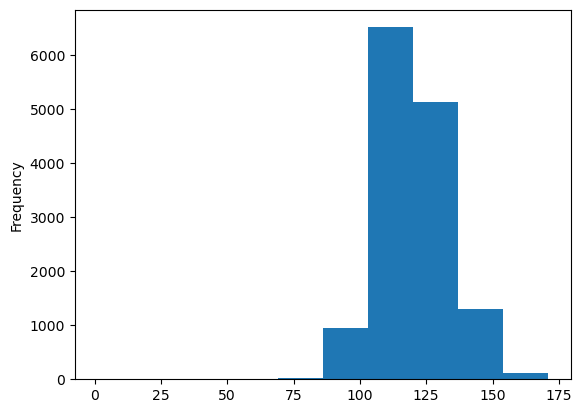

In [349]:
 df_field_MAT['OBS_numValue'].plot.hist()

In [350]:
df_field_MAT = df_field_MAT[df_field_MAT['OBS_numValue']>90]
df_field_MAT.describe()

,FIELD_field_latitude,FIELD_field_longitude,OBS_numValue
count,13901.000000,13901.000000,13901.000000
mean,-18.204880,-51.475868,119.861521
std,6.220222,3.770276,12.551656
min,-30.890795,-62.661190,91.000000
25%,-22.915347,-54.365571,110.000000
50%,-17.807157,-51.899513,118.000000
75%,-13.414896,-47.881372,128.000000
max,-3.063660,-44.206400,171.000000


In [351]:
df_field_MAT.set_index('plot_id', drop=False, inplace=True)

<AxesSubplot:ylabel='Frequency'>

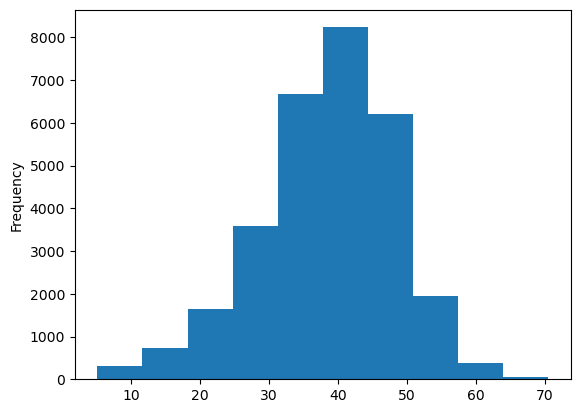

In [352]:
df_field_YLD['OBS_numValue'].plot.hist()

In [353]:
df_field_YLD.describe()

,FIELD_field_latitude,FIELD_field_longitude,OBS_numValue
count,29733.000000,29733.000000,29733.000000
mean,-19.767336,-52.243431,38.485886
std,6.246373,3.242175,9.753063
min,-32.509035,-62.661190,5.100804
25%,-24.706306,-54.707050,32.684971
50%,-20.325269,-52.462569,39.382623
75%,-13.625036,-50.316417,45.273984
max,-3.063660,-44.206400,70.514066


In [354]:
df_field_YLD.set_index('plot_id', drop=False, inplace=True)

## Evaluation DSSAT-CROPGRO phenology model

In [531]:
df = pd.merge(df_field_MAT,
              df_field_YLD['OBS_numValue'],
              left_index=True,
              right_index=True)

df.set_index('FIELD_uniqueName', inplace=True)

In [532]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12578 entries, 16_JD305.0_LAT-26.592_C54A to 22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_NAME             12578 non-null  object             
 1   commercialName         12578 non-null  object             
 2   createdBrand           12547 non-null  object             
 3   createdMG              12578 non-null  object             
 4   protocolNumber         12578 non-null  object             
 5   FIELD_Country          12578 non-null  object             
 6   FIELD_field_latitude   12578 non-null  float64            
 7   FIELD_field_longitude  12578 non-null  float64            
 8   FIELD_plantingDate     12578 non-null  datetime64[ns, UTC]
 9   FIELD_harvestDate      12501 non-null  datetime64[ns, UTC]
 10  OBS_observationRefCd   12578 non-null  object    

In [533]:
df = df.iloc[:, [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 17, 12]]

df.rename(
    columns={"OBS_numValue_x": "MAT", "OBS_numValue_y": "YLD"},
    inplace=True,
)

In [506]:
df = df.iloc[:, [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 17, 12]]
df.columns = [
    'Field_name', 'Commercial_name', 'Brand',
    'rm', 'PN', 'lat', 'lon',
    'Planting_date', 'Harvest_date', 'MAT', 'YLD', 'Plot_id'
]
df['rm'] = df['rm'].astype('float')

In [507]:
df['MG'] = df['rm'].apply(np.round_).astype('int')
df['MAT'] = df['MAT'].astype('int')

In [508]:
df['HARV']= (df['Harvest_date'] - df['Planting_date'])

In [526]:
df

,FIELD_NAME,commercialName,createdBrand,createdMG,protocolNumber,FIELD_field_latitude,FIELD_field_longitude,FIELD_plantingDate,FIELD_harvestDate,MAT,YLD,plot_id
FIELD_uniqueName,,,,,,,,,,,,
16_JD305.0_LAT-26.592_C54A,C54A,DM5958IPRO,DON MARIO,5.9,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,145.0,48.681358,879550280753082
16_JD305.0_LAT-26.592_C54A,C54A,7Z5714C3B0YBN,BAYEREXP,5.7,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,143.0,39.780347,879550280753084
16_JD305.0_LAT-26.592_C54A,C54A,M5892IPRO,MONSOY,5.8,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,145.0,45.988439,879550280753085
16_JD305.0_LAT-26.592_C54A,C54A,M5838IPRO,MONSOY,5.8,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,137.0,45.728324,879550280753086
16_JD305.0_LAT-26.592_C54A,C54A,NA5909RG,NIDERA,5.9,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,134.0,48.959538,879550280753088
...,...,...,...,...,...,...,...,...,...,...,...,...
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A,GLDNL_LRV_PICCINI_ECVOS_S22_M4A,WH7417C1C1DPN,BAYEREXP,7.4,2023-03-A3-01,-13.022933,-55.939954,2022-10-08 00:00:00+00:00,2023-02-04 00:00:00+00:00,115.0,37.466486,879561919273075
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A,GLDNL_LRV_PICCINI_ECVOS_S22_M4A,WH8117B2A1DPN,BAYEREXP,8.1,2023-03-A3-01,-13.022933,-55.939954,2022-10-08 00:00:00+00:00,2023-02-04 00:00:00+00:00,115.0,39.157682,879561919273076
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A,GLDNL_LRV_PICCINI_ECVOS_S22_M4A,BMXBONUSIPRO,BRASMAX,8.1,2023-03-A3-01,-13.022933,-55.939954,2022-10-08 00:00:00+00:00,2023-02-04 00:00:00+00:00,115.0,39.995081,879561919273078


In [ ]:
len(df.Plot_id.unique())

In [ ]:
df['MAT_DSSAT'] = np.nan
df['YLD_DSSAT'] = np.nan
idx_field = df.index
len(idx_field.unique())

In [ ]:
# Defining crop 
crop = Crop('soybean')

In [ ]:
df.info()

In [ ]:
def DSSAT_fields(fld):
    # Field crop level
    print('Processing Field unique name: ' + fld)
    df_field = df[df.index == fld]

    pd = df_field['Planting_date'][0].replace(tzinfo=None)
    hd = df_field['Harvest_date'][0].replace(tzinfo=None)
    lon, lat = df_field['lon'][0], df_field['lat'][0]
    st = (pd - timedelta(days=30)).date()

    # Weather retrieval
    project_loc = 'location360-datasets'

    query_wth = """ 
        DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [({},{})];
        DECLARE u_start_date DATE DEFAULT DATE('{}');
        DECLARE u_end_date DATE DEFAULT DATE('{}');
        DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,day_length,total_downward_solar_radiation,total_net_solar_radiation';
        DECLARE uom STRING DEFAULT 'm';
        CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);
        """.format(lat, lon, st, (hd + timedelta(days=120)).date())

    df_wth = CSWconnect(project_loc, query_wth).load().sort_values(by='date')



    WTH_columns = [
        'date',
        'min_temperature',
        'max_temperature',
        'total_precipitation',
        'total_downward_solar_radiation',
        'avg_relative_humidity',
    ]
    # Create a WeatherData instance
    WTH_DATA = WeatherData(df_wth.loc[:, WTH_columns],
                           variables={
                               'min_temperature': 'TMIN',
                               'max_temperature': 'TMAX',
                               'total_precipitation': 'RAIN',
                               'total_downward_solar_radiation': 'SRAD',
                               'avg_relative_humidity': 'RHUM',
    })

    query_elev = """ 
        WITH twc_cod AS (
          SELECT 
            grid_id, elevation, lat, lon, geohash4, geom 
          FROM 
            historical_weather.twc_cod_grids 
          ),
          point AS (
          SELECT 
            ST_GEOGPOINT({},{}) as pt_geom 
          )
        SELECT 
          elevation, lat, lon 
        FROM 
          twc_cod, point 
        WHERE 
          geohash4 IN (ST_GEOHASH(point.pt_geom, 4))
        ORDER BY 
          ST_DISTANCE(point.pt_geom, twc_cod.geom) LIMIT 1
          """.format(lon, lat)

    elev = CSWconnect(project_loc, query_elev).load()

    # Create a WheaterStation instance
    wth = WeatherStation(WTH_DATA, {
        'ELEV': elev['elevation'][0],
        'LAT': lat,
        'LON': lon,
        'INSI': 'dpoes'
    })

    print('Weather for Field ' + fld + ' was obtained')
    # Soil retrieval
    query_soil = """ 
        WITH hid_h3 AS (
          SELECT 
            `location360-datasets.environmental_data_cube.h3_2_hid`(h3, 10) AS hid_loc, h3
          FROM 
            (Select jslibs.h3.geoToH3({},{}, 10) h3)
        )
        SELECT 
          h3_index_10, clyppt_depth_0cm, clyppt_depth_5cm, clyppt_depth_15cm, clyppt_depth_30cm, clyppt_depth_60cm, clyppt_depth_100cm, 
          sltppt_depth_0cm, sltppt_depth_5cm, sltppt_depth_15cm, sltppt_depth_30cm, sltppt_depth_60cm, sltppt_depth_100cm, 
        FROM 
          `location360-datasets.environmental_data_cube.isric_global_soil_250`, hid_h3
        WHERE 
          hid IN (hid_h3.hid_loc) AND h3_index_10 IN (hid_h3.h3)
            """.format(lat, lon)

    df_soil = CSWconnect(project_loc, query_soil).load()

    # Creating a soil profile instance
    soilprofile = SoilProfile(
        pars={
            'SALB': 0.16,  # Albedo
            'SLU1': 6,  # Stage 1 Evaporation (mm)
            'SLPF': 0.8,  # Soil fertility factor
            'lon': lon,
            'lat': lat,
        })

    layers = [
        SoilLayer(
            0, {
                'SLCL': df_soil['clyppt_depth_0cm'][0],
                'SLSI': df_soil['sltppt_depth_0cm'][0]
            }),
        SoilLayer(
            5, {
                'SLCL': df_soil['clyppt_depth_5cm'][0],
                'SLSI': df_soil['sltppt_depth_5cm'][0]
            }),
        SoilLayer(
            15, {
                'SLCL': df_soil['clyppt_depth_15cm'][0],
                'SLSI': df_soil['sltppt_depth_15cm'][0]
            }),
        SoilLayer(
            30, {
                'SLCL': df_soil['clyppt_depth_30cm'][0],
                'SLSI': df_soil['sltppt_depth_30cm'][0]
            }),
        SoilLayer(
            60, {
                'SLCL': df_soil['clyppt_depth_60cm'][0],
                'SLSI': df_soil['sltppt_depth_60cm'][0]
            }),
        SoilLayer(
            100, {
                'SLCL': df_soil['clyppt_depth_100cm'][0],
                'SLSI': df_soil['sltppt_depth_100cm'][0]
            })
    ]

    for layer in layers:
        soilprofile.add_layer(layer)

    print('Soil profile for Field ' + fld + ' was obtained')
    # Plot cultivar level
    df_field['DSSATcultivar'] = df_field['MG'].apply(
        lambda x: '9900' + f'{x:02d}')
    df_field['CSDL'] = -0.321 * df_field['rm'] + 14.51

    for i in range(len(df_field)):

        try:
            print('Running DSSAT for cultivar ' + df_field['DSSATcultivar'][i])
            # DSSAT simulation
            crop.cultivar[df_field['DSSATcultivar']
                          [i]]['CSDL'] = df_field['CSDL'][i]

            man = Management(cultivar=df_field['DSSATcultivar'][i],
                             planting_date=pd,
                             sim_start=WTH_DATA.index[0],
                             harvest='R',
                             irrigation='N')

            man.simulation_controls['SYMBI'] = 'Y'
            man.simulation_controls['SMODEL'] = 'CRGRO'
            man.simulation_controls['NITRO'] = 'Y'
            man.harvest_details['table']['HDATE'][0] = hd.strftime('%y%j')

            # Dssat run
            dssat = DSSAT()
            dssat.setup(cwd='/tmp/dssatruns')

            dssat.run(
                soil=soilprofile,
                weather=wth,
                crop=crop,
                management=man,
            )

            df_out = dssat.output['PlantGro']
           
            R8 = (df_out[df_out.GSTD == 8].first_valid_index() -
                  pd).days
            YLD_e = df_out['GWAD'].iloc[-1]/100 # qq/ha
            
            print('R8 estimated = ' + str(R8) + ' dap' +
                  '\nR8 observed = ' + str(df_field['MAT'][i]) + ' dap' + 
                  '\nYLD estimated = ' + str(YLD_e) + ' qq/ha' +
                  '\nYLD observed = ' + str(df_field['YLD'][i]) + ' qq/ha')

            df_field['MAT_DSSAT'][i] = R8
            df_field['YLD_DSSAT'][i] = YLD_e

        except Exception as e:
            print(e)
            continue

    dssat.close()
    df.loc[df.index == fld, 'MAT_DSSAT'] = df_field['MAT_DSSAT']
    df.loc[df.index == fld, 'YLD_DSSAT'] = df_field['YLD_DSSAT']

In [ ]:
fields = idx_field.unique()
for field in fields:
    DSSAT_fields(field)

In [ ]:
## Message obtained from GCP
GenericGBQException: Reason: 403 Custom quota exceeded: Your usage exceeded the custom quota for QueryUsagePerUserPerDay, which is set by your administrator. For more information, see https://cloud.google.com/bigquery/cost-controls

Location: US
Job ID: 23e23ddd-540e-4f53-a00c-7be3215386c9

In [ ]:
df.info()

In [ ]:
df_eval = df[df.MAT_DSSAT.notna()]

In [ ]:
df_eval

In [ ]:
df_field_end.info()

In [ ]:
df_eval.to_csv('../data/DSSAT_eval.csv',index=True)

### Graphical analysis

In [ ]:
df_eval =  pd.read_csv('../data/DSSAT_eval_MATcal.csv')
df_eval

In [ ]:
df_eval.Planting_date

In [ ]:
# Predicao
results= list()
pred = df_eval['MAT_DSSAT']
obs = df_eval['MAT']

KGE = kge(pred, obs, return_all=True)
GoF = KGE + [np.sqrt(mean_squared_error(
    pred, obs)), mean_absolute_error(pred, obs)]
results.append(GoF)
# print('>%s %.3f %.3f %.3f' % (i[0], GoF[0], GoF[1], GoF[2]))
# Grafico de dispercao com linha 1:1 e residuos
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
plt.title("Reference vs. Predicted data", fontsize=14)
plt.scatter(obs, pred, s=50, color="gray", edgecolor='k')
ax_min, ax_max = np.floor(min([obs.min(), pred.min()]))-5, np.ceil(max(
    [obs.max(), pred.max()]))+5
plt.axis([ax_min, ax_max, ax_min, ax_max])
plt.text(0.02, 0.72, fontsize=10, s='KGE = ' + str(round(GoF[0], 2)) + '\n' +
         r'$\rho$ = ' + str(round(GoF[1], 2)) + '\n' +
         r'$\gamma$ = ' + str(round(GoF[2], 2)) + '\n' +
         r'$\beta$ = ' + str(round(GoF[3], 2)) + '\n' +
         'RMSE = ' + str(round(GoF[4], 2)) + ' days\n' +
         'MAE = ' + str(round(GoF[5], 2)) + ' days',
         transform=ax1.transAxes)
plt.axline((0, 0), slope=1, linestyle='-',
           color="black", label='Reference line y = x')
m, b = np.polyfit(obs, pred, 1)
plt.plot(obs, m*obs + b, color="r",
         linestyle='dotted', label='Regression line: y = ' + str(round(m, 2)) + 'x + ' + str(round(b, 2)))
plt.xlabel("Reference values")
plt.ylabel("Predict values")
plt.legend(loc="upper left", )

ax2 = fig.add_subplot(1, 2, 2)
# Create the visualizer, fit, score, and show it
plt.title("Residuals plot", fontsize=14)
plt.scatter(pred,pred-obs,s=50, color="gray", edgecolor="k")
plt.axline((0, 0), slope=0, linestyle='-',
           color="black")
m, b = np.polyfit(pred, pred-obs, 1)
plt.plot(obs, m*obs + b, color="r")
plt.xlabel("Predict values")
plt.ylabel("Residuals")

#viz = residuals_plot(i[1], X_train, y_train, X_test, obs)
plt.savefig('../data/MAT_eval_MATcal.png')
plt.show()

In [ ]:
Image(url='../data/YLD_eval.png')



In [ ]:
Image(url='../data/MAT_eval.png')

## Calibration

In [355]:
df = pd.merge(df_field_MAT,
              df_field_YLD['OBS_numValue'],
              left_index=True,
              right_index=True)

df.set_index('FIELD_uniqueName', inplace=True)

In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12578 entries, 16_JD305.0_LAT-26.592_C54A to 22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_NAME             12578 non-null  object             
 1   commercialName         12578 non-null  object             
 2   createdBrand           12547 non-null  object             
 3   createdMG              12578 non-null  object             
 4   protocolNumber         12578 non-null  object             
 5   FIELD_Country          12578 non-null  object             
 6   FIELD_field_latitude   12578 non-null  float64            
 7   FIELD_field_longitude  12578 non-null  float64            
 8   FIELD_plantingDate     12578 non-null  datetime64[ns, UTC]
 9   FIELD_harvestDate      12501 non-null  datetime64[ns, UTC]
 10  OBS_observationRefCd   12578 non-null  object    

In [357]:
df = df.iloc[:, [0, 1, 3, 4, 6, 7, 8, 9, 15, 16, 11, 17, 12]]
df.columns = [
    'Field_name', 'Commercial_name', 'rm', 'PN', 'lat', 'lon', 
    'Planting_date', 'Harvest_date', 'FIELD_mac','FIELD_mic','MAT', 'YLD', 'Plot_id'
]
df['rm'] = df['rm'].astype('float') 

In [358]:
df['MG'] = df['rm'].apply(np.round_).astype('int')
df['MAT'] = df['MAT'].astype('int')


In [359]:
df['HARV']= (df['Harvest_date'] - df['Planting_date']).astype('timedelta64[D]')

In [360]:
df.query("Plot_id == '879552585599442'")

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,FIELD_mac,FIELD_mic,MAT,YLD,Plot_id,MG,HARV
FIELD_uniqueName,,,,,,,,,,,,,,,
17_JD321.0_LAT-8.9523_JM9O,JM9O,WH8113C4B0YBN,8.1,2018-03-A3-01,-8.9523,-46.1463,2017-11-17 00:00:00+00:00,2018-04-07 00:00:00+00:00,5.0,502,109,28.910298,879552585599442,8,141.0


In [361]:
# Removing days wuth MAT > Harvest
df = df[df['MAT'] < df['HARV']]

In [362]:
df['MAT']<df['HARV']

FIELD_uniqueName
16_JD305.0_LAT-26.592_C54A                                True
16_JD305.0_LAT-26.592_C54A                                True
16_JD305.0_LAT-26.592_C54A                                True
16_JD305.0_LAT-26.592_C54A                                True
16_JD331.0_LAT-26.5922_C54B                               True
                                                          ... 
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A    True
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A    True
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A    True
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A    True
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A    True
Length: 10854, dtype: bool

In [363]:
len(df.Plot_id.unique())

10355

In [364]:
df

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,FIELD_mac,FIELD_mic,MAT,YLD,Plot_id,MG,HARV
FIELD_uniqueName,,,,,,,,,,,,,,,
16_JD305.0_LAT-26.592_C54A,C54A,M5838IPRO,5.8,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,1.0,104RSSC,137,45.728324,879550280753086,6,143.0
16_JD305.0_LAT-26.592_C54A,C54A,NA5909RG,5.9,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,1.0,104RSSC,134,48.959538,879550280753088,6,143.0
16_JD305.0_LAT-26.592_C54A,C54A,M5917IPRO,5.9,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,1.0,104RSSC,137,48.903902,879550280753090,6,143.0
16_JD305.0_LAT-26.592_C54A,C54A,AS3590IPRO,5.9,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,1.0,104RSSC,138,46.983382,879550280753091,6,143.0
16_JD331.0_LAT-26.5922_C54B,C54B,M5730IPRO,5.7,2017-03-A3-01,-26.592154,-52.406643,2016-11-26 00:00:00+00:00,2017-04-03 00:00:00+00:00,1.0,104RSSC,125,42.093838,879550280753104,6,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A,GLDNL_LRV_PICCINI_ECVOS_S22_M4A,NEO761I2X,7.6,2023-03-A3-01,-13.022933,-55.939954,2022-10-08 00:00:00+00:00,2023-02-04 00:00:00+00:00,4.0,405,111,36.838984,879561919273068,8,119.0
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A,GLDNL_LRV_PICCINI_ECVOS_S22_M4A,WH7417C1C1DPN,7.4,2023-03-A3-01,-13.022933,-55.939954,2022-10-08 00:00:00+00:00,2023-02-04 00:00:00+00:00,4.0,405,115,37.466486,879561919273075,7,119.0
22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A,GLDNL_LRV_PICCINI_ECVOS_S22_M4A,WH8117B2A1DPN,8.1,2023-03-A3-01,-13.022933,-55.939954,2022-10-08 00:00:00+00:00,2023-02-04 00:00:00+00:00,4.0,405,115,39.157682,879561919273076,8,119.0


In [365]:
# Removing duplicated values
df=df.loc[-df['Plot_id'].duplicated()]

In [40]:
df.FIELD_mac.unique()

array(['3.0', '4.0', '2.0', '5.0', '1.0'], dtype=object)

In [42]:
# Conosur less than 500 plots, it is not necessary sampling
# df = df.sample(frac=1.0).groupby(['MG','FIELD_mac']).head(100)

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10355 entries, 16_JD305.0_LAT-26.592_C54A to 22_JD281.0_LAT-13.0229_GLDNL_LRV_PICCINI_ECVOS_S22_M4A
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Field_name       10355 non-null  object             
 1   Commercial_name  10355 non-null  object             
 2   rm               10355 non-null  float64            
 3   PN               10355 non-null  object             
 4   lat              10355 non-null  float64            
 5   lon              10355 non-null  float64            
 6   Planting_date    10355 non-null  datetime64[ns, UTC]
 7   Harvest_date     10355 non-null  datetime64[ns, UTC]
 8   FIELD_mac        10355 non-null  object             
 9   FIELD_mic        10355 non-null  object             
 10  MAT              10355 non-null  int64              
 11  YLD              10355 non-null  float64            
 12  Plot_

In [367]:
df['R1_DSSAT'] = np.nan
df['R2_DSSAT'] = np.nan
df['R3_DSSAT'] = np.nan
df['R5_DSSAT'] = np.nan
df['R7_DSSAT'] = np.nan
df['R8_DSSAT'] = np.nan
df['YLD_DSSAT'] = np.nan
df['pars_DSSAT'] = np.nan
df['AE_defPars'] = np.nan
df['AE_calPars'] = np.nan
df['pars_DSSAT']= df.pars_DSSAT.astype('object')
idx_field = df.index
len(idx_field.unique())

841

In [418]:
crop = Crop('Soybean')

In [419]:
## Creating bounds
bounds = [
    (crop.cultivar['999991']['EM-FL'], crop.cultivar['999992']['EM-FL']),
    (crop.cultivar['999991']['FL-SH'], crop.cultivar['999992']['FL-SH']),
    (crop.cultivar['999991']['FL-SD'], crop.cultivar['999992']['FL-SD']),
    (crop.cultivar['999991']['SD-PM'], crop.cultivar['999992']['SD-PM']),
]
bounds

[(9.0, 28.9), (5.0, 10.0), (11.0, 22.0), (22.0, 37.7)]

In [420]:
aws_access_key_id=os.environ['aws_key']
aws_secret_access_key=os.environ['aws_secret']
aws_region='us-east-2'
#fld = '21_JD323.0_LAT-32.509_JSOUZ4_FIELD15_JAGUARAO_QUEROQUERO_COXILHA_ECVOS'

In [421]:
con = duckdb.connect()
con.execute(f"""
            INSTALL httpfs;
            LOAD httpfs;
            SET s3_region='us-east-2';
            SET s3_access_key_id='{aws_access_key_id}';
            SET s3_secret_access_key='{aws_secret_access_key}';
            SET threads TO 20;
            """)


In [426]:
def DSSAT_CalPlots(fld):
    try:

        # Field crop level
        print('Processing Field unique name: ' + fld)
        df_field = df[df.index == fld]

        pd = df_field['Planting_date'][0].replace(tzinfo=None)
        hd = df_field['Harvest_date'][0].replace(tzinfo=None)
        lon, lat = df_field['lon'][0], df_field['lat'][0]
        st = (pd - timedelta(days=30)).date()

        # Weather retrieval
        
        query_TWC = f"""
        SELECT 
            *
        FROM 
            read_parquet('s3://s3-latam-gmd-coe/WEATHER/TWC_brazil_soybeans.parquet')
        WHERE
            lat = '{lat}' AND lon = '{lon}' AND date >= '{st.strftime('%Y-%m-%d')}' AND date <= '{end.strftime('%Y-%m-%d')}' 

        """
        
        df_wth = con.execute(query_TWC).df()      
        df_wth['DOY'] = df_wth['date'].apply(lambda x: int(x.strftime('%j')))

        # Incident solar radiation (Rs_in)
        rad = np.pi/180  # Radians to degrees
        gra = 180/np.pi  # Degrees to radians

        Ko = 37.63*(1+(0.033*(np.cos(rad*((360*df_wth['DOY'])/365)))))
        ds = 23.45*np.sin(rad*(360*(df_wth['DOY']-80)/365))
        hn = (np.arccos(-np.tan(rad*df_wth['lat'][0])*np.tan(rad*ds)))*gra
        Qo = Ko*(rad*hn*np.sin(rad*df_wth['lat'][0])*np.sin(rad*ds) +
                 np.cos(rad*df_wth['lat'][0])*np.cos(rad*ds)*np.sin(rad*hn))

        df_wth['Rs_in'] = 0.16*Qo * \
            ((df_wth['max_temperature'])-(df_wth['min_temperature']))**0.5

        WTH_columns = [
            'date',
            'min_temperature',
            'max_temperature',
            'total_precipitation',
            'Rs_in',
            'avg_relative_humidity',
        ]
        # Create a WeatherData instance
        WTH_DATA = WeatherData(df_wth.loc[:, WTH_columns],
                               variables={
                                   'min_temperature': 'TMIN',
                                   'max_temperature': 'TMAX',
                                   'total_precipitation': 'RAIN',
                                   'Rs_in': 'SRAD',
                                   'avg_relative_humidity': 'RHUM',
        })

        query_elev =f"""
        SELECT 
            elevation 
        FROM 
            read_parquet('s3://s3-latam-gmd-coe/FIELDS/FIELD_brazil_soybeans.parquet')
        WHERE
            FIELD_field_latitude = {lat} AND FIELD_field_longitude = {lon}
        """

        elev = con.execute(query_elevation).df().squeeze()

        # Create a WheaterStation instance
        wth = WeatherStation(WTH_DATA, {
            'ELEV': elev,
            'LAT': lat,
            'LON': lon,
            'INSI': 'dpoes'
        })

        print('Weather for Field ' + fld + ' was obtained')
        # Soil retrieval
        query_soil = f"""
        SELECT 
            *
        FROM 
            read_parquet('s3://s3-latam-gmd-coe/SOIL/ISRIC_V2_brazil_soybeans.parquet')
        WHERE
            h3_index_10 = '{h3.geo_to_h3(lat=lat, lng=lon, resolution=10)}'
        """

        df_soil = con.execute(query_soil).df()
        # Creating a soil profile instance
        soilprofile = SoilProfile(
            pars={
                'SALB': 0.16,  # Albedo
                'SLU1': 6,  # Stage 1 Evaporation (mm)
                'SLPF': 0.8,  # Soil fertility factor
                'lon': lon,
                'lat': lat,
            })

        layers = [
            SoilLayer(
                0, {
                    'SLCL': df_soil['clyppt_depth_0cm'][0],
                    'SLSI': df_soil['sltppt_depth_0cm'][0]
                }),
            SoilLayer(
                5, {
                    'SLCL': df_soil['clyppt_depth_5cm'][0],
                    'SLSI': df_soil['sltppt_depth_5cm'][0]
                }),
            SoilLayer(
                15, {
                    'SLCL': df_soil['clyppt_depth_15cm'][0],
                    'SLSI': df_soil['sltppt_depth_15cm'][0]
                }),
            SoilLayer(
                30, {
                    'SLCL': df_soil['clyppt_depth_30cm'][0],
                    'SLSI': df_soil['sltppt_depth_30cm'][0]
                }),
            SoilLayer(
                60, {
                    'SLCL': df_soil['clyppt_depth_60cm'][0],
                    'SLSI': df_soil['sltppt_depth_60cm'][0]
                }),
            SoilLayer(
                100, {
                    'SLCL': df_soil['clyppt_depth_100cm'][0],
                    'SLSI': df_soil['sltppt_depth_100cm'][0]
                })
        ]

        for layer in layers:
            soilprofile.add_layer(layer)

        print('Soil profile for Field ' + fld + ' was obtained')
        # Plot cultivar level
        df_field['DSSATcultivar'] = df_field['MG'].apply(
            lambda x: '9900' + f'{x:02d}')
        df_field['CSDL'] = -0.321 * df_field['rm'] + 14.51

        pars_name = ['EM-FL', 'FL-SH', 'FL-SD', 'SD-PM']

        for i in range(len(df_field)):

            try:
                print('Running DSSAT for cultivar ' +
                      df_field['DSSATcultivar'][i])
                # DSSAT simulation
                pars = [
                    crop.cultivar[df_field['DSSATcultivar'][i]].get(par)
                    for par in pars_name
                ]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['CSDL'] = df_field['CSDL'][i]

                man = Management(cultivar=df_field['DSSATcultivar'][i],
                                 planting_date=pd,
                                 sim_start=WTH_DATA.index[0],
                                 harvest='R',
                                 irrigation='N')

                man.simulation_controls['SYMBI'] = 'Y'
                man.simulation_controls['SMODEL'] = 'CRGRO'
                man.simulation_controls['NITRO'] = 'Y'
                man.harvest_details['table']['HDATE'][0] = hd.strftime('%y%j')

                obs = df_field['MAT'][i]
                # DSSAT calibration
                print('Calibrating DSSAT for cultivar ' +
                      df_field['DSSATcultivar'][i])

                # DSSAT run
                dssat = DSSAT()
                dssat.setup()

                dssat.run(
                    soil=soilprofile,
                    weather=wth,
                    crop=crop,
                    management=man,
                )

                df_out = dssat.output['PlantGro']
                YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                # Fixing the error of 'None' value when R8 is not computed
                MAT_day = df_out[df_out.GSTD == 8].first_valid_index()
                MAT_day = df_out[df_out.GSTD == 3].first_valid_index(
                ) if MAT_day is None else MAT_day

                MAT_e = (MAT_day - pd).days

                AE_def = abs(obs - MAT_e)

                print('Absolute error defaut parameters = ' + str(AE_def))

                # Objective function
                def DSSAT_obj(pars):

                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['EM-FL'] = pars[0]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['FL-SH'] = pars[1]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['FL-SD'] = pars[2]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['SD-PM'] = pars[3]

                    dssat.run(
                        soil=soilprofile,
                        weather=wth,
                        crop=crop,
                        management=man,
                    )

                    df_out = dssat.output['PlantGro']
                    YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                    MAT_day = df_out[df_out.GSTD == 8].first_valid_index()
                    MAT_day = df_out[df_out.GSTD == 3].first_valid_index(
                    ) if MAT_day is None else MAT_day

                    MAT_e = (MAT_day - pd).days

                    print('Absolute error = ' + str(abs(obs - MAT_e)) +
                          '\nField unique name = ' + str(fld) + '\nPlot ID = ' +
                          str(df_field['Plot_id'][i]))

                    return abs(obs - MAT_e)

                DSSAT_cal = gp_minimize(
                    func=DSSAT_obj,
                    dimensions=bounds,
                    acq_func='EI',
                    xi=3,
                    initial_point_generator='lhs',
                    acq_optimizer='sampling'
                )

                idx_func = np.where(
                    DSSAT_cal['func_vals'] == DSSAT_cal['func_vals'].min())[0].tolist()
                AE_cal = DSSAT_cal['func_vals'][idx_func[0]]
                pars_cal = [DSSAT_cal['x_iters'][index] for index in idx_func]

                # round parameters
                pars_cal = [[np.round(float(i), 2) for i in nested]
                            for nested in pars_cal]
                print(pars_cal)

                df_field.iat[i, df_field.columns.get_loc(
                    'pars_DSSAT')] = pars_cal
                df_field['AE_defPars'][i] = AE_def
                df_field['AE_calPars'][i] = AE_cal

                # Updating with the calibrated parameters
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['EM-FL'] = pars_cal[0][0]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['FL-SH'] = pars_cal[0][1]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['FL-SD'] = pars_cal[0][2]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['SD-PM'] = pars_cal[0][3]

                # DSSAT re-run with calibrated parameters
                dssat.run(
                    soil=soilprofile,
                    weather=wth,
                    crop=crop,
                    management=man,
                )

                df_out = dssat.output['PlantGro']

                R1 = (df_out[df_out.GSTD == 1].first_valid_index() - pd).days
                R2 = (df_out[df_out.GSTD == 2].first_valid_index() - pd).days
                R3 = (df_out[df_out.GSTD == 3].first_valid_index() - pd).days
                R5 = (df_out[df_out.GSTD == 5].first_valid_index() - pd).days
                R7 = (df_out[df_out.GSTD == 7].first_valid_index() - pd).days
                R8 = (df_out[df_out.GSTD == 8].first_valid_index() - pd).days
                YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                print('R1 estimated = ' + str(R1) + ' dap\n' +
                      'R2 estimated = ' + str(R2) + ' dap\n' +
                      'R3 estimated = ' + str(R3) + ' dap\n' +
                      'R5 estimated = ' + str(R5) + ' dap\n' +
                      'R7 estimated = ' + str(R7) + ' dap\n' +
                      'R8 estimated = ' + str(R8) + ' dap' + '\nR8 observed = ' +
                      str(df_field['MAT'][i]) + ' dap' + '\nYLD estimated = ' +
                      str(YLD_e) + ' qq/ha' + '\nYLD observed = ' +
                      str(df_field['YLD'][i]) + ' qq/ha')

                df_field['R1_DSSAT'][i] = R1
                df_field['R2_DSSAT'][i] = R2
                df_field['R3_DSSAT'][i] = R3
                df_field['R5_DSSAT'][i] = R5
                df_field['R7_DSSAT'][i] = R7
                df_field['R8_DSSAT'][i] = R8
                df_field['YLD_DSSAT'][i] = YLD_e

                dssat.close()

            except Exception as e:
                print(e)
                continue

    except Exception as e:
        print(e)

    # This part does not work in parallel
    '''
    df.loc[df.index == fld, 'R1_DSSAT'] = df_field['R1_DSSAT']
    df.loc[df.index == fld, 'R2_DSSAT'] = df_field['R2_DSSAT']
    df.loc[df.index == fld, 'R3_DSSAT'] = df_field['R3_DSSAT']
    df.loc[df.index == fld, 'R5_DSSAT'] = df_field['R5_DSSAT']
    df.loc[df.index == fld, 'R7_DSSAT'] = df_field['R7_DSSAT']
    df.loc[df.index == fld, 'R8_DSSAT'] = df_field['R8_DSSAT']
    df.loc[df.index == fld, 'YLD_DSSAT'] = df_field['YLD_DSSAT']
    df.loc[df.index == fld, 'pars_DSSAT'] = df_field['pars_DSSAT']
    df.loc[df.index == fld, 'AE_defPars'] = df_field['AE_defPars']
    df.loc[df.index == fld, 'AE_calPars'] = df_field['AE_calPars']
    '''
    return df_field

In [423]:
fields = df.index.unique()

In [424]:
fields

Index(['16_JD305.0_LAT-26.592_C54A', '16_JD331.0_LAT-26.5922_C54B',
       '16_JD316.0_LAT-27.4516_0005', '16_JD305.0_LAT-27.721_ST3E',
       '16_JD305.0_LAT-27.5411_ST3T', '16_JD322.0_LAT-28.3023_ST3C',
       '16_JD313.0_LAT-18.8766_X51C', '16_JD336.0_LAT-19.6669_X51D',
       '16_JD303.0_LAT-18.8766_X51E', '16_JD298.0_LAT-15.3568_STP1',
       ...
       '22_JD279.0_LAT-19.2688_LLBIAN1_UDI_RODOLFOGRACIA_ECVOS_S22_A',
       '22_JD271.0_LAT-12.1859_JJMARC2_SRS_INGAI_ECVOS_B4B_S22_01',
       '22_JD278.0_LAT-21.6539_GNEKH_RIOBRILHANTE_CEVANDRO_ECVOS_S22',
       '22_JD279.0_LAT-13.4825_MCSTEI1_SAPEZAL_PALUDO_ECVOS_S22_M4B',
       '22_JD281.0_LAT-13.0224_GLDNL_LRV_PICCINI_ECVOS_S22_M4B',
       '22_JD292.0_LAT-15.6492_DDFERR2_CVERD_ROVERSI_ECVOS_S22_P',
       '22_JD286.0_LAT-13.3419_MCSTEI1_CNP_VARNIER_ECVOS_S22_M4P',
       '22_JD285.0_LAT-15.3974_DDFERR2_PVA_MARUMBI_ECVOS_S22_P',
       '22_JD286.0_LAT-15.3974_DDFERR2_PVA_MARUMBI_ECVOS_S22_A',
       '22_JD281.0_LAT-13.0229_GLDNL_

In [402]:
fields = df_DSSAT_pars_run2.index.unique()
len(fields)

NameError: name 'df_DSSAT_pars_run2' is not defined

In [ ]:
for field in fields:
    DSSAT_CalPlots(field)

In [427]:
DSSAT_CalPlots(fields[0])

Processing Field unique name: 16_JD305.0_LAT-26.592_C54A
Weather for Field 16_JD305.0_LAT-26.592_C54A was obtained
Soil profile for Field 16_JD305.0_LAT-26.592_C54A was obtained
Running DSSAT for cultivar 990006
Calibrating DSSAT for cultivar 990006
/tmp/dssatkquzzlgq created.
Static files copied to /tmp/dssatkquzzlgq.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  46 129  6989  3996   958     0   629   129    80    17  11179  112
Absolute error defaut parameters = 4
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  33 114  4532  2412   958     0   614   131    67    27  11177  112
Absolute error = 11
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON T

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  52 131  7084  3982   958     0   630   128    81    16  11179  112
Absolute error = 6
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  32 108  3929  2105   958     0   607   130    61    32  11175  112
Absolute error = 17
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  59 137  8057  4170   958     0   635   122    85    12  11178  112
Absolute error = 60
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT 

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  55 127  7321  4081   958     0   627   130    81    17  11180  112
Absolute error = 2
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  61 126  7330  3929   958     0   625   130    81    17  11181  112
Absolute error = 1
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  61 116  6403  3084   958     0   609   132    73    24  11181  112
Absolute error = 9
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FL

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  31 123  4288  2423   958     0   620   130    67    26  11175  112
Absolute error = 2
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  61 122  6837  3601   958     0   619   131    76    21  11180  112
Absolute error = 3
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  38 120  5392  2920   958     0   618   131    70    25  11178  112
Absolute error = 5
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
RUN    TRT FL

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  60 118  6622  3343   958     0   613   132    74    23  11180  112
Absolute error = 7
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753086
[[19.54, 9.89, 15.28, 33.68], [20.34, 6.65, 11.31, 36.85], [18.54, 6.4, 15.34, 34.53], [15.16, 9.4, 18.54, 34.32], [23.67, 9.46, 18.68, 25.61], [28.9, 5.37, 16.84, 23.32], [9.05, 5.11, 21.25, 37.32], [16.79, 9.77, 16.75, 34.15], [28.51, 5.13, 11.04, 30.24], [25.81, 5.07, 17.2, 25.2], [28.84, 5.22, 15.16, 25.4], [26.87, 5.29, 13.13, 28.97]]
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  44 125  6730  3872   958     0   626   130    78    20  11180  112
R1 estimated = 44 dap
R2 estimated = 66 dap
R3 estimated = 69 dap
R5 estimated = 76 dap
R7 e

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  24 102  2660  1370   958     0   591   128    54    37  11171  112
Absolute error = 20
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  59 132  7864  3366   958     0   631   127    85    13  11181  112
Absolute error = 48
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  43 134  7161  3684   958     0   634   126    82    15  11179  112
Absolute error = 67
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  51 123  6679  3843   958     0   620   131    76    21  11180  112
Absolute error = 1
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  35 121  5344  2230   958     0   622   131    70    25  11178  112
Absolute error = 1
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  43 121  6162  3038   958     0   618   131    73    23  11179  112
Absolute error = 1
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FL

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 120  5378  3128   958     0   622   130    70    25  11178  112
Absolute error = 2
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  24 120  3037  1625   958     0   602   129    65    28  11171  112
Absolute error = 2
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  33 119  4980  2959   958     0   625   129    69    26  11177  112
Absolute error = 3
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088
RUN    TRT FL

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  62 128  7486  4053   958     0   628   129    81    16  11180  112
Absolute error = 6
Field unique name = 16_JD305.0_LAT-26.592_C54A
Plot ID = 879550280753088


KeyboardInterrupt: 

In [361]:
%debug

> /opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py(1424)_validate_key()
   1422             # check that the key does not exceed the maximum size of the index
   1423             if len(arr) and (arr.max() >= len_axis or arr.min() < -len_axis):
-> 1424                 raise IndexError("positional indexers are out-of-bounds")
   1425         else:
   1426             raise ValueError(f"Can only index by location with a [{self._valid_types}]")

ipdb> s


In [50]:
os.cpu_count()

32

In [51]:
workers=28

In [52]:
n_flds=len(fields)
n_flds

606

In [ ]:
chunks = ceil(n_flds/workers)
chunks

In [57]:
df

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,FIELD_mac,FIELD_mic,...,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,
17_JD321.0_LAT-13.6553_JE8E,JE8E,M6410IPRO,6.4,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19_JD324.0_LAT-6.8357_IMART_FIELD1_SAMBAIBA_OMASSAO_1MD05,IMART_FIELD1_SAMBAIBA_OMASSAO_1MD05,TMG2185IPRO,8.5,2020-03-A3-01,-6.835655,-45.414624,2019-11-20 00:00:00+00:00,2020-04-05 00:00:00+00:00,5.0,502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19_JD276.0_LAT-22.4296_HMATH_FIELD24_MARACAJU_SILVA_2MD21,HMATH_FIELD24_MARACAJU_SILVA_2MD21,AS3707I2X,7.0,2020-03-A3-01,-22.429620,-55.542431,2019-10-03 00:00:00+00:00,2020-02-14 00:00:00+00:00,2.0,206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_JD314.0_LAT-28.336_IISCHU1_STOANTONIO_KRAEMMER_ECVOS_S21_B,IISCHU1_STOANTONIO_KRAEMMER_ECVOS_S21_B,BMXTROVAOI2X,5.1,2022-03-A3-01,-28.336008,-52.774869,2021-11-10 00:00:00+00:00,2022-04-02 00:00:00+00:00,1.0,103Baixo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16_JD285.0_LAT-22.4612_V78Q,V78Q,M5947IPRO,5.9,2017-03-A3-01,-22.461200,-50.242600,2016-10-11 00:00:00+00:00,2017-02-24 00:00:00+00:00,2.0,203Baixo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18_JD278.0_LAT-13.9729_LCEG_CNP_FZ.SAOJUDAS_GER4P,LCEG_CNP_FZ.SAOJUDAS_GER4P,AS3590IPRO,5.9,2019-03-A3-01,-13.972926,-58.000082,2018-10-05 00:00:00+00:00,2019-01-24 00:00:00+00:00,4.0,406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_JD293.0_LAT-18.5871_FSAN_FIELD2_CHC_SCHLATTER_M3VER,FSAN_FIELD2_CHC_SCHLATTER_M3VER,AS3680IPROVERANGO,6.8,2021-03-93-09,-18.587071,-52.529292,2020-10-19 00:00:00+00:00,2021-03-03 00:00:00+00:00,3.0,401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_JD329.0_LAT-11.7034_HZAN_FIELD25_RIACHAO_M5,HZAN_FIELD25_RIACHAO_M5,M8349IPRO,8.3,2021-03-93-08,-11.703395,-45.527137,2020-11-24 00:00:00+00:00,2021-04-11 00:00:00+00:00,5.0,408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#!pip install p_tqdm

In [ ]:
with Pool(28) as pool:
    results= pool.map(DSSAT_CalPlots, fields)
    

Processing Field unique name: 16_JD293.0_LAT-13.4337_JD3JProcessing Field unique name: 20_JD305.0_LAT-17.8657_ARIB_FIELD1_RIOVERDE_EXPERT_M3TProcessing Field unique name: 18_JD285.0_LAT-21.5198_LBIA_ALFENAS_TERRAPRETA_OTT3PXProcessing Field unique name: 19_JD335.0_LAT-11.449_HZAN_FIELD1_RIACHAODASNEVES_MANJABOSCO_1MD5Processing Field unique name: 17_JD329.0_LAT-18.7434_ECVOS_CHICÃOProcessing Field unique name: 19_JD269.0_LAT-24.3903_HMATH_FIELD17_MAMBORE_MENIN_2MD21Processing Field unique name: 17_JD329.0_LAT-18.3917_X51CProcessing Field unique name: 17_JD283.0_LAT-18.4555_KK7BProcessing Field unique name: 17_JD285.0_LAT-13.9523_KO2IProcessing Field unique name: 18_JD290.0_LAT-17.9463_AMAR_JATAI_BALSAMO1_OTT3TX
Processing Field unique name: 17_JD327.0_LAT-8.3806_JM9MProcessing Field unique name: 16_JD271.0_LAT-23.0257_V78BProcessing Field unique name: 16_JD349.0_LAT-6.8554_JM9C
Processing Field unique name: 19_JD317.0_LAT-28.3301_MSTE_FIELD2_SAOLUIZGONZAGA_EP1_PICOLI_2MD21Processing Fi

In [70]:
results_conosur

[                            Field_name Commercial_name   rm             PN  \
 FIELD_uniqueName                                                             
 17_JD321.0_LAT-13.6553_JE8E       JE8E       M6410IPRO  6.4  2018-03-A3-01   
 17_JD321.0_LAT-13.6553_JE8E       JE8E       M6972IPRO  6.9  2018-03-A3-01   
 17_JD321.0_LAT-13.6553_JE8E       JE8E       M7110IPRO  6.8  2018-03-A3-01   
 17_JD321.0_LAT-13.6553_JE8E       JE8E       M7198IPRO  7.1  2018-03-A3-01   
 17_JD321.0_LAT-13.6553_JE8E       JE8E      AS3680IPRO  6.8  2018-03-A3-01   
 
                                    lat        lon             Planting_date  \
 FIELD_uniqueName                                                              
 17_JD321.0_LAT-13.6553_JE8E -13.655341 -46.165184 2017-11-17 00:00:00+00:00   
 17_JD321.0_LAT-13.6553_JE8E -13.655341 -46.165184 2017-11-17 00:00:00+00:00   
 17_JD321.0_LAT-13.6553_JE8E -13.655341 -46.165184 2017-11-17 00:00:00+00:00   
 17_JD321.0_LAT-13.6553_JE8E -13.655341 -46.1

In [71]:
df_DSSAT_pars_run = pd.concat(results_conosur)
df_DSSAT_pars_run

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,FIELD_mac,FIELD_mic,...,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars,DSSATcultivar,CSDL
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,
17_JD321.0_LAT-13.6553_JE8E,JE8E,M6410IPRO,6.4,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,47.0,63.0,93.0,105.0,11.10,"[[16.82, 7.32, 21.64, 22.56], [9.17, 7.21, 15....",12.0,0.0,990006,12.4556
17_JD321.0_LAT-13.6553_JE8E,JE8E,M6972IPRO,6.9,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,54.0,59.0,92.0,104.0,23.19,"[[23.33, 6.48, 11.03, 22.08], [23.75, 9.43, 11...",23.0,0.0,990007,12.2951
17_JD321.0_LAT-13.6553_JE8E,JE8E,M7110IPRO,6.8,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,48.0,59.0,93.0,105.0,19.33,"[[20.14, 5.25, 14.02, 23.52], [9.17, 5.13, 15....",2.0,0.0,990007,12.3272
17_JD321.0_LAT-13.6553_JE8E,JE8E,M7198IPRO,7.1,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,39.0,51.0,95.0,107.0,9.69,"[[10.65, 6.71, 16.33, 28.73], [16.96, 5.82, 16...",2.0,0.0,990007,12.2309
17_JD321.0_LAT-13.6553_JE8E,JE8E,AS3680IPRO,6.8,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,51.0,60.0,92.0,104.0,21.06,"[[22.48, 5.07, 12.74, 22.0], [23.56, 9.98, 11....",0.0,0.0,990007,12.3272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20_JD324.0_LAT-12.4783_HZAN_FIELD33_SAODESIDERIO_M5,HZAN_FIELD33_SAODESIDERIO_M5,AS3850IPRO,8.5,2021-03-93-08,-12.478264,-45.371990,2020-11-19 00:00:00+00:00,2021-04-15 00:00:00+00:00,5.0,408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19_JD312.0_LAT-16.578_JPER_FIELD1_UNAI_ANTERIO_PA1EP_1MD3,JPER_FIELD1_UNAI_ANTERIO_PA1EP_1MD3,AS3615I2X,5.9,2020-03-A3-01,-16.578038,-47.112730,2019-11-08 00:00:00+00:00,2020-03-09 00:00:00+00:00,3.0,303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_JD316.0_LAT-12.8475_DYIDA_SD_7POVOS_ECVOSMULTI_S21_1EP,DYIDA_SD_7POVOS_ECVOSMULTI_S21_1EP,M8644IPRO,8.6,2022-03-A3-02,-12.847476,-46.170410,2021-11-12 00:00:00+00:00,2022-04-09 00:00:00+00:00,5.0,408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
df_DSSAT_pars_run1 = df_DSSAT_pars_run[df_DSSAT_pars_run.R8_DSSAT.notna()]
df_DSSAT_pars_run1


,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,FIELD_mac,FIELD_mic,...,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars,DSSATcultivar,CSDL
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,
17_JD321.0_LAT-13.6553_JE8E,JE8E,M6410IPRO,6.4,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,47.0,63.0,93.0,105.0,11.10,"[[16.82, 7.32, 21.64, 22.56], [9.17, 7.21, 15....",12.0,0.0,990006,12.4556
17_JD321.0_LAT-13.6553_JE8E,JE8E,M6972IPRO,6.9,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,54.0,59.0,92.0,104.0,23.19,"[[23.33, 6.48, 11.03, 22.08], [23.75, 9.43, 11...",23.0,0.0,990007,12.2951
17_JD321.0_LAT-13.6553_JE8E,JE8E,M7110IPRO,6.8,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,48.0,59.0,93.0,105.0,19.33,"[[20.14, 5.25, 14.02, 23.52], [9.17, 5.13, 15....",2.0,0.0,990007,12.3272
17_JD321.0_LAT-13.6553_JE8E,JE8E,M7198IPRO,7.1,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,39.0,51.0,95.0,107.0,9.69,"[[10.65, 6.71, 16.33, 28.73], [16.96, 5.82, 16...",2.0,0.0,990007,12.2309
17_JD321.0_LAT-13.6553_JE8E,JE8E,AS3680IPRO,6.8,2018-03-A3-01,-13.655341,-46.165184,2017-11-17 00:00:00+00:00,2018-04-27 00:00:00+00:00,5.0,408,...,51.0,60.0,92.0,104.0,21.06,"[[22.48, 5.07, 12.74, 22.0], [23.56, 9.98, 11....",0.0,0.0,990007,12.3272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19_JD284.0_LAT-22.0765_HMATH_FIELD30_ITAPORA_TOZZI_1MD02,HMATH_FIELD30_ITAPORA_TOZZI_1MD02,M6210IPRO,7.0,2020-03-A3-01,-22.076536,-54.927421,2019-10-11 00:00:00+00:00,2020-03-17 00:00:00+00:00,2.0,202,...,46.0,48.0,108.0,120.0,7.87,"[[13.31, 9.56, 11.06, 29.89], [9.01, 5.98, 21....",3.0,0.0,990007,12.2630
21_JD324.0_LAT-26.5925_CCZANI1_ABELARDOLUZ_LUDWIG_ECVOSN_S21,CCZANI1_ABELARDOLUZ_LUDWIG_ECVOSN_S21,DM53I54RSFIPRO,5.4,2022-03-A3-01,-26.592471,-52.403073,2021-11-20 00:00:00+00:00,2022-04-21 00:00:00+00:00,1.0,104RSSC,...,80.0,94.0,136.0,148.0,29.04,"[[28.7, 9.56, 21.25, 37.53], [28.25, 7.38, 21....",27.0,0.0,990005,12.7766
21_JD324.0_LAT-26.5925_CCZANI1_ABELARDOLUZ_LUDWIG_ECVOSN_S21,CCZANI1_ABELARDOLUZ_LUDWIG_ECVOSN_S21,BMXTROVAOI2X,5.1,2022-03-A3-01,-26.592471,-52.403073,2021-11-20 00:00:00+00:00,2022-04-21 00:00:00+00:00,1.0,104RSSC,...,77.0,92.0,133.0,145.0,28.91,"[[28.76, 8.96, 21.89, 37.28], [28.84, 7.94, 21...",3.0,1.0,990005,12.8729


In [170]:
df_DSSAT_pars_run1 = pd.concat(results)
df_DSSAT_pars_run1 = df_DSSAT_pars_run1[df_DSSAT_pars_run1.R8_DSSAT.notna()]
df_DSSAT_pars_run1

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,MAT,YLD,...,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars,DSSATcultivar,CSDL
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,
17_JD341.0_LAT-11.8347_JE8M,JE8M,MY8314D3B0YBN,8.3,2018-03-A3-01,-11.834723,-46.292602,2017-12-07 00:00:00+00:00,2018-04-27 00:00:00+00:00,118,40.433052,...,57.0,59.0,106.0,118.0,31.14,"[[19.17, 9.74, 11.12, 29.91], [18.24, 9.79, 18...",19.0,0.0,990008,11.8457
17_JD341.0_LAT-11.8347_JE8M,JE8M,WH8113C4B0YBN,8.1,2018-03-A3-01,-11.834723,-46.292602,2017-12-07 00:00:00+00:00,2018-04-27 00:00:00+00:00,118,47.673647,...,56.0,62.0,107.0,119.0,30.82,"[[19.77, 8.82, 13.15, 29.31], [16.78, 9.49, 21...",3.0,0.0,990008,11.9099
17_JD341.0_LAT-11.8347_JE8M,JE8M,WH8614C1B0YBN,8.6,2018-03-A3-01,-11.834723,-46.292602,2017-12-07 00:00:00+00:00,2018-04-27 00:00:00+00:00,126,39.159481,...,53.0,54.0,114.0,126.0,30.56,"[[14.24, 9.84, 11.0, 36.35], [20.31, 9.5, 16.4...",56.0,0.0,990009,11.7494
21_JD300.0_LAT-16.8302_SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,MY8414F2B1DNN,8.4,2022-03-A3-02,-16.830221,-53.826724,2021-10-27 00:00:00+00:00,2022-03-04 00:00:00+00:00,126,44.567711,...,48.0,66.0,114.0,126.0,11.85,"[[12.7, 5.95, 15.35, 22.44], [13.53, 6.05, 11....",60.0,0.0,990008,11.8136
21_JD300.0_LAT-16.8302_SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,M8130I2X,8.1,2022-03-A3-02,-16.830221,-53.826724,2021-10-27 00:00:00+00:00,2022-03-04 00:00:00+00:00,117,49.262197,...,48.0,58.0,105.0,117.0,10.98,"[[12.78, 8.06, 13.77, 22.19], [10.74, 8.45, 15...",3.0,0.0,990008,11.9099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16_JD305.0_LAT-23.2358_V78S,V78S,M5705IPRO,5.7,2017-03-A3-01,-23.235800,-50.344300,2016-10-31 00:00:00+00:00,2017-03-14 00:00:00+00:00,105,48.577572,...,50.0,59.0,93.0,105.0,16.81,"[[19.38, 6.93, 13.98, 22.09], [15.4, 7.13, 13....",6.0,0.0,990006,12.6803
16_JD305.0_LAT-23.2358_V78S,V78S,M5917IPRO,5.9,2017-03-A3-01,-23.235800,-50.344300,2016-10-31 00:00:00+00:00,2017-03-14 00:00:00+00:00,115,44.445318,...,63.0,69.0,103.0,115.0,28.23,"[[28.86, 6.37, 11.21, 22.56], [28.87, 9.51, 11...",8.0,0.0,990006,12.6161
19_JD327.0_LAT-28.4209_MSTE_FIELD1_SAOMIGUELDASMISSOES_VIEIRA_1MD02,MSTE_FIELD1_SAOMIGUELDASMISSOES_VIEIRA_1MD02,BMXFIBRAIPRO,6.3,2020-03-A3-01,-28.420863,-54.578812,2019-11-23 00:00:00+00:00,2020-03-30 00:00:00+00:00,119,28.028844,...,53.0,61.0,107.0,119.0,14.82,"[[13.71, 5.97, 11.46, 37.46], [9.05, 5.89, 21....",7.0,0.0,990006,12.4877


In [379]:
df_DSSAT_pars_run2 = pd.concat(results_conosur)

In [380]:
df_DSSAT_pars_run2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 15_JD292.0_LAT-24.3997_SPJ4 to 21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Field_name       306 non-null    object             
 1   Commercial_name  306 non-null    object             
 2   rm               306 non-null    float64            
 3   PN               306 non-null    object             
 4   lat              306 non-null    float64            
 5   lon              306 non-null    float64            
 6   Planting_date    306 non-null    datetime64[ns, UTC]
 7   Harvest_date     306 non-null    datetime64[ns, UTC]
 8   MAT              306 non-null    int64              
 9   YLD              306 non-null    float64            
 10  Plot_id          306 non-null    float64            
 11  MG               306 non-null    int64              
 12  HARV 

In [381]:
df_DSSAT_pars_run2 = df_DSSAT_pars_run2[df_DSSAT_pars_run2.R8_DSSAT.notna()]
df_DSSAT_pars_run2

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,MAT,YLD,...,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars,DSSATcultivar,CSDL
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,
15_JD292.0_LAT-24.3997_SPJ4,SPJ4,5714IPRO,5.7,2016-05-A3-01,-24.399670,-55.001820,2015-10-19 00:00:00+00:00,2016-02-29 00:00:00+00:00,108,28.445872,...,40.0,60.0,96.0,108.0,8.73,"[[14.27, 6.09, 21.93, 22.18], [14.85, 5.92, 21...",4.0,0.0,990006,12.6803
15_JD292.0_LAT-24.3997_SPJ4,SPJ4,6211IPRO,6.1,2016-05-A3-01,-24.399670,-55.001820,2015-10-19 00:00:00+00:00,2016-02-29 00:00:00+00:00,110,29.093770,...,43.0,46.0,98.0,110.0,16.14,"[[15.96, 9.41, 11.39, 29.68], [18.9, 8.79, 11....",3.0,0.0,990006,12.5519
15_JD292.0_LAT-24.3997_SPJ4,SPJ4,M5947IPRO,5.9,2016-05-A3-01,-24.399670,-55.001820,2015-10-19 00:00:00+00:00,2016-02-29 00:00:00+00:00,116,28.818668,...,55.0,67.0,104.0,116.0,21.74,"[[25.61, 6.23, 15.36, 24.31], [28.89, 5.5, 11....",9.0,0.0,990006,12.6161
15_JD292.0_LAT-24.3997_SPJ4,SPJ4,DM5958IPRO,5.9,2016-05-A3-01,-24.399670,-55.001820,2015-10-19 00:00:00+00:00,2016-02-29 00:00:00+00:00,113,30.277457,...,53.0,62.0,101.0,113.0,23.43,"[[25.89, 5.83, 12.23, 24.66], [9.07, 9.94, 16....",3.0,0.0,990006,12.6161
15_JD292.0_LAT-24.3997_SPJ4,SPJ4,DM6262IPRORSF,6.2,2016-05-A3-01,-24.399670,-55.001820,2015-10-19 00:00:00+00:00,2016-02-29 00:00:00+00:00,116,26.633555,...,33.0,50.0,104.0,116.0,8.99,"[[9.68, 5.42, 18.49, 30.59], [13.02, 9.85, 20....",1.0,0.0,990006,12.5198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,M6100XTD,6.2,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,121,21.096756,...,53.0,72.0,109.0,121.0,7.00,"[[17.69, 8.68, 19.4, 23.17], [25.79, 9.6, 12.5...",3.0,0.0,990006,12.5198
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,DM62R63,6.3,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,126,25.757132,...,68.0,73.0,114.0,126.0,7.08,"[[27.08, 8.74, 11.08, 24.95], [25.42, 6.97, 12...",3.0,0.0,990006,12.4877
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,BMXGARRAIPRO,6.3,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,123,23.205986,...,49.0,63.0,111.0,123.0,8.42,"[[18.89, 6.1, 14.36, 30.68], [13.83, 7.14, 21....",3.0,0.0,990006,12.4877


In [382]:
df_DSSAT_pars = pd.concat([df_DSSAT_pars_run1,df_DSSAT_pars_run2])

In [383]:
df_DSSAT_pars.columns

Index(['Field_name', 'Commercial_name', 'rm', 'PN', 'lat', 'lon',
       'Planting_date', 'Harvest_date', 'MAT', 'YLD', 'Plot_id', 'MG', 'HARV',
       'R1_DSSAT', 'R2_DSSAT', 'R3_DSSAT', 'R5_DSSAT', 'R7_DSSAT', 'R8_DSSAT',
       'YLD_DSSAT', 'pars_DSSAT', 'AE_defPars', 'AE_calPars', 'DSSATcultivar',
       'CSDL'],
      dtype='object')

In [384]:
df_DSSAT_pars.drop(['MG', 'YLD_DSSAT', 'AE_defPars',
                    'AE_calPars', 'CSDL'], axis=1, inplace=True)

In [385]:
df_DSSAT_pars = df_DSSAT_pars.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 11, 18, 19]]


In [386]:
df_DSSAT_pars

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,MAT,YLD,Plot_id,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,HARV,pars_DSSAT,DSSATcultivar
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,
15_JD273.0_LAT-25.3307_SPC9,SPC9,5714IPRO,5.7,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,111,37.346036,111.0,19.0,28.0,33.0,44.0,99.0,111.0,130.0,"[[9.87, 6.54, 16.28, 32.22], [9.08, 5.6, 13.77...",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,6211IPRO,6.1,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,114,38.360094,114.0,27.0,42.0,45.0,53.0,102.0,114.0,130.0,"[[16.04, 9.27, 14.96, 26.24], [24.49, 6.16, 11...",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,M5947IPRO,5.9,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,121,41.129885,121.0,43.0,60.0,61.0,65.0,109.0,121.0,130.0,"[[27.87, 9.45, 11.83, 24.92], [13.91, 7.05, 19...",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,DM5958IPRO,5.9,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,113,37.316777,113.0,30.0,44.0,48.0,61.0,101.0,113.0,130.0,"[[18.68, 8.31, 17.94, 22.14], [10.01, 9.7, 11....",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,DM6262IPRORSF,6.2,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,117,40.691803,117.0,27.0,41.0,43.0,48.0,105.0,117.0,130.0,"[[16.0, 8.35, 12.64, 30.18], [13.1, 7.26, 13.7...",990006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,M6100XTD,6.2,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,121,21.096756,121.0,30.0,46.0,53.0,72.0,109.0,121.0,128.0,"[[17.69, 8.68, 19.4, 23.17], [25.79, 9.6, 12.5...",990006
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,DM62R63,6.3,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,126,25.757132,126.0,46.0,66.0,68.0,73.0,114.0,126.0,128.0,"[[27.08, 8.74, 11.08, 24.95], [25.42, 6.97, 12...",990006
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,BMXGARRAIPRO,6.3,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,123,23.205986,123.0,32.0,44.0,49.0,63.0,111.0,123.0,128.0,"[[18.89, 6.1, 14.36, 30.68], [13.83, 7.14, 21....",990006


In [387]:
df_DSSAT_pars.columns= ['FIELD_NAME', 'commercialName', 'createdMG', 'protocolNumber', 'FIELD_field_latitude',
                       'FIELD_field_longitude', 'FIELD_plantingDate', 'FIELD_harvestDate', 'MAT', 'YLD', 'plot_id',
                       'R1_DSSAT', 'R2_DSSAT', 'R3_DSSAT', 'R5_DSSAT', 'R7_DSSAT', 'R8_DSSAT', 'HARV', 'pars_DSSAT',
                       'cultivar_DSSAT']

In [388]:
df_DSSAT_pars

,FIELD_NAME,commercialName,createdMG,protocolNumber,FIELD_field_latitude,FIELD_field_longitude,FIELD_plantingDate,FIELD_harvestDate,MAT,YLD,plot_id,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,HARV,pars_DSSAT,cultivar_DSSAT
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,
15_JD273.0_LAT-25.3307_SPC9,SPC9,5714IPRO,5.7,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,111,37.346036,111.0,19.0,28.0,33.0,44.0,99.0,111.0,130.0,"[[9.87, 6.54, 16.28, 32.22], [9.08, 5.6, 13.77...",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,6211IPRO,6.1,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,114,38.360094,114.0,27.0,42.0,45.0,53.0,102.0,114.0,130.0,"[[16.04, 9.27, 14.96, 26.24], [24.49, 6.16, 11...",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,M5947IPRO,5.9,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,121,41.129885,121.0,43.0,60.0,61.0,65.0,109.0,121.0,130.0,"[[27.87, 9.45, 11.83, 24.92], [13.91, 7.05, 19...",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,DM5958IPRO,5.9,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,113,37.316777,113.0,30.0,44.0,48.0,61.0,101.0,113.0,130.0,"[[18.68, 8.31, 17.94, 22.14], [10.01, 9.7, 11....",990006
15_JD273.0_LAT-25.3307_SPC9,SPC9,DM6262IPRORSF,6.2,2016-05-A3-01,-25.330710,-55.684020,2015-09-30 00:00:00+00:00,2016-02-07 00:00:00+00:00,117,40.691803,117.0,27.0,41.0,43.0,48.0,105.0,117.0,130.0,"[[16.0, 8.35, 12.64, 30.18], [13.1, 7.26, 13.7...",990006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,M6100XTD,6.2,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,121,21.096756,121.0,30.0,46.0,53.0,72.0,109.0,121.0,128.0,"[[17.69, 8.68, 19.4, 23.17], [25.79, 9.6, 12.5...",990006
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,DM62R63,6.3,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,126,25.757132,126.0,46.0,66.0,68.0,73.0,114.0,126.0,128.0,"[[27.08, 8.74, 11.08, 24.95], [25.42, 6.97, 12...",990006
21_JD293.0_LAT-24.2398_LLCONT2_LAPALOMA_RENATOALMEIDA_E,LLCONT2_LAPALOMA_RENATOALMEIDA_E,BMXGARRAIPRO,6.3,2022-70-A3-01,-24.239777,-54.491093,2021-10-20 00:00:00+00:00,2022-02-25 00:00:00+00:00,123,23.205986,123.0,32.0,44.0,49.0,63.0,111.0,123.0,128.0,"[[18.89, 6.1, 14.36, 30.68], [13.83, 7.14, 21....",990006


In [389]:
DSSAT_Conosur_soybeans = df_DSSAT_pars.reset_index()



In [ ]:
DSSAT_Conosur_soybeans.info()

In [391]:
DSSAT_Conosur_soybeans[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                       'protocolNumber', 'plot_id', 'pars_DSSAT', 'cultivar_DSSAT']] = \
    DSSAT_Conosur_soybeans[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                           'protocolNumber', 'plot_id', 'pars_DSSAT', 'cultivar_DSSAT']].astype('string')

In [392]:
CSWconnect(project_md).save(DSSAT_Conosur_soybeans, 'latam_datasets.dssat_conosur_soybeans', append=False)

In [84]:
query_DSSAT = """
SELECT 
    *
FROM
    latam_datasets.dssat_conosur_soybeans_back    
"""
df_DSSAT_pars = CSWconnect(project_md).load(query_DSSAT)




In [87]:
df_DSSAT_pars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_uniqueName       505 non-null    object             
 1   FIELD_NAME             505 non-null    object             
 2   commercialName         505 non-null    object             
 3   createdMG              505 non-null    float64            
 4   protocolNumber         505 non-null    object             
 5   FIELD_field_latitude   505 non-null    float64            
 6   FIELD_field_longitude  505 non-null    float64            
 7   FIELD_plantingDate     505 non-null    datetime64[ns, UTC]
 8   FIELD_harvestDate      505 non-null    datetime64[ns, UTC]
 9   MAT                    505 non-null    int64              
 10  YLD                    505 non-null    float64            
 11  plot_id                505 non-null    object             

In [88]:
df_DSSAT_pars[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                       'protocolNumber', 'plot_id', 'pars_DSSAT', 'cultivar_DSSAT']] = \
    df_DSSAT_pars[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                           'protocolNumber', 'plot_id', 'pars_DSSAT', 'cultivar_DSSAT']].astype('string')

In [89]:
CSWconnect(project_md).save(df_DSSAT_pars, 'latam_datasets.dssat_conosur_soybeans')

In [276]:
df_DSSAT_pars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_uniqueName       505 non-null    object             
 1   FIELD_NAME             505 non-null    object             
 2   commercialName         505 non-null    object             
 3   createdMG              505 non-null    float64            
 4   protocolNumber         505 non-null    object             
 5   FIELD_field_latitude   505 non-null    float64            
 6   FIELD_field_longitude  505 non-null    float64            
 7   FIELD_plantingDate     505 non-null    datetime64[ns, UTC]
 8   FIELD_harvestDate      505 non-null    datetime64[ns, UTC]
 9   MAT                    505 non-null    int64              
 10  YLD                    505 non-null    float64            
 11  plot_id                505 non-null    object             

In [ ]:
with Pool(processes=4) as pool:
    progress_bar = tqdm(total=4)
    print("mapping...")
    tqdm(pool.map(DSSAT_CalPlots, fields[0:3]), total=4)
    print("running...")
    print("done")

In [139]:
df

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,MAT,YLD,...,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,
17_JD341.0_LAT-11.8347_JE8M,JE8M,MY8314D3B0YBN,8.3,2018-03-A3-01,-11.834723,-46.292602,2017-12-07 00:00:00+00:00,2018-04-27 00:00:00+00:00,118,40.433052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_JD300.0_LAT-16.8302_SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,MY8414F2B1DNN,8.4,2022-03-A3-02,-16.830221,-53.826724,2021-10-27 00:00:00+00:00,2022-03-04 00:00:00+00:00,126,44.567711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_JD308.0_LAT-15.6098_JPER_FIELD7A_PLANALTINA_3PINHEIROS_M3MULTI,JPER_FIELD7A_PLANALTINA_3PINHEIROS_M3MULTI,M7601I2X,7.6,2021-03-93-01,-15.609777,-47.503021,2020-11-03 00:00:00+00:00,2021-03-13 00:00:00+00:00,128,33.609889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18_JD301.0_LAT-13.5862_LCEG_CNP_FZ.VOARNOLDO_GER4M,LCEG_CNP_FZ.VOARNOLDO_GER4M,WH8213A8C1DPN,8.2,2019-03-A3-01,-13.586209,-57.829965,2018-10-28 00:00:00+00:00,2019-03-04 00:00:00+00:00,115,26.519075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17_JD286.0_LAT-23.0257_V78-RIBEIROCOM-ANDIRÁ-PR,V78-RIBEIROCOM-ANDIRÁ-PR,FY6715G4B0YBN,6.7,2018-03-A3-01,-23.025654,-50.254081,2017-10-13 00:00:00+00:00,2018-02-25 00:00:00+00:00,123,48.624188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21_JD314.0_LAT-28.336_IISCHU1_STOANTONIO_KRAEMMER_ECVOS_S21_B,IISCHU1_STOANTONIO_KRAEMMER_ECVOS_S21_B,CORDIUS2531E,5.3,2022-03-A3-01,-28.336008,-52.774869,2021-11-10 00:00:00+00:00,2022-04-02 00:00:00+00:00,130,32.797755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18_JD294.0_LAT-24.2255_JGAL_MAMBORE_SPILKA_GER12,JGAL_MAMBORE_SPILKA_GER12,DM53I54RSFIPRO,5.4,2019-03-A3-01,-24.225502,-52.546787,2018-10-21 00:00:00+00:00,2019-03-01 00:00:00+00:00,123,40.674451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_JD270.0_LAT-27.4859_CCZANI1_CAMPOSNOVOS_CHIOCCA_ECVOSP_S21,CCZANI1_CAMPOSNOVOS_CHIOCCA_ECVOSP_S21,BMXTROVAOI2X,5.1,2022-03-A3-01,-27.485919,-51.351970,2021-09-27 00:00:00+00:00,2022-03-01 00:00:00+00:00,144,23.780677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df_eval = df[df.R8_DSSAT.notna()]

In [137]:
df_eval

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,MAT,YLD,...,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,


In [ ]:
df_eval.to_csv('../data/DSSAT_eval_MATcal.csv',index=True)

### APP to automate in Domino

In [4]:
# Imports
import sys
import pandas as pd
import numpy as np
import DSSATTools
import h3
#from WaterBalance import CSWconnect
import duckdb
from skopt import gp_minimize
from multiprocessing import Pool

In [5]:
# Get data
def getFields() -> pd.DataFrame:
   
    query_hss = """
    SELECT 
      FIELD_NAME, commercialName, createdBrand, createdMG, protocolNumber, FIELD_Country, FIELD_field_latitude,
      FIELD_field_longitude, FIELD_plantingDate, FIELD_harvestDate, OBS_observationRefCd, OBS_numValue,  
      plot_id, QC_Flag, field_id, FIELD_mac, FIELD_mic, FIELD_uniqueName
    FROM 
      latam_datasets.hss_brazil_current_soybeans 
    WHERE 
      OBS_observationRefCd in ('YLD','MAT')
    UNION ALL
    SELECT 
      FIELD_NAME, commercialName, createdBrand, createdMG, protocolNumber, FIELD_Country, FIELD_field_latitude,
      FIELD_field_longitude, FIELD_plantingDate, FIELD_harvestDate, OBS_observationRefCd, OBS_numValue,  
      plot_id, QC_Flag, field_id, FIELD_mac, FIELD_mic, FIELD_uniqueName
    FROM 
      latam_datasets.hss_brazil_historical_soybeans 
    WHERE 
      OBS_observationRefCd in ('YLD','MAT')
    """

    return CSWconnect('bcs-market-dev-lake').load(query_hss)

In [6]:
# Transform data
def transFields(df_hss: pd.DataFrame) -> pd.DataFrame:

    df1_field = df_hss[df_hss['createdMG'].notnull()]
    df2_field = df1_field[df1_field['QC_Flag'].isnull()]

    df_field_MAT = df2_field[df2_field['OBS_observationRefCd'] == 'MAT']
    df_field_YLD = df2_field[df2_field['OBS_observationRefCd'] == 'YLD']

    # QC maturity date
    df_field_MAT = df_field_MAT[df_field_MAT['OBS_numValue'] > 90]

    df_field_MAT.set_index('plot_id', drop=False, inplace=True)
    df_field_YLD.set_index('plot_id', drop=False, inplace=True)

    df = pd.merge(df_field_MAT,
                  df_field_YLD['OBS_numValue'],
                  left_index=True,
                  right_index=True)

    df.set_index('FIELD_uniqueName', inplace=True)

    df = df.iloc[:, [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 17, 12]]

    df.rename(
        columns={"OBS_numValue_x": "MAT", "OBS_numValue_y": "YLD"},
        inplace=True,
    )

    df['createdMG'] = df['createdMG'].astype('float')
    df['MG'] = df['createdMG'].apply(np.round_).astype('int')
    df['MAT'] = df['MAT'].astype('int')

    df['HARV'] = (df['FIELD_harvestDate'] -
                  df['FIELD_plantingDate']).astype('timedelta64[D]')

    # Correcting when MAT > Harvest
    df['HARV'][df['MAT'] > df['HARV']] = df['MAT']

    # Removing duplicated values, YM cases
    df = df.loc[-df['plot_id'].duplicated()]

    df['R1_DSSAT'] = np.nan
    df['R2_DSSAT'] = np.nan
    df['R3_DSSAT'] = np.nan
    df['R5_DSSAT'] = np.nan
    df['R7_DSSAT'] = np.nan
    df['R8_DSSAT'] = np.nan
    df['YLD_DSSAT'] = np.nan
    df['pars_DSSAT'] = np.nan
    df['AE_defPars'] = np.nan
    df['AE_calPars'] = np.nan
    df['pars_DSSAT'] = df.pars_DSSAT.astype('object')

    return df

In [7]:
# Run calibration
def DSSAT_CalPlots(fld):
    try:

        # Field crop level
        print('Processing Field unique name: ' + fld)
        df_field = df[df.index == fld]

        pd = df_field['FIELD_plantingDate'][0].replace(tzinfo=None)
        hd = df_field['FIELD_harvestDate'][0].replace(tzinfo=None)
        lon, lat = df_field['FIELD_field_longitude'][0], df_field['FIELD_field_latitude'][0]
        st = (pd - timedelta(days=30)).date()
        
        # Weather retrieval
        
        query_TWC = f"""
        SELECT 
            *
        FROM 
            read_parquet('s3://s3-latam-gmd-coe/WEATHER/TWC_brazil_soybeans.parquet')
        WHERE
            lat = '{lat}' AND lon = '{lon}' AND date >= '{st.strftime('%Y-%m-%d')}' AND date <= '{hd.strftime('%Y-%m-%d')}' 

        """
        
        df_wth = con.execute(query_TWC).df()      
        df_wth['DOY'] = df_wth['date'].apply(lambda x: int(x.strftime('%j')))

        # Incident solar radiation (Rs_in)
        rad = np.pi/180  # Radians to degrees
        gra = 180/np.pi  # Degrees to radians

        Ko = 37.63*(1+(0.033*(np.cos(rad*((360*df_wth['DOY'])/365)))))
        ds = 23.45*np.sin(rad*(360*(df_wth['DOY']-80)/365))
        hn = (np.arccos(-np.tan(rad*df_wth['lat'][0])*np.tan(rad*ds)))*gra
        Qo = Ko*(rad*hn*np.sin(rad*df_wth['lat'][0])*np.sin(rad*ds) +
                 np.cos(rad*df_wth['lat'][0])*np.cos(rad*ds)*np.sin(rad*hn))

        df_wth['Rs_in'] = 0.16*Qo * \
            ((df_wth['max_temperature'])-(df_wth['min_temperature']))**0.5

        WTH_columns = [
            'date',
            'min_temperature',
            'max_temperature',
            'total_precipitation',
            'Rs_in',
            'avg_relative_humidity',
        ]
        # Create a WeatherData instance
        WTH_DATA = WeatherData(df_wth.loc[:, WTH_columns],
                               variables={
                                   'min_temperature': 'TMIN',
                                   'max_temperature': 'TMAX',
                                   'total_precipitation': 'RAIN',
                                   'Rs_in': 'SRAD',
                                   'avg_relative_humidity': 'RHUM',
        })

        query_elev =f"""
        SELECT 
            elevation 
        FROM 
            read_parquet('s3://s3-latam-gmd-coe/FIELDS/FIELD_brazil_soybeans.parquet')
        WHERE
            FIELD_field_latitude = {lat} AND FIELD_field_longitude = {lon}
        """

        elev = con.execute(query_elev).df().squeeze()

        # Create a WheaterStation instance
        wth = WeatherStation(WTH_DATA, {
            'ELEV': elev,
            'LAT': lat,
            'LON': lon,
            'INSI': 'dpoes'
        })

        print('Weather for Field ' + fld + ' was obtained')
        
        # Soil retrieval
        query_soil = f"""
        SELECT 
            *
        FROM 
            read_parquet('s3://s3-latam-gmd-coe/SOIL/ISRIC_brazil_soybeans.parquet')
        WHERE
            h3_index_10 = '{h3.geo_to_h3(lat=lat, lng=lon, resolution=10)}'
        """

        df_soil = con.execute(query_soil).df()
        # Creating a soil profile instance
        soilprofile = SoilProfile(
            pars={
                'SALB': 0.16,  # Albedo
                'SLU1': 6,  # Stage 1 Evaporation (mm)
                'SLPF': 0.8,  # Soil fertility factor
                'lon': lon,
                'lat': lat,
            })

        layers = [
            SoilLayer(
                0, {
                    'SLCL': df_soil['clyppt_depth_0cm'][0],
                    'SLSI': df_soil['sltppt_depth_0cm'][0]
                }),
            SoilLayer(
                5, {
                    'SLCL': df_soil['clyppt_depth_5cm'][0],
                    'SLSI': df_soil['sltppt_depth_5cm'][0]
                }),
            SoilLayer(
                15, {
                    'SLCL': df_soil['clyppt_depth_15cm'][0],
                    'SLSI': df_soil['sltppt_depth_15cm'][0]
                }),
            SoilLayer(
                30, {
                    'SLCL': df_soil['clyppt_depth_30cm'][0],
                    'SLSI': df_soil['sltppt_depth_30cm'][0]
                }),
            SoilLayer(
                60, {
                    'SLCL': df_soil['clyppt_depth_60cm'][0],
                    'SLSI': df_soil['sltppt_depth_60cm'][0]
                }),
            SoilLayer(
                100, {
                    'SLCL': df_soil['clyppt_depth_100cm'][0],
                    'SLSI': df_soil['sltppt_depth_100cm'][0]
                })
        ]

        for layer in layers:
            soilprofile.add_layer(layer)

        print('Soil profile for Field ' + fld + ' was obtained')
        # Plot cultivar level
        df_field['DSSATcultivar'] = df_field['MG'].apply(
            lambda x: '9900' + f'{x:02d}')
        df_field['CSDL'] = -0.321 * df_field['createdMG'] + 14.51

        pars_name = ['EM-FL', 'FL-SH', 'FL-SD', 'SD-PM']

        for i in range(len(df_field)):

            try:
                print('Running DSSAT for cultivar ' +
                      df_field['DSSATcultivar'][i])
                # DSSAT simulation
                pars = [
                    crop.cultivar[df_field['DSSATcultivar'][i]].get(par)
                    for par in pars_name
                ]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['CSDL'] = df_field['CSDL'][i]

                man = Management(cultivar=df_field['DSSATcultivar'][i],
                                 planting_date=pd,
                                 sim_start=WTH_DATA.index[0],
                                 harvest='R',
                                 irrigation='N')

                man.simulation_controls['SYMBI'] = 'Y'
                man.simulation_controls['SMODEL'] = 'CRGRO'
                man.simulation_controls['NITRO'] = 'Y'
                man.harvest_details['table']['HDATE'][0] = hd.strftime('%y%j')

                obs = df_field['MAT'][i]
                # DSSAT calibration
                print('Calibrating DSSAT for cultivar ' +
                      df_field['DSSATcultivar'][i])

                # DSSAT run
                dssat = DSSAT()
                dssat.setup()

                dssat.run(
                    soil=soilprofile,
                    weather=wth,
                    crop=crop,
                    management=man,
                )

                df_out = dssat.output['PlantGro']
                YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                # Fixing the error of 'None' value when R8 is not computed
                MAT_day = df_out[df_out.GSTD == 8].first_valid_index()
                MAT_day = df_out[df_out.GSTD == 3].first_valid_index(
                ) if MAT_day is None else MAT_day

                MAT_e = (MAT_day - pd).days

                AE_def = abs(obs - MAT_e)

                print('Absolute error defaut parameters = ' + str(AE_def))

                # Objective function
                def DSSAT_obj(pars):

                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['EM-FL'] = pars[0]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['FL-SH'] = pars[1]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['FL-SD'] = pars[2]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['SD-PM'] = pars[3]

                    dssat.run(
                        soil=soilprofile,
                        weather=wth,
                        crop=crop,
                        management=man,
                    )

                    df_out = dssat.output['PlantGro']
                    YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                    MAT_day = df_out[df_out.GSTD == 8].first_valid_index()
                    MAT_day = df_out[df_out.GSTD == 3].first_valid_index(
                    ) if MAT_day is None else MAT_day

                    MAT_e = (MAT_day - pd).days

                    print('Absolute error = ' + str(abs(obs - MAT_e)) +
                          '\nField unique name = ' + str(fld) + '\nPlot ID = ' +
                          str(df_field['plot_id'][i]))

                    return abs(obs - MAT_e)

                DSSAT_cal = gp_minimize(
                    func=DSSAT_obj,
                    dimensions=bounds,
                    acq_func='EI',
                    xi=3,
                    initial_point_generator='lhs',
                    acq_optimizer='sampling'
                )

                idx_func = np.where(
                    DSSAT_cal['func_vals'] == DSSAT_cal['func_vals'].min())[0].tolist()
                AE_cal = DSSAT_cal['func_vals'][idx_func[0]]
                pars_cal = [DSSAT_cal['x_iters'][index] for index in idx_func]

                # round parameters
                pars_cal = [[np.round(float(i), 2) for i in nested]
                            for nested in pars_cal]
                print(pars_cal)

                df_field.iat[i, df_field.columns.get_loc(
                    'pars_DSSAT')] = pars_cal
                df_field['AE_defPars'][i] = AE_def
                df_field['AE_calPars'][i] = AE_cal

                # Updating with the calibrated parameters
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['EM-FL'] = pars_cal[0][0]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['FL-SH'] = pars_cal[0][1]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['FL-SD'] = pars_cal[0][2]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['SD-PM'] = pars_cal[0][3]

                # DSSAT re-run with calibrated parameters
                dssat.run(
                    soil=soilprofile,
                    weather=wth,
                    crop=crop,
                    management=man,
                )

                df_out = dssat.output['PlantGro']

                R1 = (df_out[df_out.GSTD == 1].first_valid_index() - pd).days
                R2 = (df_out[df_out.GSTD == 2].first_valid_index() - pd).days
                R3 = (df_out[df_out.GSTD == 3].first_valid_index() - pd).days
                R5 = (df_out[df_out.GSTD == 5].first_valid_index() - pd).days
                R7 = (df_out[df_out.GSTD == 7].first_valid_index() - pd).days
                R8 = (df_out[df_out.GSTD == 8].first_valid_index() - pd).days
                YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                print('R1 estimated = ' + str(R1) + ' dap\n' +
                      'R2 estimated = ' + str(R2) + ' dap\n' +
                      'R3 estimated = ' + str(R3) + ' dap\n' +
                      'R5 estimated = ' + str(R5) + ' dap\n' +
                      'R7 estimated = ' + str(R7) + ' dap\n' +
                      'R8 estimated = ' + str(R8) + ' dap' + '\nR8 observed = ' +
                      str(df_field['MAT'][i]) + ' dap' + '\nYLD estimated = ' +
                      str(YLD_e) + ' qq/ha' + '\nYLD observed = ' +
                      str(df_field['YLD'][i]) + ' qq/ha')

                df_field['R1_DSSAT'][i] = R1
                df_field['R2_DSSAT'][i] = R2
                df_field['R3_DSSAT'][i] = R3
                df_field['R5_DSSAT'][i] = R5
                df_field['R7_DSSAT'][i] = R7
                df_field['R8_DSSAT'][i] = R8
                df_field['YLD_DSSAT'][i] = YLD_e

                dssat.close()

            except Exception as e:
                print(e)
                continue

    except Exception as e:
        print(e)
    
    return df_field

In [41]:
# Load
def loadDSSATpars(calibration: list, crop: str, regn: str) -> None: 
    
    df_cal = pd.concat(calibration)
    df_cal = df_cal[df_cal.R8_DSSAT.notna()]

    df_cal.drop(['MG', 'YLD_DSSAT', 'AE_defPars',
                    'AE_calPars', 'CSDL'], axis=1, inplace=True)

    df_cal = df_cal.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 12, 19, 20]]
    df_cal = df_cal.reset_index()

    df_cal[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                       'protocolNumber', 'plot_id', 'pars_DSSAT', 'DSSATcultivar']] = \
    df_cal[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                           'protocolNumber', 'plot_id', 'pars_DSSAT', 'DSSATcultivar']].astype('string')

    CSWconnect('bcs-market-dev-lake').save(df_cal, f'latam_datasets.dssat_{regn}_{crop}', append=True)

In [ ]:
if __name__ == '__main__':

    job = sys.argv[1]
    n_hard = sys.argv[2]
    crop = Crop('Soybean')

## Creating bounds
bounds = [
    (crop.cultivar['999991']['EM-FL'], crop.cultivar['999992']['EM-FL']),
    (crop.cultivar['999991']['FL-SH'], crop.cultivar['999992']['FL-SH']),
    (crop.cultivar['999991']['FL-SD'], crop.cultivar['999992']['FL-SD']),
    (crop.cultivar['999991']['SD-PM'], crop.cultivar['999992']['SD-PM']),
]

aws_access_key_id=os.environ['aws_key']
aws_secret_access_key=os.environ['aws_secret']
aws_region='us-east-2'

con = duckdb.connect()
con.execute(f"""
            INSTALL httpfs;
            LOAD httpfs;
            SET s3_region='us-east-2';
            SET s3_access_key_id='{aws_access_key_id}';
            SET s3_secret_access_key='{aws_secret_access_key}';
            SET threads TO 20;
            """)


df_hss = getFields()

df = transFields(df_hss)

In [57]:
fields = df.index.unique()
n_cores = 25

In [58]:
n_fields=len(fields)
n_fields

864

In [76]:
n_hard = np.ceil(n_fields/25)
n_hard

35.0

In [68]:
os.environ['NHARD'] = str(n_hard)

In [69]:
os.environ['NHARD']

'34.0'

In [77]:
25*35

875

In [60]:
# Horizontal scaling for n hardwares
fields_hard = np.array_split(fields, n_hard)
fields_hard

[Index(['16_JD305.0_LAT-26.592_C54A', '16_JD331.0_LAT-26.5922_C54B',
        '16_JD316.0_LAT-27.4516_0005', '16_JD305.0_LAT-27.721_ST3E',
        '16_JD305.0_LAT-27.5411_ST3T', '16_JD322.0_LAT-28.3023_ST3C',
        '16_JD313.0_LAT-18.8766_X51C', '16_JD336.0_LAT-19.6669_X51D',
        '16_JD303.0_LAT-18.8766_X51E', '16_JD298.0_LAT-15.3568_STP1',
        '16_JD293.0_LAT-15.3386_STP2', '16_JD292.0_LAT-16.8315_GJ4F',
        '16_JD318.0_LAT-28.2746_ST4M', '16_JD317.0_LAT-28.3265_ST4L',
        '16_JD329.0_LAT-25.447_GH0J', '16_JD291.0_LAT-18.9223_B35D',
        '16_JD295.0_LAT-17.84_X31G', '16_JD322.0_LAT-20.1894_CP4C',
        '16_JD305.0_LAT-17.2504_X31C', '16_JD288.0_LAT-17.6161_C14L',
        '16_JD308.0_LAT-18.2865_C14M', '16_JD315.0_LAT-16.7222_C14H',
        '16_JD303.0_LAT-17.8547_C14O', '16_JD292.0_LAT-17.8137_C14N',
        '16_JD324.0_LAT-11.2982_JE8U', '16_JD321.0_LAT-13.4292_JE8H'],
       dtype='object', name='FIELD_uniqueName'),
 Index(['16_JD271.0_LAT-23.0257_V78B', '16_JD

In [ ]:
with Pool(25) as pool:
    calibration = pool.map(DSSAT_CalPlots, fields_hard[n_job])

In [8]:
loadDSSATpars(calibration, 'soybeans', 'brazil')

In [72]:
## Domino runs 
from domino import Domino


domino = Domino(
    "Field_Trialing_LATAM/FieldTrialing_Latam",
    api_key=os.environ["DOMINO_USER_API_KEY"],
    host=os.environ["DOMINO_API_HOST"],
)

n_jobs = 35
for i in range(0, n_jobs):
    domino_run = domino.runs_start(
        ["/mnt/code/WaterBalance/DSSATcal.py", str(i), str(n_jobs)], title="Scalling DSSAT calibration"
)

run_status = domino.runs_status(domino_run.get("runId"))

print(run_status)

34.0

In [64]:
domino_run = domino.runs_start(
    ["python", "-c", "print('teste')"], title="Testing job callable"
)
run_status = domino.runs_status(domino_run.get("runId"))

In [62]:
print(run_status)

{'id': '6400cf98ef9b7a29a75f7366', 'projectId': '61ae4449f7cecf452b62e9c5', 'number': 10719, 'startingUserId': '631f2855f48f7f33892de7ae', 'queued': 1677774744616, 'started': None, 'completed': None, 'status': 'Queued', 'commitId': '1d982f0ba72673834b98c1268d921c90bf0eb4ae', 'startingScheduledRunId': None, 'outputCommitId': None, 'title': 'Testing job callable', 'publiclyVisible': False, 'isArchived': False, 'postProcessedTimestamp': None, 'diagnosticStatistics': None, 'isCompleted': False, 'hardwareTierId': 'r5a8x', 'environmentId': '61ae494012c791680f46b4a7', 'environmentRevisionId': '63360b9cf48f7f33893e7acb', 'repositories': [{'id': '61ae44aaf7cecf452b62eab0', 'name': 'Analysis_scripts', 'ref': '(Default branch)', 'serviceProvider': 'githubEnterprise', 'startingCommitId': '-', 'finishedCommitId': '-', 'uri': 'https://github.platforms.engineering/Latam-FT/Analysis_scripts.git', 'startingBranch': '-', 'finishedBranch': '-'}, {'id': '61ae44f22cab120724ba6991', 'name': 'Latam-FT_Intact

In [31]:
df_cal = pd.concat(calibration)

In [32]:
df_cal = df_cal[df_cal.R8_DSSAT.notna()]

In [33]:
df_cal.drop(['MG', 'YLD_DSSAT', 'AE_defPars',
            'AE_calPars', 'CSDL'], axis=1, inplace=True)

In [34]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 16_JD305.0_LAT-26.592_C54A to 16_JD305.0_LAT-26.592_C54A
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_NAME             17 non-null     object             
 1   commercialName         17 non-null     object             
 2   createdBrand           17 non-null     object             
 3   createdMG              17 non-null     float64            
 4   protocolNumber         17 non-null     object             
 5   FIELD_field_latitude   17 non-null     float64            
 6   FIELD_field_longitude  17 non-null     float64            
 7   FIELD_plantingDate     17 non-null     datetime64[ns, UTC]
 8   FIELD_harvestDate      17 non-null     datetime64[ns, UTC]
 9   MAT                    17 non-null     int64              
 10  YLD                    17 non-null     float64            
 11  plot_id         

In [26]:
df_cal = df_cal.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 12, 19, 20]]
df_cal = df_cal.reset_index()

In [29]:
df_cal.head(2)

,FIELD_uniqueName,FIELD_NAME,commercialName,createdBrand,createdMG,protocolNumber,FIELD_field_latitude,FIELD_field_longitude,FIELD_plantingDate,FIELD_harvestDate,...,YLD,HARV,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,plot_id,R8_DSSAT,pars_DSSAT
0,16_JD305.0_LAT-26.592_C54A,C54A,DM5958IPRO,DON MARIO,5.9,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,...,48.681358,145.0,62.0,73.0,79.0,94.0,131.0,879550280753082,143.0,"[[28.8, 5.74, 16.3, 27.99], [28.76, 8.87, 15.5..."
1,16_JD305.0_LAT-26.592_C54A,C54A,7Z5714C3B0YBN,BAYEREXP,5.7,2017-03-A3-01,-26.592026,-52.403897,2016-10-31 00:00:00+00:00,2017-03-23 00:00:00+00:00,...,39.780347,143.0,55.0,65.0,70.0,82.0,131.0,879550280753084,143.0,"[[25.22, 5.02, 13.84, 36.05], [28.81, 5.17, 11..."


In [27]:
df_cal[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
       'protocolNumber', 'plot_id', 'pars_DSSAT', 'DSSATcultivar']] = \
df_cal[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
       'protocolNumber', 'plot_id', 'pars_DSSAT', 'DSSATcultivar']].astype('string')

KeyError: "['DSSATcultivar'] not in index"

In [84]:
query_DSSAT = """
SELECT 
    *
FROM
    latam_datasets.dssat_conosur_soybeans_back    
"""
df_DSSAT_pars = CSWconnect(project_md).load(query_DSSAT)




In [87]:
df_DSSAT_pars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_uniqueName       505 non-null    object             
 1   FIELD_NAME             505 non-null    object             
 2   commercialName         505 non-null    object             
 3   createdMG              505 non-null    float64            
 4   protocolNumber         505 non-null    object             
 5   FIELD_field_latitude   505 non-null    float64            
 6   FIELD_field_longitude  505 non-null    float64            
 7   FIELD_plantingDate     505 non-null    datetime64[ns, UTC]
 8   FIELD_harvestDate      505 non-null    datetime64[ns, UTC]
 9   MAT                    505 non-null    int64              
 10  YLD                    505 non-null    float64            
 11  plot_id                505 non-null    object             

In [88]:
df_DSSAT_pars[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                       'protocolNumber', 'plot_id', 'pars_DSSAT', 'cultivar_DSSAT']] = \
    df_DSSAT_pars[['FIELD_uniqueName', 'FIELD_NAME', 'commercialName',
                           'protocolNumber', 'plot_id', 'pars_DSSAT', 'cultivar_DSSAT']].astype('string')

In [89]:
CSWconnect(project_md).save(df_DSSAT_pars, 'latam_datasets.dssat_conosur_soybeans')

In [276]:
df_DSSAT_pars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   FIELD_uniqueName       505 non-null    object             
 1   FIELD_NAME             505 non-null    object             
 2   commercialName         505 non-null    object             
 3   createdMG              505 non-null    float64            
 4   protocolNumber         505 non-null    object             
 5   FIELD_field_latitude   505 non-null    float64            
 6   FIELD_field_longitude  505 non-null    float64            
 7   FIELD_plantingDate     505 non-null    datetime64[ns, UTC]
 8   FIELD_harvestDate      505 non-null    datetime64[ns, UTC]
 9   MAT                    505 non-null    int64              
 10  YLD                    505 non-null    float64            
 11  plot_id                505 non-null    object             

In [ ]:
with Pool(processes=4) as pool:
    progress_bar = tqdm(total=4)
    print("mapping...")
    tqdm(pool.map(DSSAT_CalPlots, fields[0:3]), total=4)
    print("running...")
    print("done")

In [139]:
df

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,MAT,YLD,...,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,
17_JD341.0_LAT-11.8347_JE8M,JE8M,MY8314D3B0YBN,8.3,2018-03-A3-01,-11.834723,-46.292602,2017-12-07 00:00:00+00:00,2018-04-27 00:00:00+00:00,118,40.433052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_JD300.0_LAT-16.8302_SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,SSOUZ1_PP_FAZ_ELDORADO_ECVOS_MULTI_2EP,MY8414F2B1DNN,8.4,2022-03-A3-02,-16.830221,-53.826724,2021-10-27 00:00:00+00:00,2022-03-04 00:00:00+00:00,126,44.567711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20_JD308.0_LAT-15.6098_JPER_FIELD7A_PLANALTINA_3PINHEIROS_M3MULTI,JPER_FIELD7A_PLANALTINA_3PINHEIROS_M3MULTI,M7601I2X,7.6,2021-03-93-01,-15.609777,-47.503021,2020-11-03 00:00:00+00:00,2021-03-13 00:00:00+00:00,128,33.609889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18_JD301.0_LAT-13.5862_LCEG_CNP_FZ.VOARNOLDO_GER4M,LCEG_CNP_FZ.VOARNOLDO_GER4M,WH8213A8C1DPN,8.2,2019-03-A3-01,-13.586209,-57.829965,2018-10-28 00:00:00+00:00,2019-03-04 00:00:00+00:00,115,26.519075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17_JD286.0_LAT-23.0257_V78-RIBEIROCOM-ANDIRÁ-PR,V78-RIBEIROCOM-ANDIRÁ-PR,FY6715G4B0YBN,6.7,2018-03-A3-01,-23.025654,-50.254081,2017-10-13 00:00:00+00:00,2018-02-25 00:00:00+00:00,123,48.624188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21_JD314.0_LAT-28.336_IISCHU1_STOANTONIO_KRAEMMER_ECVOS_S21_B,IISCHU1_STOANTONIO_KRAEMMER_ECVOS_S21_B,CORDIUS2531E,5.3,2022-03-A3-01,-28.336008,-52.774869,2021-11-10 00:00:00+00:00,2022-04-02 00:00:00+00:00,130,32.797755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18_JD294.0_LAT-24.2255_JGAL_MAMBORE_SPILKA_GER12,JGAL_MAMBORE_SPILKA_GER12,DM53I54RSFIPRO,5.4,2019-03-A3-01,-24.225502,-52.546787,2018-10-21 00:00:00+00:00,2019-03-01 00:00:00+00:00,123,40.674451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21_JD270.0_LAT-27.4859_CCZANI1_CAMPOSNOVOS_CHIOCCA_ECVOSP_S21,CCZANI1_CAMPOSNOVOS_CHIOCCA_ECVOSP_S21,BMXTROVAOI2X,5.1,2022-03-A3-01,-27.485919,-51.351970,2021-09-27 00:00:00+00:00,2022-03-01 00:00:00+00:00,144,23.780677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df_eval = df[df.R8_DSSAT.notna()]

In [137]:
df_eval

,Field_name,Commercial_name,rm,PN,lat,lon,Planting_date,Harvest_date,MAT,YLD,...,R1_DSSAT,R2_DSSAT,R3_DSSAT,R5_DSSAT,R7_DSSAT,R8_DSSAT,YLD_DSSAT,pars_DSSAT,AE_defPars,AE_calPars
FIELD_uniqueName,,,,,,,,,,,,,,,,,,,,,


In [ ]:
df_eval.to_csv('../data/DSSAT_eval_MATcal.csv',index=True)

### Backup calibration

In [62]:
def DSSAT_CalPlots(fld):
    try:

        # Field crop level
        print('Processing Field unique name: ' + fld)
        df_field = df[df.index == fld]

        pd = df_field['Planting_date'][0].replace(tzinfo=None)
        hd = df_field['Harvest_date'][0].replace(tzinfo=None)
        lon, lat = df_field['lon'][0], df_field['lat'][0]
        st = (pd - timedelta(days=30)).date()

        # Weather retrieval
        #project_loc = 'location360-datasets'

        query_TWC_S3 = f"""
LOAD httpfs;
SET s3_region='us-east-2';
SET s3_access_key_id='{aws_access_key_id}';
SET s3_secret_access_key='{aws_secret_access_key}';
SET threads TO 20;
--SET enable_progress_bar=true;

SELECT 
    *
FROM 
    read_parquet('s3://s3-latam-gmd-coe/WEATHER/TWC_soybeans.parquet')
WHERE
    FIELD_uniqueName = {fld} AND date BETWEEN {st} AND {hd}
"""

        """
        query_wth = """
        DECLARE locations ARRAY < STRUCT < u_lat FLOAT64, u_lon FLOAT64 >> DEFAULT[({}, {})]
        DECLARE u_start_date DATE DEFAULT DATE('{}')
        DECLARE u_end_date DATE DEFAULT DATE('{}')
        DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity'
        DECLARE uom STRING DEFAULT 'm'
        CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom)
        """.format(lat, lon, st, (hd + timedelta(days=120)).date())

        df_wth = CSWconnect(project_loc).load(query_wth).sort_values(by='date')
        """

        df_wth['DOY'] = df_wth['date'].apply(lambda x: int(x.strftime('%j')))

        # Incident solar radiation (Rs_in)
        rad = np.pi/180  # Radians to degrees
        gra = 180/np.pi  # Degrees to radians

        Ko = 37.63*(1+(0.033*(np.cos(rad*((360*df_wth['DOY'])/365)))))
        ds = 23.45*np.sin(rad*(360*(df_wth['DOY']-80)/365))
        hn = (np.arccos(-np.tan(rad*df_wth['lat'][0])*np.tan(rad*ds)))*gra
        Qo = Ko*(rad*hn*np.sin(rad*df_wth['lat'][0])*np.sin(rad*ds) +
                 np.cos(rad*df_wth['lat'][0])*np.cos(rad*ds)*np.sin(rad*hn))

        df_wth['Rs_in'] = 0.16*Qo * \
            ((df_wth['max_temperature'])-(df_wth['min_temperature']))**0.5

        WTH_columns = [
            'date',
            'min_temperature',
            'max_temperature',
            'total_precipitation',
            'Rs_in',
            'avg_relative_humidity',
        ]
        # Create a WeatherData instance
        WTH_DATA = WeatherData(df_wth.loc[:, WTH_columns],
                               variables={
                                   'min_temperature': 'TMIN',
                                   'max_temperature': 'TMAX',
                                   'total_precipitation': 'RAIN',
                                   'Rs_in': 'SRAD',
                                   'avg_relative_humidity': 'RHUM',
        })

        query_elev = """ 
            WITH twc_cod AS (
              SELECT 
                grid_id, elevation, lat, lon, geohash4, geom 
              FROM 
                historical_weather.twc_cod_grids 
              ),
              point AS (
              SELECT 
                ST_GEOGPOINT({},{}) as pt_geom 
              )
            SELECT 
              elevation, lat, lon 
            FROM 
              twc_cod, point 
            WHERE 
              geohash4 IN (ST_GEOHASH(point.pt_geom, 4))
            ORDER BY 
              ST_DISTANCE(point.pt_geom, twc_cod.geom) LIMIT 1
              """.format(lon, lat)

        elev = CSWconnect(project_loc).load(query_elev)

        # Create a WheaterStation instance
        wth = WeatherStation(WTH_DATA, {
            'ELEV': elev['elevation'][0],
            'LAT': lat,
            'LON': lon,
            'INSI': 'dpoes'
        })

        print('Weather for Field ' + fld + ' was obtained')
        # Soil retrieval
        query_soil = """ 
            WITH hid_h3 AS (
              SELECT 
                `location360-datasets.environmental_data_cube.h3_2_hid`(h3, 10) AS hid_loc, h3
              FROM 
                (Select jslibs.h3.geoToH3({},{}, 10) h3)
            )
            SELECT 
              h3_index_10, clyppt_depth_0cm, clyppt_depth_5cm, clyppt_depth_15cm, clyppt_depth_30cm, clyppt_depth_60cm, clyppt_depth_100cm, 
              sltppt_depth_0cm, sltppt_depth_5cm, sltppt_depth_15cm, sltppt_depth_30cm, sltppt_depth_60cm, sltppt_depth_100cm, 
            FROM 
              `environmental_data_cube.isric_global_soil_250`, hid_h3
            WHERE 
              hid IN (hid_h3.hid_loc) AND h3_index_10 IN (hid_h3.h3)
                """.format(lat, lon)

        df_soil = CSWconnect(project_loc).load(query_soil)

        # Creating a soil profile instance
        soilprofile = SoilProfile(
            pars={
                'SALB': 0.16,  # Albedo
                'SLU1': 6,  # Stage 1 Evaporation (mm)
                'SLPF': 0.8,  # Soil fertility factor
                'lon': lon,
                'lat': lat,
            })

        layers = [
            SoilLayer(
                0, {
                    'SLCL': df_soil['clyppt_depth_0cm'][0],
                    'SLSI': df_soil['sltppt_depth_0cm'][0]
                }),
            SoilLayer(
                5, {
                    'SLCL': df_soil['clyppt_depth_5cm'][0],
                    'SLSI': df_soil['sltppt_depth_5cm'][0]
                }),
            SoilLayer(
                15, {
                    'SLCL': df_soil['clyppt_depth_15cm'][0],
                    'SLSI': df_soil['sltppt_depth_15cm'][0]
                }),
            SoilLayer(
                30, {
                    'SLCL': df_soil['clyppt_depth_30cm'][0],
                    'SLSI': df_soil['sltppt_depth_30cm'][0]
                }),
            SoilLayer(
                60, {
                    'SLCL': df_soil['clyppt_depth_60cm'][0],
                    'SLSI': df_soil['sltppt_depth_60cm'][0]
                }),
            SoilLayer(
                100, {
                    'SLCL': df_soil['clyppt_depth_100cm'][0],
                    'SLSI': df_soil['sltppt_depth_100cm'][0]
                })
        ]

        for layer in layers:
            soilprofile.add_layer(layer)

        print('Soil profile for Field ' + fld + ' was obtained')
        # Plot cultivar level
        df_field['DSSATcultivar'] = df_field['MG'].apply(
            lambda x: '9900' + f'{x:02d}')
        df_field['CSDL'] = -0.321 * df_field['rm'] + 14.51

        pars_name = ['EM-FL', 'FL-SH', 'FL-SD', 'SD-PM']

        for i in range(len(df_field)):

            try:
                print('Running DSSAT for cultivar ' +
                      df_field['DSSATcultivar'][i])
                # DSSAT simulation
                pars = [
                    crop.cultivar[df_field['DSSATcultivar'][i]].get(par)
                    for par in pars_name
                ]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['CSDL'] = df_field['CSDL'][i]

                man = Management(cultivar=df_field['DSSATcultivar'][i],
                                 planting_date=pd,
                                 sim_start=WTH_DATA.index[0],
                                 harvest='R',
                                 irrigation='N')

                man.simulation_controls['SYMBI'] = 'Y'
                man.simulation_controls['SMODEL'] = 'CRGRO'
                man.simulation_controls['NITRO'] = 'Y'
                man.harvest_details['table']['HDATE'][0] = hd.strftime('%y%j')

                obs = df_field['MAT'][i]
                # DSSAT calibration
                print('Calibrating DSSAT for cultivar ' +
                      df_field['DSSATcultivar'][i])

                # DSSAT run
                dssat = DSSAT()
                dssat.setup()

                dssat.run(
                    soil=soilprofile,
                    weather=wth,
                    crop=crop,
                    management=man,
                )

                df_out = dssat.output['PlantGro']
                YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                # Fixing the error of 'None' value when R8 is not computed
                MAT_day = df_out[df_out.GSTD == 8].first_valid_index()
                MAT_day = df_out[df_out.GSTD == 3].first_valid_index(
                ) if MAT_day is None else MAT_day

                MAT_e = (MAT_day - pd).days

                AE_def = abs(obs - MAT_e)

                print('Absolute error defaut parameters = ' + str(AE_def))

                # Objective function
                def DSSAT_obj(pars):

                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['EM-FL'] = pars[0]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['FL-SH'] = pars[1]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['FL-SD'] = pars[2]
                    crop.cultivar[df_field['DSSATcultivar']
                                  [i]]['SD-PM'] = pars[3]

                    dssat.run(
                        soil=soilprofile,
                        weather=wth,
                        crop=crop,
                        management=man,
                    )

                    df_out = dssat.output['PlantGro']
                    YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                    MAT_day = df_out[df_out.GSTD == 8].first_valid_index()
                    MAT_day = df_out[df_out.GSTD == 3].first_valid_index(
                    ) if MAT_day is None else MAT_day

                    MAT_e = (MAT_day - pd).days

                    print('Absolute error = ' + str(abs(obs - MAT_e)) +
                          '\nField unique name = ' + str(fld) + '\nPlot ID = ' +
                          str(df_field['Plot_id'][i]))

                    return abs(obs - MAT_e)

                DSSAT_cal = gp_minimize(
                    func=DSSAT_obj,
                    dimensions=bounds,
                    acq_func='EI',
                    xi=3,
                    initial_point_generator='lhs',
                    acq_optimizer='sampling'
                )

                idx_func = np.where(
                    DSSAT_cal['func_vals'] == DSSAT_cal['func_vals'].min())[0].tolist()
                AE_cal = DSSAT_cal['func_vals'][idx_func[0]]
                pars_cal = [DSSAT_cal['x_iters'][index] for index in idx_func]

                # round parameters
                pars_cal = [[np.round(float(i), 2) for i in nested]
                            for nested in pars_cal]
                print(pars_cal)

                df_field.iat[i, df_field.columns.get_loc(
                    'pars_DSSAT')] = pars_cal
                df_field['AE_defPars'][i] = AE_def
                df_field['AE_calPars'][i] = AE_cal

                # Updating with the calibrated parameters
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['EM-FL'] = pars_cal[0][0]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['FL-SH'] = pars_cal[0][1]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['FL-SD'] = pars_cal[0][2]
                crop.cultivar[df_field['DSSATcultivar']
                              [i]]['SD-PM'] = pars_cal[0][3]

                # DSSAT re-run with calibrated parameters
                dssat.run(
                    soil=soilprofile,
                    weather=wth,
                    crop=crop,
                    management=man,
                )

                df_out = dssat.output['PlantGro']

                R1 = (df_out[df_out.GSTD == 1].first_valid_index() - pd).days
                R2 = (df_out[df_out.GSTD == 2].first_valid_index() - pd).days
                R3 = (df_out[df_out.GSTD == 3].first_valid_index() - pd).days
                R5 = (df_out[df_out.GSTD == 5].first_valid_index() - pd).days
                R7 = (df_out[df_out.GSTD == 7].first_valid_index() - pd).days
                R8 = (df_out[df_out.GSTD == 8].first_valid_index() - pd).days
                YLD_e = df_out['GWAD'].iloc[-1] / 100  # qq/ha

                print('R1 estimated = ' + str(R1) + ' dap\n' +
                      'R2 estimated = ' + str(R2) + ' dap\n' +
                      'R3 estimated = ' + str(R3) + ' dap\n' +
                      'R5 estimated = ' + str(R5) + ' dap\n' +
                      'R7 estimated = ' + str(R7) + ' dap\n' +
                      'R8 estimated = ' + str(R8) + ' dap' + '\nR8 observed = ' +
                      str(df_field['MAT'][i]) + ' dap' + '\nYLD estimated = ' +
                      str(YLD_e) + ' qq/ha' + '\nYLD observed = ' +
                      str(df_field['YLD'][i]) + ' qq/ha')

                df_field['R1_DSSAT'][i] = R1
                df_field['R2_DSSAT'][i] = R2
                df_field['R3_DSSAT'][i] = R3
                df_field['R5_DSSAT'][i] = R5
                df_field['R7_DSSAT'][i] = R7
                df_field['R8_DSSAT'][i] = R8
                df_field['YLD_DSSAT'][i] = YLD_e

                dssat.close()

            except Exception as e:
                print(e)
                continue

    except Exception as e:
        print(e)

    # This part does not work in parallel
    '''
    df.loc[df.index == fld, 'R1_DSSAT'] = df_field['R1_DSSAT']
    df.loc[df.index == fld, 'R2_DSSAT'] = df_field['R2_DSSAT']
    df.loc[df.index == fld, 'R3_DSSAT'] = df_field['R3_DSSAT']
    df.loc[df.index == fld, 'R5_DSSAT'] = df_field['R5_DSSAT']
    df.loc[df.index == fld, 'R7_DSSAT'] = df_field['R7_DSSAT']
    df.loc[df.index == fld, 'R8_DSSAT'] = df_field['R8_DSSAT']
    df.loc[df.index == fld, 'YLD_DSSAT'] = df_field['YLD_DSSAT']
    df.loc[df.index == fld, 'pars_DSSAT'] = df_field['pars_DSSAT']
    df.loc[df.index == fld, 'AE_defPars'] = df_field['AE_defPars']
    df.loc[df.index == fld, 'AE_calPars'] = df_field['AE_calPars']
    '''
    return df_field

# Crop

## Soybean growth stage

Soybean growth stage models in literature:
* [SoyStage](https://acsess.onlinelibrary.wiley.com/doi/epdf/10.2134/ael2019.09.0036);
* [SoyPheno](https://webapps.msucares.com/deltasoy/).
* [North Dakota State University](https://ndawn.ndsu.nodak.edu/soybean-growing-degree-days.html).
* [Soybean Planting Decision Tool - Iowa](https://crops.extension.iastate.edu/facts/soybean-planting-decision-tool).

In [ ]:
Field_id = df_field['Field_id'].astype(str).astype(int)[0]

In [ ]:
project_loc = 'location360-datasets'
query_gs = """
SELECT 
  crop_year, l0_name, field_name, field_id, harvest_date, pipeline_function, planting_date, 
  ve, vc, v1, v2, v3, v4, v5, v6, v7, v8, r1, r2, r3, r4, r5, r6, r7, r8, h, geom
FROM 
  environmental_data_cube.growth_stage_predictions_soybean 
WHERE
  business_region = "LATAM_South" AND field_id = '{}' 
""".format(Field_id)

In [ ]:
growth_stages = [
    'planting_date', 've', 'vc', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7',
    'v8', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'h'
]

In [ ]:
df_gs = CSWconnect(project_loc, query_gs).load()
df_gs

In [ ]:
df_gs.info()

In [ ]:
days_gs = df_gs.loc[:, growth_stages].diff(axis=1).replace(
    {pd.NaT: pd.Timedelta('0 days')})
days_gs

In [ ]:
days_cum = np.array(days_gs.cumsum(axis=1).transpose()[0].dt.days)

In [ ]:
dap = np.linspace(0, days_cum[-1], days_cum[-1])
dap

## 4.2 Mapping

In [ ]:
df_gs.geom = df_gs.geom.astype(str).apply(wkt.loads)

In [ ]:
gdf_gs = gpd.GeoDataFrame(df_gs, crs="EPSG:4326", geometry='geom')

In [ ]:
gdf_gs.info()

In [ ]:
# ## Mapping
map = folium.Map(location=[df_field['lat'][0], df_field['lon'][0]],
                 zoom_start=15)

In [ ]:
for _, r in df_gs.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geom']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['field_name']).add_to(geo_j)
    geo_j.add_to(map)

In [ ]:
# Add custom base maps to folium
basemaps = {
    'Google Maps':
    folium.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr='Google',
        name='Google Maps',
        overlay=True,
        control=True),
    'Google Satellite':
    folium.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google',
        name='Google Satellite',
        overlay=True,
        control=True),
    'Google Terrain':
    folium.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr='Google',
        name='Google Terrain',
        overlay=True,
        control=True),
    'Google Satellite Hybrid':
    folium.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr='Google',
        name='Google Satellite',
        overlay=True,
        control=True),
    'Esri Satellite':
    folium.TileLayer(
        tiles=
        'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Esri Satellite',
        overlay=True,
        control=True)
}

In [ ]:
# Add custom basemaps
basemaps['Google Satellite Hybrid'].add_to(map)

In [ ]:
map

## 4.3 Root depth

In [ ]:
Image(filename="../data/root_depth.png")

In [ ]:
days_cum

In [ ]:
z_v = [0, 0.61]  # Vegetative
z_r = [0.61, 1.22]  # Reprodutive
z_m = [1.22, 1.22]  # Maturity
z = np.concatenate((z_v, z_r, z_m))

In [ ]:
z_days = days_cum[[0, 10, 10, 17, 17, 19]]
z_days

### 4.3.1 Root depth function

In [ ]:
z_fun = interp1d(z_days, z)

In [ ]:
plt.plot(z_days, -z, 'o', dap, -z_fun(dap))
plt.legend(['data', 'linear'], loc='best')
plt.xlabel('Days after planting')
plt.ylabel('Root depth (m)')
plt.show()

In [ ]:
z_soy = pd.DataFrame(z_fun(dap), columns=['z_soy'])
z_soy

### 4.4 Crop coefficient (kc)

In [ ]:
Image(filename="../data/kc_soybean.png")

In [ ]:
days_cum

In [ ]:
kc_v = [0, 0.5, 0.5, 0.5, 0.5, 1.2]  # Vegetative
kc_r = [1.2, 1.2]  # Reprodutive
kc_m = [1.2, 0.5]  # Maturity
kc = np.concatenate((kc_v, kc_r, kc_m))

In [ ]:
kc_days = days_cum[[0, 1, 1, 3, 3, 10, 10, 17, 17, 19]]
kc_days

### 4.4.1 kc function

In [ ]:
kc_fun = interp1d(kc_days, kc)

In [ ]:
plt.plot(kc_days, kc, 'o', dap, kc_fun(dap))
plt.legend(['data', 'linear'], loc='best')
plt.xlabel('Days after planting')
plt.ylabel('Crop coefficient (kc)')
plt.show()

In [ ]:
kc_soy = pd.DataFrame(kc_fun(dap), columns=['kc_soy'])
kc_soy

# 5. Weather 

In [ ]:
def runQuery(query):
    df = CSWconnect(project='location360-datasets', query=query).load()
    return df


#num_cores = os.cpu_count()-2
nrows = len(df_gs.index)
num_cores = nrows if nrows < (os.cpu_count() - 2) else os.cpu_count() - 2
seq_coords = nrows if nrows < (os.cpu_count() - 2) else os.cpu_count() - 2

In [ ]:
query_wth = """ 
    DECLARE locations ARRAY<STRUCT<u_lat FLOAT64, u_lon FLOAT64>> DEFAULT [({},{})];
    DECLARE u_start_date DATE DEFAULT DATE('{}');
    DECLARE u_end_date DATE DEFAULT DATE('{}');
    DECLARE u_variables STRING DEFAULT 'min_temperature,max_temperature,total_precipitation,avg_relative_humidity,avg_wind_speed,total_net_solar_radiation';
    DECLARE uom STRING DEFAULT 'm';
    CALL `historical_weather.historical_weather_daily_blend`(locations, u_start_date, u_end_date, u_variables, uom);
    """.format(df_field['lat'][0], df_field['lon'][0],
               df_gs.planting_date[0].date(), df_gs.h[0].date())

In [ ]:
df_wth = CSWconnect(project_loc, query_wth).load().sort_values(by='date')
df_wth

In [ ]:
df_wth['avg_temperature'] = (df_wth['min_temperature'] +
                             df_wth['max_temperature']) / 2

In [ ]:
df_wth['avg_wind_speed10m'] = df_wth['avg_wind_speed'] * \
    (1000)/(60*60)  # km/h to m/s

In [ ]:
df_wth['avg_wind_speed2m'] = df_wth['avg_wind_speed10m'] * \
    0.75  # u10m to u2m over a short grass surface

In [ ]:
df_wth

## 5.1 ETo estimated by using TWC weather series 

In [ ]:
query_elev = """ 
WITH twc_cod AS (
  SELECT 
    grid_id, elevation, lat, lon, geohash4, geom 
  FROM 
    historical_weather.twc_cod_grids 
  ),
  point AS (
  SELECT 
    ST_GEOGPOINT({},{}) as pt_geom 
  )
SELECT 
  elevation, lat, lon 
FROM 
  twc_cod, point 
WHERE 
  geohash4 IN (ST_GEOHASH(point.pt_geom, 4))
ORDER BY 
  ST_DISTANCE(point.pt_geom, twc_cod.geom) LIMIT 1
  """.format(df_field['lon'][0], df_field['lat'][0])

In [ ]:
elev = CSWconnect(project_loc, query_elev).load()

In [ ]:
elev

In [ ]:
ETo_pm = ETo.pm_fao56(tmean=df_wth['avg_temperature'],
                      tmax=df_wth['max_temperature'],
                      tmin=df_wth['min_temperature'],
                      wind=df_wth['avg_wind_speed2m'],
                      rn=df_wth['total_net_solar_radiation'],
                      rh=df_wth['avg_relative_humidity'],
                      elevation=elev['elevation'][0])

In [ ]:
ETo_pm

In [ ]:
df_field

## 5.2 ETo obteined from Era5 product

In [ ]:
query_eto = """
WITH era5_cod AS (
  SELECT 
    grid_id, lat, lon, geohash3, geom 
  FROM 
    historical_weather.era5_grids 
  ),
  point AS (
  SELECT 
    ST_GEOGPOINT({},{}) as pt_geom 
  ),
  era5_id AS (
  SELECT 
    grid_id AS grid_id_loc, lat, lon
  FROM 
    era5_cod, point 
  WHERE 
    geohash3 IN (ST_GEOHASH(point.pt_geom, 3))
  ORDER BY 
    ST_DISTANCE(point.pt_geom, era5_cod.geom) LIMIT 1
  )
SELECT 
  eto, lat, lon, date 
FROM  
  era5_id, historical_weather.era5_metric_daily
WHERE
  grid_id IN (era5_id.grid_id_loc) AND (date BETWEEN '{}' AND '{}')
ORDER BY date;""".format(df_field['lon'][0], df_field['lat'][0],
                         df_gs.planting_date[0].date(), df_gs.h[0].date())

In [ ]:
ETo_era5 = CSWconnect(project_loc, query_eto).load()

In [ ]:
ETo_era5

## 5.3 Conclusion 
* ETo estimated from TWC does not have null values and it has a better resolution

# 6. Soil 

In [ ]:
Image(
    url=
    'https://www.researchgate.net/publication/286042271/figure/fig4/AS:669384683032595@1536605153207/3-Example-of-water-retention-curve-pF-curve-giving-the-relation-between-soil-moisture.jpg'
)

In [ ]:
Image(url='https://www.fao.org/uploads/pics/Tutorial11.jpg',
      width=600,
      height=300)

## 6.1 Availabe Water Content (AWC) from CSW  

In [ ]:
query_soil = """ 
WITH hid_h3 AS (
  SELECT 
    `location360-datasets.environmental_data_cube.h3_2_hid`(h3, 10) AS hid_loc, h3
  FROM 
    (Select jslibs.h3.geoToH3({},{}, 10) h3)
)
SELECT 
  h3_index_10, wwp_depth_0cm, wwp_depth_5cm, wwp_depth_15cm, wwp_depth_30cm, wwp_depth_60cm, wwp_depth_100cm, 
  awch1_depth_0cm, awch1_depth_5cm, awch1_depth_15cm,awch1_depth_30cm, awch1_depth_60cm, awch1_depth_100cm
FROM 
  `location360-datasets.environmental_data_cube.isric_global_soil_250`, hid_h3
WHERE 
  hid IN (hid_h3.hid_loc) AND h3_index_10 IN (hid_h3.h3)
    """.format(df_field['lat'][0], df_field['lon'][0])

In [ ]:
df_soil = CSWconnect(project_loc, query_soil).load()
df_soil

In [ ]:
wwp = np.array(df_soil.filter(regex=("wwp*")).transpose().squeeze())
fc = np.array(df_soil.filter(regex=("awch1*")).transpose().squeeze())

In [ ]:
awc_layer = ((wwp - fc) / 100) * 1000  # percentage (V%) to mm/m
awc_layer

In [ ]:
soil_depth = np.array([0, 5, 15, 30, 60, 100]) / 100  # cm to m

In [ ]:
awc_fun = interp1d(soil_depth, awc_layer)

In [ ]:
plt.plot(awc_layer, -soil_depth, 'o', awc_fun(soil_depth), -soil_depth)
plt.legend(['data', 'linear'], loc='best')
plt.xlabel('AWC (mm)')
plt.ylabel('Soil depth (m)')
plt.show()

In [ ]:
plt.plot(soil_depth, awc_layer, 'o', soil_depth, awc_fun(soil_depth))
plt.legend(['data', 'linear'], loc='best')
plt.ylabel('AWC (mm)')
plt.xlabel('Soil depth (m)')
plt.show()

In [ ]:
awc = integrate.quad(lambda x: awc_fun(x), 0, 1)[0]
awc

## 6.2 AWC from *Agência Nacional das Águas* (ANA) Brazil 

In [ ]:
client = boto3.client('s3',
                      aws_access_key_id=os.environ['aws_key'],
                      aws_secret_access_key=os.environ['aws_secret'])

obj = client.get_object(Bucket='s3-latam-gmd-coe',
                        Key='GEODATA/Vector/AWC_BR.parquet')

awc_ana = gpd.read_parquet(io.BytesIO(obj['Body'].read()),
                           columns=['textura', 'AWC', 'geometry'])

In [ ]:
awc_ana['AWC'] = awc_ana['AWC'] * 1000  # m/m to mm/m
awc_ana.to_crs(epsg=4326, inplace=True)
awc_ana.reset_index(drop=True, inplace=True)

In [ ]:
gdf_gs.reset_index(drop=True, inplace=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
awc_ana.plot(column='AWC', ax=ax, legend=True)

In [ ]:
gdf_gs

In [ ]:
awc_ana

In [ ]:
awc_field_id = gdf_gs.geom.intersects(awc_ana)

In [ ]:
awc_field = awc_ana.loc[awc_field_id]
awc_field

In [ ]:
awc_ana_field = gpd.clip(awc_ana, gdf_gs)
awc_ana_field

In [ ]:
awc_ana_field.plot(column='AWC', legend=True)
'''
minx, miny, maxx, maxy = gdf_gs.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
'''

## 6.3 Conclusion
* AWC from TWC is faster and we have for entire LaTam

# 7 Water Balance

* Observation: Growth stage model from CSW sometimes with weird dates. In those cases water balance does not work. 


## 7.1 Preparing to run the water balance

In [ ]:
df_fill_gs = df_gs[growth_stages].T
df_fill_gs['Stage'] = df_fill_gs.index
df_fill_gs.index = df_fill_gs[0]
df_fill_gs.index.name = 'date'
df_fill_gs.columns = ['date_gs', 'gs']
df_fill_gs

In [ ]:
df_fill_gs.info()

In [ ]:
df_WB = pd.concat([df_wth['total_precipitation'], ETo_pm, kc_soy],
                  axis=1).ffill()
df_WB.index = df_wth.date
df_WB.columns = ['ppt', 'ETo', 'kc']
df_WB = df_WB[~df_WB.index.duplicated(keep='first')]

In [ ]:
df_WB

In [ ]:
df_WB['ETc'] = df_WB['ETo'] * df_WB['kc']

In [ ]:
df_WB = df_WB.join([df_fill_gs], how='left').ffill()

In [ ]:
df_WB_gs = df_WB[['ETc', 'ppt', 'date_gs']].groupby(by='date_gs').sum()

In [ ]:
#df_fill_gs.reset_index(inplace=True)
df_WB_gs['gs'] = df_fill_gs['gs']
df_WB_gs
#df_fill_gs['gs']

In [ ]:
df_fill_gs[df_fill_gs.index.duplicated()]

In [ ]:
df_WB_gs['ppt-ETc'] = df_WB_gs['ppt'] - df_WB_gs['ETc']
df_WB_gs['NAC'] = np.nan
df_WB_gs['ARM'] = np.nan

df_WB_gs

In [ ]:
df_WB_gs.reset_index(inplace=True)

## 7.2 Running Water Balance

In [ ]:
awc

In [ ]:
df_WB_gs

In [ ]:
len(df_WB_gs)

In [ ]:
for day_gs in range(len(df_WB_gs)):
    if day_gs == 0:
        NACant = 0
        #ARMant = 0
        ARMant = awc / 2
    else:
        n = NACant = df_WB_gs.loc[day_gs - 1, 'NAC']
        ARMant = df_WB_gs.loc[day_gs - 1, 'ARM']

    if df_WB_gs.loc[day_gs, 'ppt-ETc'] < 0:
        df_WB_gs.loc[day_gs, 'NAC'] = NACant + df_WB_gs.loc[day_gs, 'ppt-ETc']
        df_WB_gs.loc[day_gs, 'ARM'] = awc * \
            np.exp(df_WB_gs.loc[day_gs, 'NAC'] / awc)
        if df_WB_gs.loc[day_gs, 'ARM'] > awc:
            df_WB_gs.loc[day_gs, 'ARM'] = awc
    else:
        df_WB_gs.loc[day_gs, 'ARM'] = df_WB_gs.loc[day_gs, 'ppt-ETc'] + ARMant
        if df_WB_gs.loc[day_gs, 'ARM'] > awc:
            df_WB_gs.loc[day_gs, 'ARM'] = awc
        df_WB_gs.loc[day_gs, 'NAC'] = awc * \
            np.log(df_WB_gs.loc[day_gs, 'ARM'] / awc)

    df_WB_gs.loc[day_gs, 'ALT'] = df_WB_gs.loc[day_gs, 'ARM'] - ARMant

    if df_WB_gs.loc[day_gs, 'ALT'] < 0:
        df_WB_gs.loc[day_gs, 'ETr'] = df_WB_gs.loc[day_gs, 'ppt'] + np.abs(
            df_WB_gs.loc[day_gs, 'ALT'])
    else:
        df_WB_gs.loc[day_gs, 'ETr'] = df_WB_gs.loc[day_gs, 'ETc']

    df_WB_gs.loc[day_gs,
                 'DEF'] = df_WB_gs.loc[day_gs, 'ETc'] - df_WB_gs.loc[day_gs,
                                                                     'ETr']

    if df_WB_gs.loc[day_gs, 'ARM'] < awc:
        df_WB_gs.loc[day_gs, 'EXC'] = 0
    else:
        df_WB_gs.loc[day_gs,
                     'EXC'] = df_WB_gs.loc[day_gs,
                                           'ppt-ETc'] - df_WB_gs.loc[day_gs,
                                                                     'ALT']

In [ ]:
df_WB_gs

In [ ]:
WBplot = pd.DataFrame({'EXC': df_WB_gs['EXC'], 'DEF': -df_WB_gs['DEF']})

labels = growth_stages.copy()
labels[0] = 'pd'
WBplot.plot.area(cmap='bwr')
plt.ylabel('Water surplus/deficit (mm)')
plt.xlabel('Growth stages')
plt.xticks(list(range(len(labels))), labels);

# 8 Adding to CSW 

## 8.1 Re-reading HSS table 

In [ ]:
project_md = 'bcs-market-dev-lake'
query_md = """
SELECT 
  FIELD_NAME, commercialName, createdBrand, createdMG, FIELD_Country, FIELD_field_latitude,
  FIELD_field_longitude, field_id, FIELD_plantingDate, midas_germplasm_id, QC_Flag
FROM 
  latam_datasets.hss_brazil_current_soybeans 
WHERE 
  FIELD_plantingSeason = 2021 AND FIELD_NAME ='JSOUZ4_FIELD07_TAPES_ECKERT_ECVOS_2EPOCA'
  """

In [ ]:
df_field = CSWconnect(project_md, query_md).load()
df_field

In [ ]:
df_hss = pd.concat([df_field, df_gs.loc[:, growth_stages]],axis=1)
pd.set_option('display.max_columns', None)

In [ ]:
df_hss.loc[:, growth_stages] = df_hss.loc[:, growth_stages].ffill()

In [ ]:
df_hss.head()

In [ ]:
df_field_WB = pd.concat([df_field, df_gs.loc[:, growth_stages]], axis=1)

In [ ]:
df_field_WB